In [1]:
# Imports
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
sys.path.append('src/')
from utils.methods import *
from utils.plots import *
from data.data_processing import *
from models.manova import *
from models.timeseries import *
from models.regression import *
from models.hierarchial import *
from models.kmeans import *
from models.dbscan import *
warnings.filterwarnings('ignore')

In [2]:
# Set a consistent style for the plots
sns.set_theme(style="whitegrid")

In [3]:
# Prefix path
PREFIX_PATH = 'data'

In [4]:
# Set to display all columns
pd.set_option('display.max_columns', None)

# Set to display 50 rows
pd.set_option('display.max_rows', 50)

# Importing the final dataset
df = pd.read_csv(f'{PREFIX_PATH}/final_data_complete.csv')

In [5]:
df['Languages'] = df['Languages'].apply(str_to_list)
df['Genres'] = df['Genres'].apply(str_to_list)
# df["distilbert_emotions"] = df["distilbert_emotions"].apply(conv_to_dict)
df['merge_year'] = df['merge_year'].astype('Int64')

In [6]:
emotion = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))
emotions_df = pd.concat([df, emotion], axis=1)

In [7]:
EMOTIONS = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
emotions_without_neutral = ['disgust', 'fear', 'anger', 'sadness', 'surprise', 'joy']

## Project
In this project we aim to answer the following research questions:
- What are the predominant emotional tones used in films and how do they vary across different movie genres?  
- How has the emotional tone of films evolved over time within each genre?  
- How does the emotional tone of films influence the selection of actor traits, such as age and gender?  
- Does the emotional tone of films differ between movies in different languages?  
- Can films be clustered based on their emotional tone, and do these clusters reveal distinct patterns in consumer ratings?

Let's look into them!

# What are the predominant emotional tones used in films and how do they vary across different movie genres?


## Selecting the most popular and representative genres

To begin our analysis, we filtered the dataset to exclude films with missing values in the "Plot" column. Afterward, we processed the "Genre" column by exploding its values into individual entries, allowing us to count the occurrences of each genre. This step revealed the most popular genres in our dataset.

We visualized the genre distribution using a bar plot, which demonstrated a natural separation between genres featured in more than 2,000 movies and those with fewer occurrences. Based on this observation, we focused our analysis on genres represented in more than 2,000 films, as these are the most representative and provide robust insights.

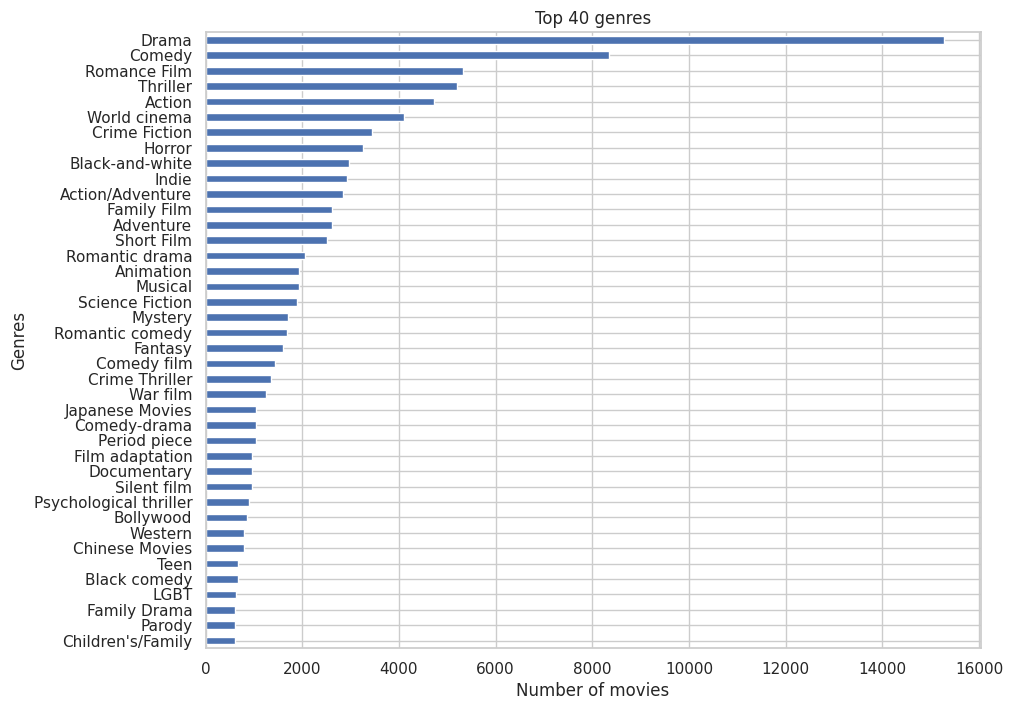

In [8]:
columns_needed = ['Plot', 'Genres', 'merge_year', 'distilbert_emotions']
# we take only the films were the plot is not missing
df_with_plot = df.dropna(subset=['Plot'])[columns_needed]
genre_count = df_with_plot['Genres'].explode().value_counts()
plot_top_genres(genre_count)

## Visualizing Emotional Distributions Across Popular Genres
To gain a preliminary understanding of how emotions are distributed across the most popular movie genres, we created a heatmap. The selected genres are:
- **Action, Action/Adventure, Adventure, Black-and-white, Comedy, Crime Fiction, Drama, Family Film, Horror, Romance Film, Romantic Drama, Short Film, Thriller**, and World Cinema.

The emotions analyzed are:
- **Disgust, Fear, Anger, Neutral, Sadness, Surprise**, and **Joy**.

The heatmap visually illustrates the relative intensity of each emotion within each genre, providing insights into the emotional tone associated with different film genres. This visualization sets the stage for a more detailed statistical analysis.

In [9]:
top_genres_df = get_top_genres_df(df_with_plot, genre_count)
genre_emotion_mean_df = get_genre_emotion_mean_df(top_genres_df, EMOTIONS)

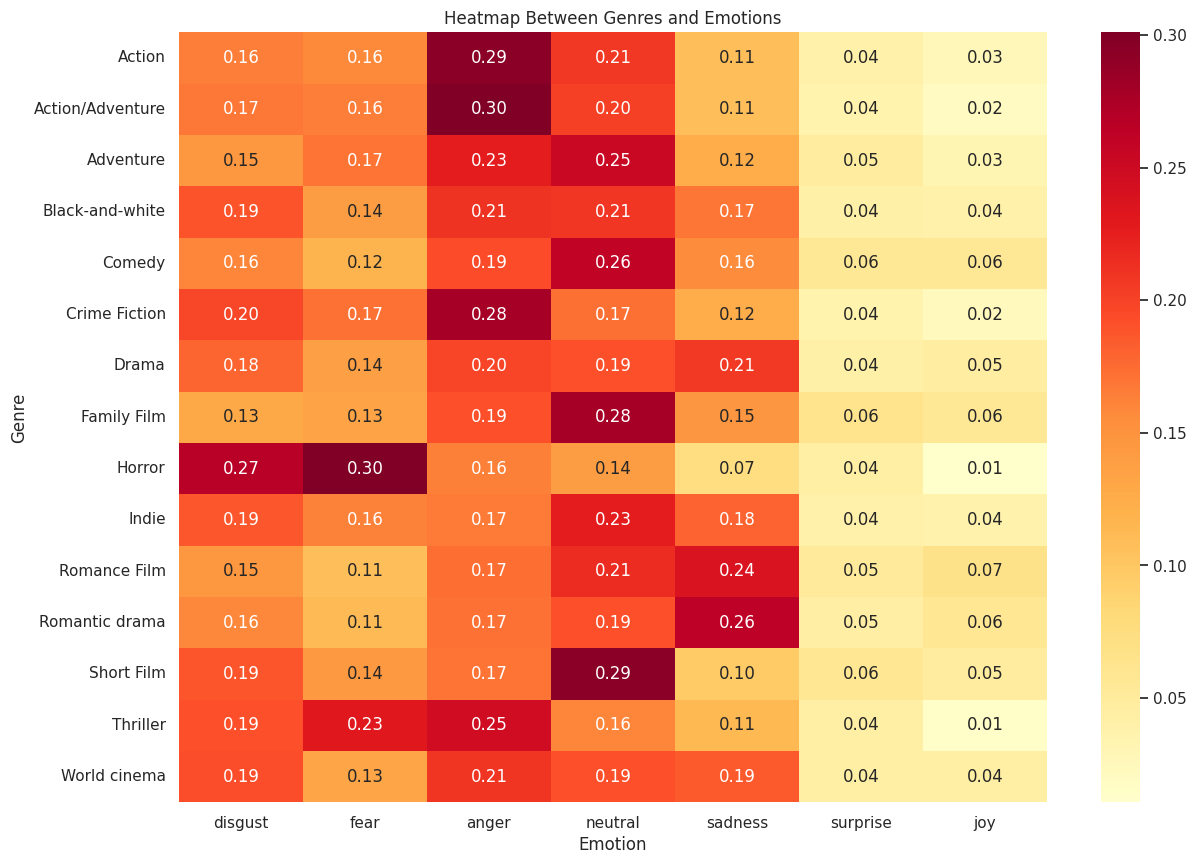

In [10]:
plot_heatmap(genre_emotion_mean_df)

## Testing Emotional Variation Across Genres Using MANOVA
To formally evaluate the variation of emotions across genres, we performed a **Multivariate Analysis of Variance (MANOVA).** MANOVA is a statistical test used when there are multiple dependent variables (in this case, emotions) and one or more categorical independent variables (here, genres). It tests whether the mean vectors of the dependent variables differ across levels of the independent variable.

## Statistical Theory Behind MANOVA
MANOVA extends the concept of Analysis of Variance (ANOVA) to multiple dependent variables. It tests the null hypothesis (( H_0 )) that the mean vectors of the dependent variables are equal across all groups (genres). Mathematically:
$$H_0:\mu_1 = \mu_2 = ... \mu_k$$

Where:
- $\mu_i$ represents the vector of means for the dependent variables (emotions) in the ( i )-th group (genre).

## Test Statistic
MANOVA calculates the following test statistics to assess the differences:
1. **Pillai's Trace:** $V = \text{trace} [(E(E+H)^{-1})]$ Where $E$ is the error matrix, and $H$ is the hypothesis matrix.
2. **Wilks' Lambda:** $\Lambda = \frac{\det(E)}{\det(E+H)}$. A smaller value of \Lambda indicates a stronger difference among group means.
3. **Hotelling-Lawley Trace:** $T=\text{trace}(HE^{-1})$
4. **Roy's Largest Root:** $\Theta = \text{largest eigenvalue of }HE^{-1}$

In [11]:
result = manova_genre_emotion_mean_df(emotions_without_neutral.copy(), top_genres_df)
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Multivariate linear model
==================================================================
                                                                  
------------------------------------------------------------------
       Intercept        Value  Num DF   Den DF    F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.4863 6.0000 68168.0000 12002.9242 0.0000
         Pillai's trace 0.5137 6.0000 68168.0000 12002.9242 0.0000
 Hotelling-Lawley trace 1.0565 6.0000 68168.0000 12002.9242 0.0000
    Roy's greatest root 1.0565 6.0000 68168.0000 12002.9242 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
         Genres         Value   Num DF    Den DF   F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.8607 84.0000 379954.0376 123.4368 0.0000
         Pillai's trace 0.1458 84.0000 409038.0000 121.2627 0.0000
 Hotelling-Lawley trace 0.1545 84.0000 279139.1349 125.4173 0.0000
    Roy's greatest root 0.0851 14.0000  68173.0000 414.3267 0.0000
==================================================================

"""

## Interpretation
The MANOVA test provide insight into the statistical relationship between the independent variable Genres and multiple dependent variables emotions.
- Null Hypothesis (H_0): The means of the dependent variables (emotions) are equal across all levels of the independent variables Genres.
- Alternative Hypothesis (H_1): At least one of the dependent variable means significantly differs across the levels of Genres.

### Results:
Intercept Results:

The intercept is significant (p < 0.0001), meaning there is significant variation in the non-neutral emotion scores overall, even without considering Genres.

### Genres Results:

The results show that the mean probabilities of the non-neutral emotions (e.g., happiness, sadness, anger) significantly differ across the levels of Genres (p < 0.0001). Wilks’ Lambda = 0.8607: About 14% of the variation in the non-neutral emotions is explained by Genres. Pillai's Trace = 0.1458: This reinforces the modest but significant effect size. Roy’s Greatest Root = 0.0851: Suggests that one or more specific emotions might be strongly affected by Genres.
Comparing Emotional Scores Across Relevant Genres
To delve deeper into how each emotion is distributed among the most relevant genres, we created a series of bar plots. Each plot represents the average score of a specific emotion for each genre.
For better context, we added a horizontal line in each plot, indicating the weighted average score for that emotion across all relevant genres. This line serves as a benchmark, allowing us to identify which genres exhibit scores significantly above or below the overall average.

## Comparing Emotional Scores Across Relevant Genres
To delve deeper into how each emotion is distributed among the most relevant genres, we created a series of bar plots. Each plot represents the average score of a specific emotion for each genre.

For better context, we added a horizontal line in each plot, indicating the weighted average score for that emotion across all relevant genres. This line serves as a benchmark, allowing us to identify which genres exhibit scores significantly above or below the overall average.

In [12]:
sum_movies = genre_emotion_mean_df['count'].sum()
weight_avg = genre_emotion_mean_df[EMOTIONS].mul(genre_emotion_mean_df['count'], axis=0).sum() / sum_movies

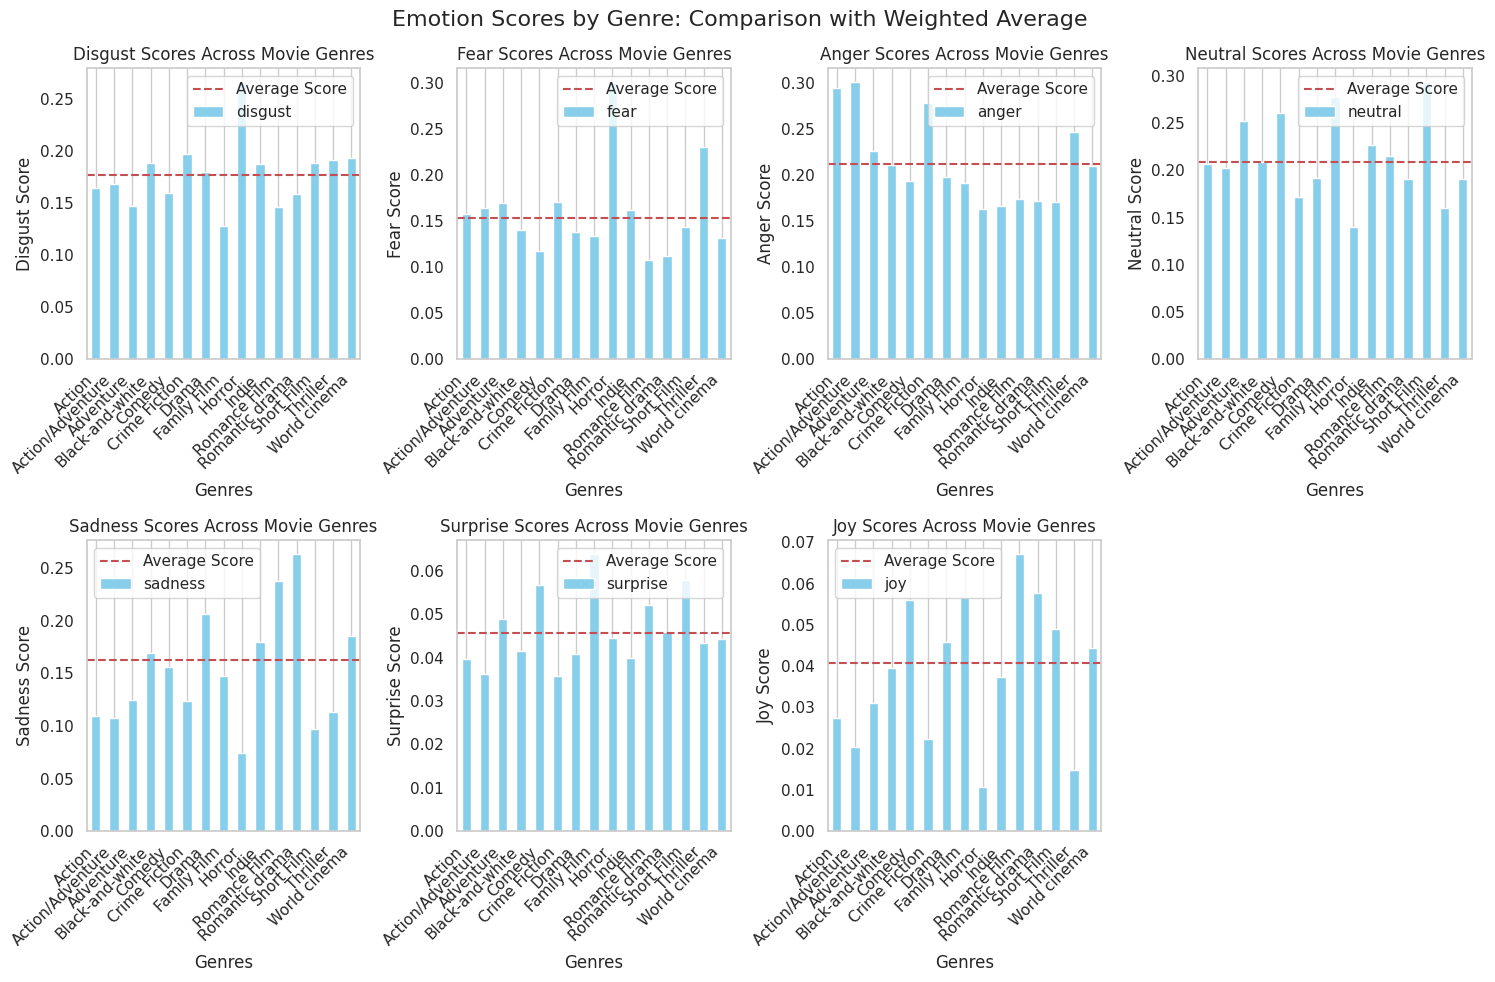

In [13]:
plot_emotion_scores_by_genre(genre_emotion_mean_df, weight_avg, EMOTIONS)

## Statistical Validation of Emotional Representation in Genres Using T-tests
To address potential imbalances in model classification and gain a deeper understanding of which emotions are significantly associated with specific genres, we performed t-tests. This analysis compares the emotion scores for each genre against the weighted average score for that emotion across all genres.
___
## Statistical Theory Behind the T-test
The **t-test** is a statistical test used to determine if the mean of a sample differs significantly from a known value (one-sample t-test) or another sample (two-sample t-test). In our case, we used the one-sample t-test to compare the mean emotion score for a given genre to the weighted average score.

### Null and Alternative Hypotheses
For each emotion within each genre:
- **Null Hypothesis $H_0$:** The mean emotion score for the genre is equal to the weighted average score across all genres. $H_0: \mu_{\text{genre}} = \mu_{\text{weighted~avg}}.
- **Alternative Hypothesis $H_1$:** The mean emotion score for the genre is significantly higher than the weighted average score.

## Test Statistic
The t-statistic is calculated as:
$$t=\frac{\bar{x}-\mu}{\frac{s}{\sqrt n}}$$
Where:
- $\bar{x}=$ sample mean (emotion score for the genre)
- $mu=$ population mean (weighted average emotion score)
- $s=$ standard deviation of the sample
- $n=$ sample size

## Degrees of Freedom
The degrees of freedom (df) for the t-test is $\text{df} =n-1$

## Interpretation
The resulting ( p )-value from the t-test indicates whether the mean emotion score for the genre is significantly higher than the weighted average:
- If ( p < 0.05 ), we reject (H_0), concluding that the genre has a significantly higher score for that emotion.

___
## Visualizing Significant Emotions for Each Genre
To illustrate the results of the t-tests, we created a series of bar plots. Each plot represents the emotion scores for a specific genre. Bars corresponding to emotions that are significantly higher than the weighted average (based on the t-test results) are highlighted in a distinct color.

## Insights from the Visualization
These plots allow us to:
- Clearly identify the emotions that define each genre statistically.
- Understand how different genres deviate from the overall emotional landscape.
This combined statistical and visual approach provides a robust way to validate the relationship between emotions and genres.

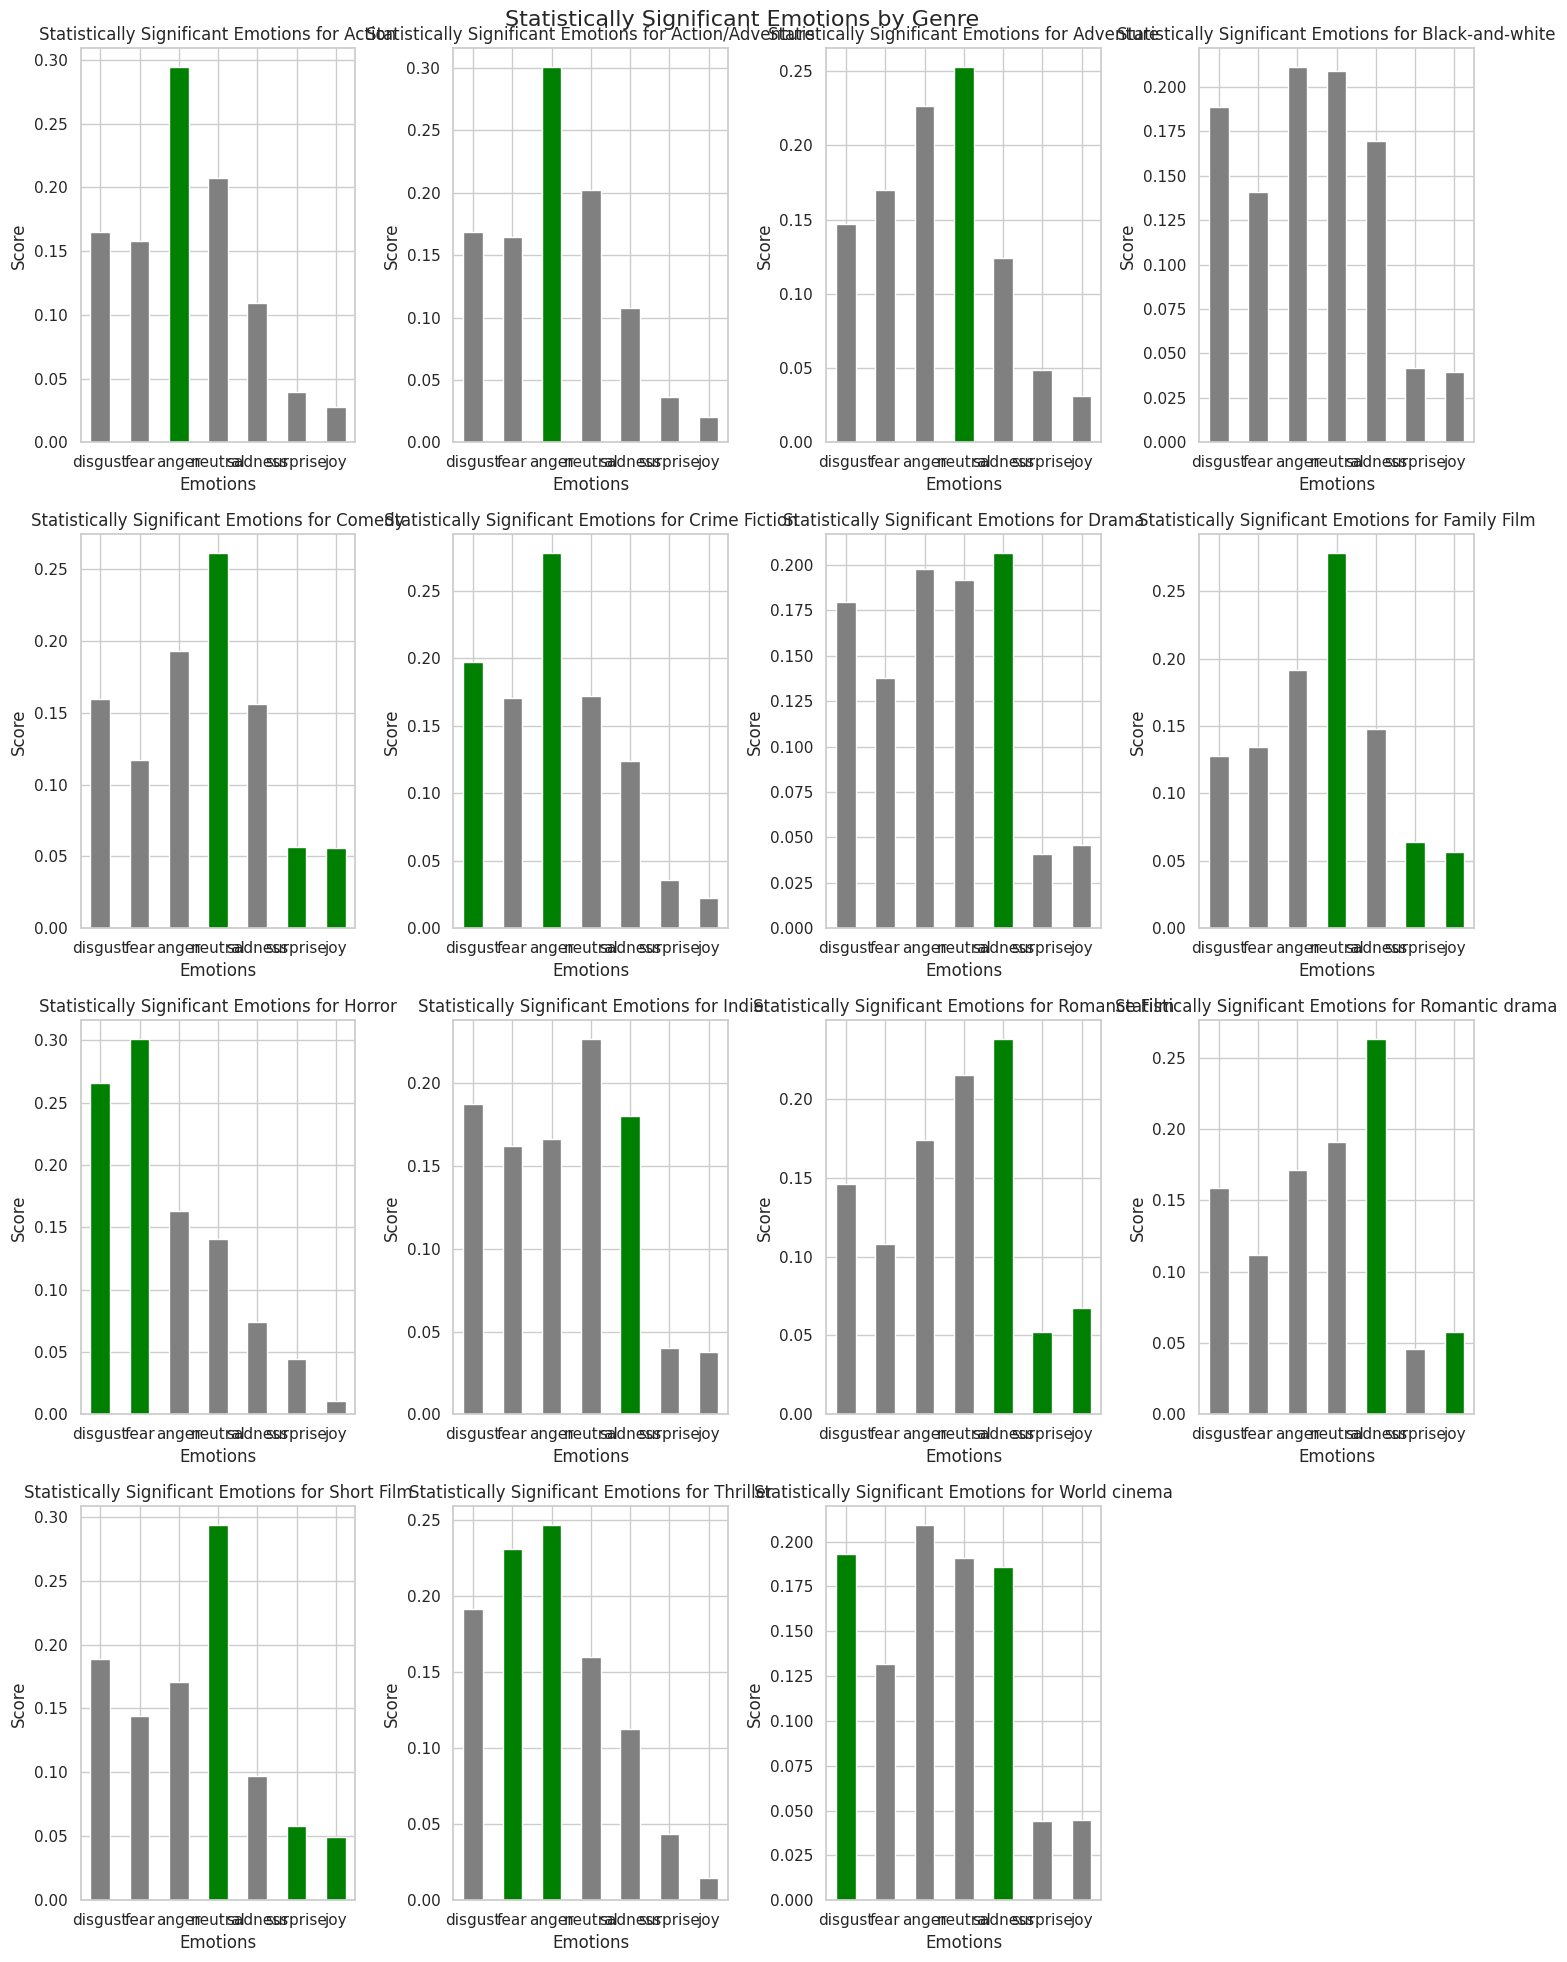

In [14]:
find_significant_emotions_by_genre(genre_emotion_mean_df, weight_avg, EMOTIONS)

## Results: Predominant Emotional Tones by Genre and Their Inclusion in Time Series Analysis

After analyzing the data, we identified the predominant emotional tones for each genre and made decisions on whether to include them in the time series analysis. Below are the results:

- **Action**:  
  The predominant tone is **anger**, which aligns with expectations for this genre. We will explore how the expression of anger has evolved over time in the time series analysis.

- **Action/Adventure**:  
  The predominant tone is also **anger**, similar to the Action genre. To avoid redundancy, we will only include the Action genre in the time series analysis.

- **Adventure**:  
  The predominant tone is **neutral**, which is surprising. However, analyzing the evolution of a neutral emotion over time does not seem insightful. Furthermore, Adventure is closely related to Action, so it will not be included in the time series analysis.

- **Black-and-White**:  
  There is no predominant tone, which makes sense as this category reflects a characteristic of the movie rather than a genre. It will not be included in the time series analysis.

- **Comedy**:  
  The predominant tones are **neutral**, **surprise**, and **joy**. While we are not interested in the neutral emotion, we will include **surprise** and **joy** in the time series analysis.

- **Crime Fiction**:  
  The predominant tones are **disgust** and **anger**. Both will be included in the time series analysis.

- **Drama**:  
  The predominant tone is **sadness**, which is expected for this genre. This emotion will be included in the time series analysis.

- **Family Film**:  
  The predominant tones are **neutral**, **surprise**, and **joy**. Similar to Comedy, we will exclude neutral but include **surprise** and **joy** in the time series analysis.

- **Horror**:  
  The predominant tones are **fear** and **disgust**. Both will be included in the time series analysis.

- **Indie**:  
  The predominant tone is **sadness**, which is fitting for this genre. We will include sadness in the time series analysis.

- **Romance Film**:  
  The predominant tones are **sadness**, **joy**, and **surprise**. To focus the analysis, we will include only **sadness** and **joy** in the time series analysis.

- **Romantic Drama**:  
  The predominant tones are **sadness** and **joy**, which are similar to those in Romance Film. To avoid redundancy, this genre will not be included in the time series analysis.

- **Short Film**:  
  The predominant tones are **neutral**, **surprise**, and **joy**. Like Black-and-White, this category reflects a characteristic rather than a genre. It will not be included in the time series analysis.

- **Thriller**:  
  The predominant tones are **fear** and **anger**. Both will be included in the time series analysis.

- **World Cinema**:  
  This genre represents films made outside the American motion picture industry, often opposing the aesthetics and values of mainstream Hollywood. To gain insights into emotional trends outside Hollywood, we will include this genre. The predominant tones are **sadness** and **disgust**, both of which will be included in the time series analysis.

# How has the emotional tone of films evolved over time within each genre?
### To address this research question, we began by conducting a visualization analysis to explore the evolution of emotional tones over time. Specifically, we plotted the time series of each emotion score for the genres included in our analysis.

In [15]:
emotion_by_time = get_time_series_data(emotions_df, EMOTIONS)

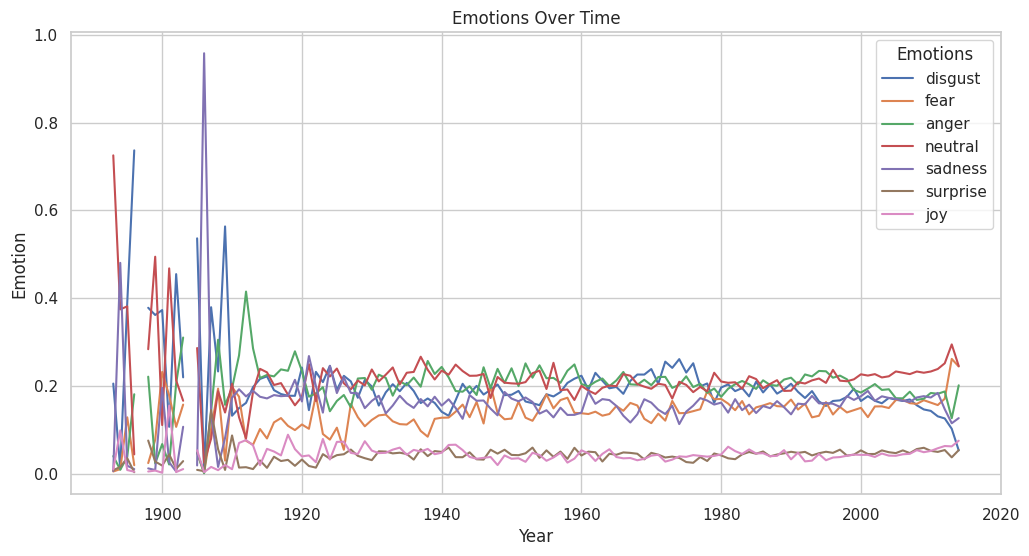

In [16]:
plot_emotions_by_time(emotion_by_time)

<Axes: xlabel='merge_year', ylabel='Count'>

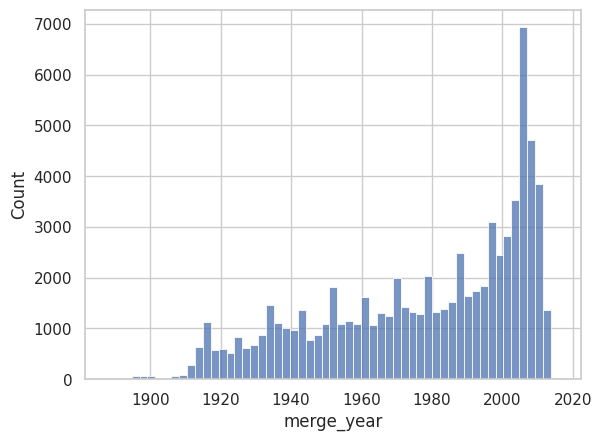

In [17]:
sns.histplot(emotions_df['merge_year'], kde=False)

In [18]:
movie_counts_by_time = get_movie_counts_by_time(emotions_df)
movie_counts_by_time[movie_counts_by_time.index >= 2010]

counts
merge_year        
2010          2024
2011          1824
2012          1195
2013           164
2014            17
2015             4
2016             3

In [19]:
emotions_by_relevant_time = emotion_by_time[(emotion_by_time.index >= 1925) & (emotion_by_time.index < 2012)]

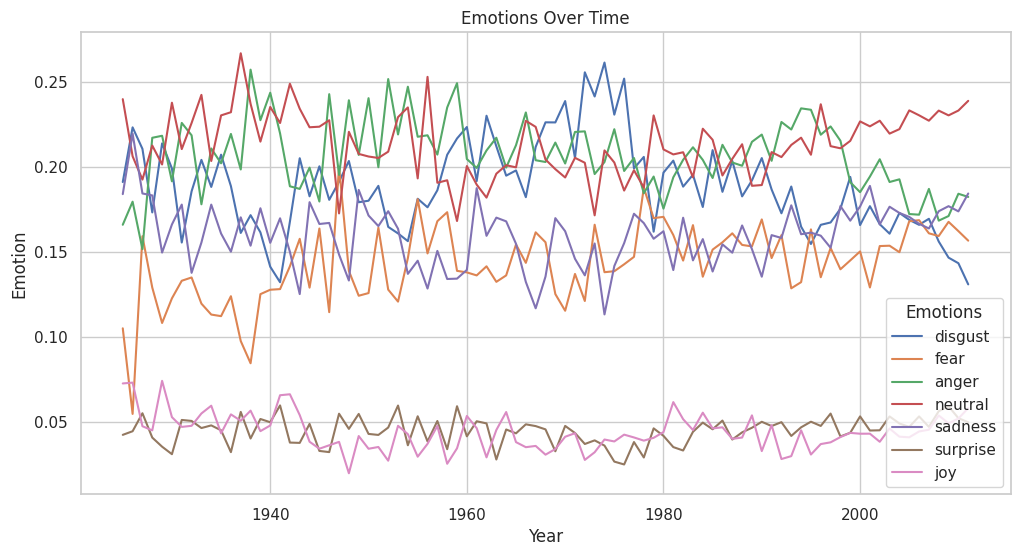

In [20]:
plot_emotions_by_time(emotions_by_relevant_time)

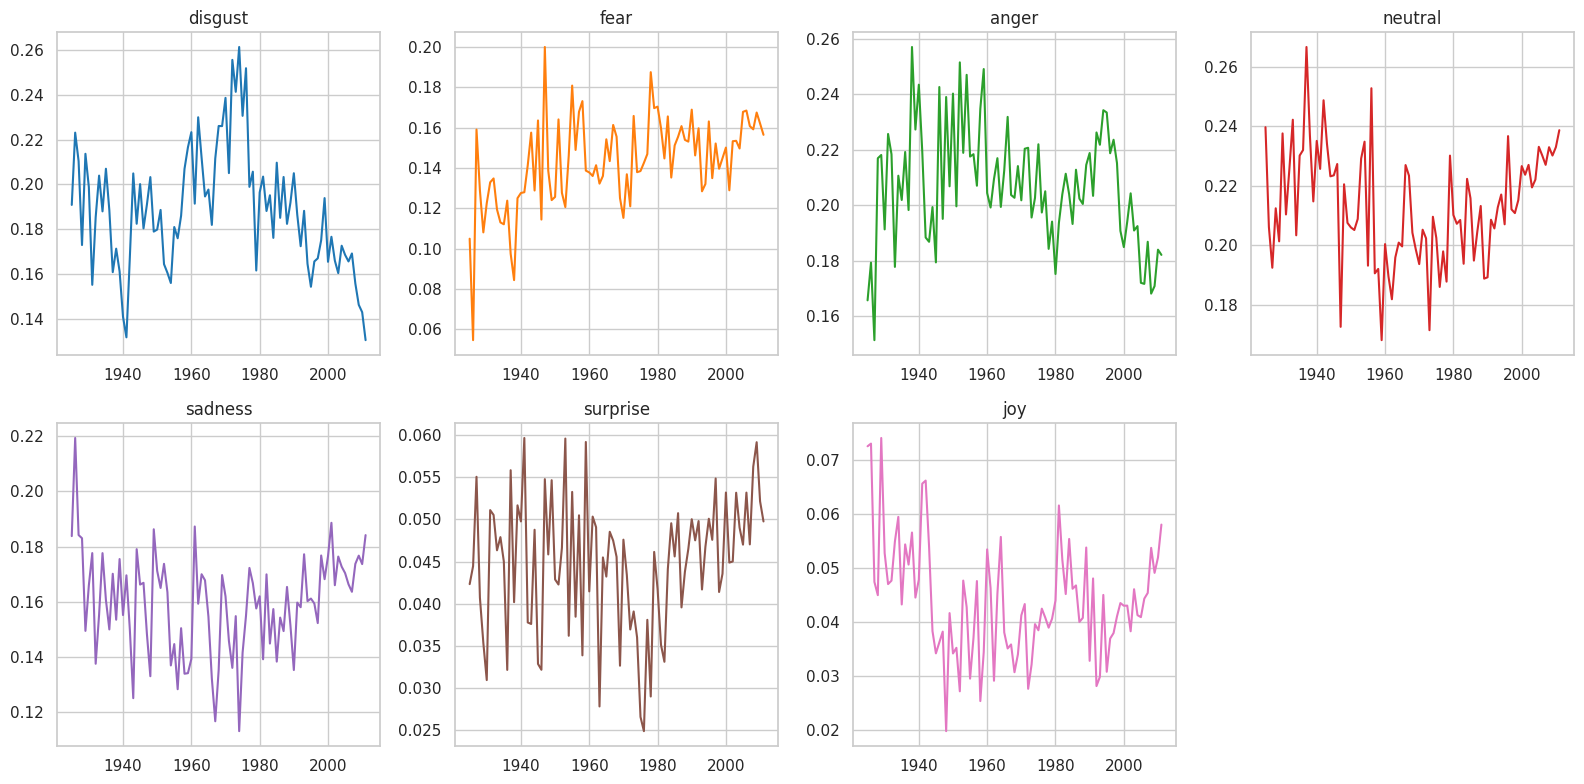

In [21]:
plot_indiv_emotions_by_time(emotions_by_relevant_time)

### Initial Observations

#### From the initial visualizations, we observed that:
- Prior to **1925** and after **2010**, the number of data points (films) was significantly lower compared to other years.  
- This lack of data resulted in high variance, making the time series unstable and less reliable during these periods.

### Decision

To ensure the stability and reliability of our analysis, we excluded all films released before **1925** and after **2011** from our dataset. This adjustment focuses the analysis on a time range with sufficient data points for each year, providing more accurate and meaningful insights into the evolution of emotional tones across genres.

#### Now let's try to gain a deeper understanding and even make some predictions with time series analysis

## Time Series Analysis: Applying the Box-and-Jenkins Procedure and ARIMA Models

To explore how emotional tones have evolved over time within each genre, we focused on the relevant genres and their predominant tones identified in the first research question. For each selected time series, we applied the **Box-and-Jenkins procedure**, culminating in the use of **ARIMA models** to analyze trends and patterns.

---

### Theory: The Box-and-Jenkins Procedure

The **Box-and-Jenkins procedure** is a systematic methodology for building and analyzing time series models, particularly **ARIMA models**. It involves three primary stages:

1. **Identification**:  
   - Transform the raw data (e.g., differencing or log transformation) to achieve stationarity, where the statistical properties (mean and variance) remain constant over time.
   - Use tools such as the **autocorrelation function (ACF)** and the **partial autocorrelation function (PACF)** to identify the order of the ARIMA model components.

2. **Estimation**:  
   - Fit an ARIMA model to the transformed data by estimating its parameters (\(p\), \(d\), and \(q\)) using statistical methods like maximum likelihood estimation.

3. **Diagnostic Checking**:  
   - Validate the model by analyzing residuals (differences between observed and predicted values). Residuals should resemble white noise: uncorrelated and normally distributed with zero mean.
   - If the model is inadequate, refine it by revisiting the identification and estimation steps.

#### Stationarity
Stationarity is critical in time series modeling. A time series is stationary if its statistical properties, such as mean, variance, and autocorrelation, are constant over time. Non-stationary data can be made stationary through techniques like **differencing**.

#### Autocorrelation and Partial Autocorrelation
- **Autocorrelation Function (ACF)**: Measures the correlation between observations at different lags.
- **Partial Autocorrelation Function (PACF)**: Measures the correlation between observations at different lags, accounting for the correlations at intermediate lags.

---

### ARIMA Models: Theory and Formulation

An **ARIMA model** (AutoRegressive Integrated Moving Average) is a class of models that explains a time series based on its own past values, past forecast errors, and a differencing term to achieve stationarity.

#### Components of ARIMA
ARIMA(\(p, d, q\)) has three components:
1. **AutoRegressive (AR)** component (\(p\)):  
   Relates the current value of the series to its past values.  
   Formula:  
   $$
   X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t
   $$
   Where:
   - \($X_t$\): Value at time \(t\)
   - \($\phi_i$\): AR coefficients
   - \($\epsilon_t$\): White noise (random error)

2. **Integrated (I)** component (\(d\)):  
   Represents the number of differencing operations needed to make the time series stationary.  
   Differencing formula:  
   $$
   X_t' = X_t - X_{t-1}
   $$

3. **Moving Average (MA)** component (\(q\)):  
   Models the dependency between an observation and residual errors from a moving average model applied to lagged observations.  
   Formula:  
   $$
   X_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}
   $$
   Where:
   - \($\theta_i$\): MA coefficients

#### Combined ARIMA Model
The ARIMA(\(p, d, q\)) model is given by:
$$
X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}
$$
Where \(X_t\) represents the \(d\)-th differenced series.

---

### Significance of the Box-and-Jenkins Procedure and ARIMA Models

By applying the Box-and-Jenkins procedure and ARIMA models, we:
- Ensure the time series is appropriately transformed and modeled, capturing both short-term and long-term dependencies.
- Identify significant patterns and trends in emotional tones over time within each genre.
- Provide robust statistical frameworks to predict future trends based on historical data.

In [22]:
genres_emotions_mapping = {
    "Action": ["anger"],
    "Comedy": ["surprise", "joy"],
    "Crime Fiction": ["disgust", "anger"],
    "Drama": ["sadness"],
    "Family Film": ["surprise", "joy"],
    "Horror": ["fear", "disgust"],
    "Indie": ["sadness"],
    "Romance Film": ["sadness", "joy"],
    "Thriller": ["fear", "anger"],
    "World cinema": ["sadness", "disgust"]
}

genre_timeseries_df = get_timeseries_by_genre(emotions_df, genre_count, genres_emotions_mapping, EMOTIONS)
# e.g. genre_timeseries_df[genre_timeseries_df['Genres'] == 'World cinema']

In [23]:
# # Dividing the data into separate dataframes to separate the time series analysis 
# genre_dataframes = {}

# for genre, emotions in genres_emotions_mapping.items():
#     genre_data = genre_timeseries_df[genre_timeseries_df["Genres"] == genre]
#     genre_dataframes[genre] = genre_data[["merge_year"] + emotions].dropna()

# action_timeseries_df = genre_dataframes["Action"]
# comedy_timeseries_df = genre_dataframes["Comedy"]
# crime_fiction_timeseries_df = genre_dataframes["Crime Fiction"]
# drama_timeseries_df = genre_dataframes["Drama"]
# family_film_timeseries_df = genre_dataframes["Family Film"]
# horror_timeseries_df = genre_dataframes["Horror"]
# indie_timeseries_df = genre_dataframes["Indie"]
# romance_flim_timeseries_df = genre_dataframes["Romance Film"]
# thriller_timeseries_df = genre_dataframes["Thriller"]
# world_cinema_timeseries_df = genre_dataframes["World cinema"]

## Machine Learning-Based Approach to Modeling Multiple Time Series

Given the complexity of dealing with multiple time series simultaneously, we adopted a machine learning-inspired approach to select the best ARIMA model for each time series. This method combined statistical testing, parameter optimization, and model selection based on the Akaike Information Criterion (AIC).

---

### Augmented Dickey-Fuller Test: Testing for Stationarity

To determine whether each time series was stationary, we used the **Augmented Dickey-Fuller (ADF) test**. The ADF test checks the null hypothesis ($H_0$) that a unit root is present in the time series, indicating non-stationarity. 

#### Hypotheses
- $H_0$: The time series has a unit root (non-stationary).
- $H_1$: The time series does not have a unit root (stationary).

#### Test Statistic
The ADF test statistic is derived from the regression equation:
$$
\Delta X_t = \alpha + \beta t + \gamma X_{t-1} + \delta_1 \Delta X_{t-1} + \delta_2 \Delta X_{t-2} + \dots + \delta_k \Delta X_{t-k} + \epsilon_t
$$
Where:
- $X_t$: Value of the series at time $t$.
- $\Delta X_t = X_t - X_{t-1}$: First differenced series.
- $t$: Time trend (optional).
- $\epsilon_t$: White noise error term.
- $\gamma$: The coefficient on $X_{t-1}$ is critical for testing stationarity.

The null hypothesis is rejected if $\gamma < 0$ and the $p$-value is less than 0.05, indicating stationarity.

#### Decision Rule
- If $p$-value > 0.05, we set $d = 1$ (differencing needed).
- If $p$-value \(\leq\) 0.05, we set $d = 0$ (no differencing needed).

---

### Parameter Optimization: ARIMA Orders

We evaluated various combinations of the ARIMA orders:
- **AutoRegressive order ($p$)**: {1, 2, 3}.
- **Moving Average order ($q$)**: {0, 1, 2}.
- **Differencing order ($d$)**: Determined using the ADF test.

For each combination of $p$, $d$, and $q$, we fitted an ARIMA model and selected the best model based on the Akaike Information Criterion (AIC).

---

### Akaike Information Criterion (AIC): Model Selection

The AIC is a metric used to compare statistical models, balancing goodness-of-fit and model complexity. A lower AIC score indicates a better model.

#### AIC Formula
$$
\text{AIC} = 2k - 2 \ln(L)
$$
Where:
- $k$: Number of parameters in the model.
- $L$: Maximum likelihood of the model.

#### Explanation
- The first term ($2k$) penalizes model complexity to prevent overfitting.
- The second term ($-2 \ln(L)$) rewards goodness-of-fit, where $L$ is the likelihood of the model given the data.

By minimizing the AIC, we ensured that the selected model achieved the best trade-off between accuracy and simplicity.

---

### Summary of Our Approach

1. **Stationarity Check**: Performed the ADF test to determine the differencing order ($d$).
2. **Parameter Tuning**: Tested combinations of $p = \{1, 2, 3\}$ and $q = \{0, 1, 2\}$ for the given $d$.
3. **Model Selection**: Chose the ARIMA model with the lowest AIC score for each time series.

This systematic approach enabled us to model the evolution of emotional tones across genres effectively and with statistical rigor.


#### Action movies Time Series Analysis

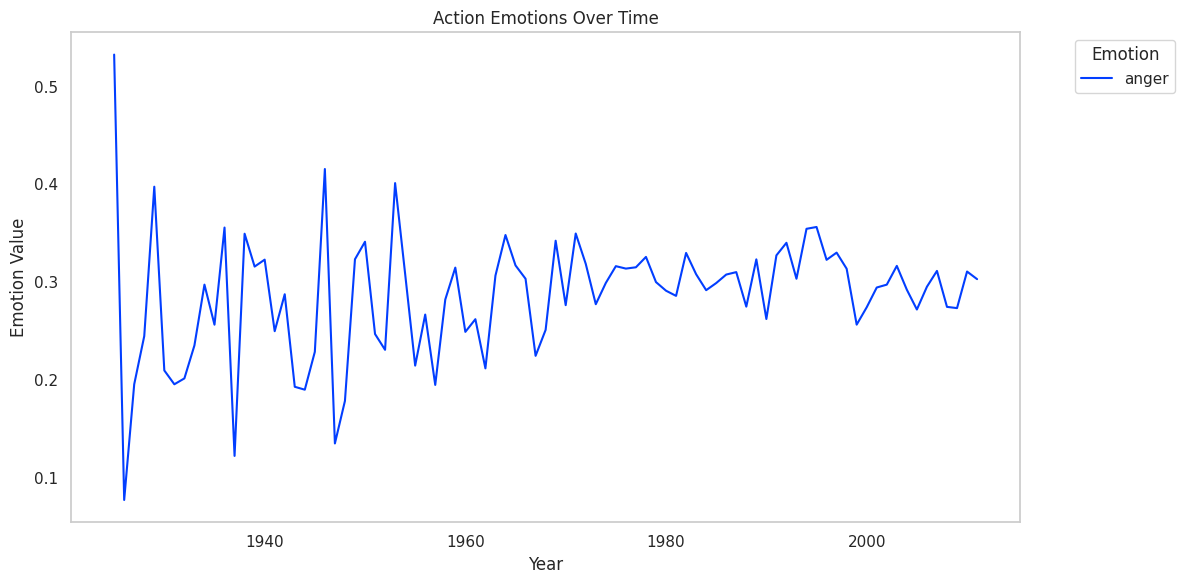

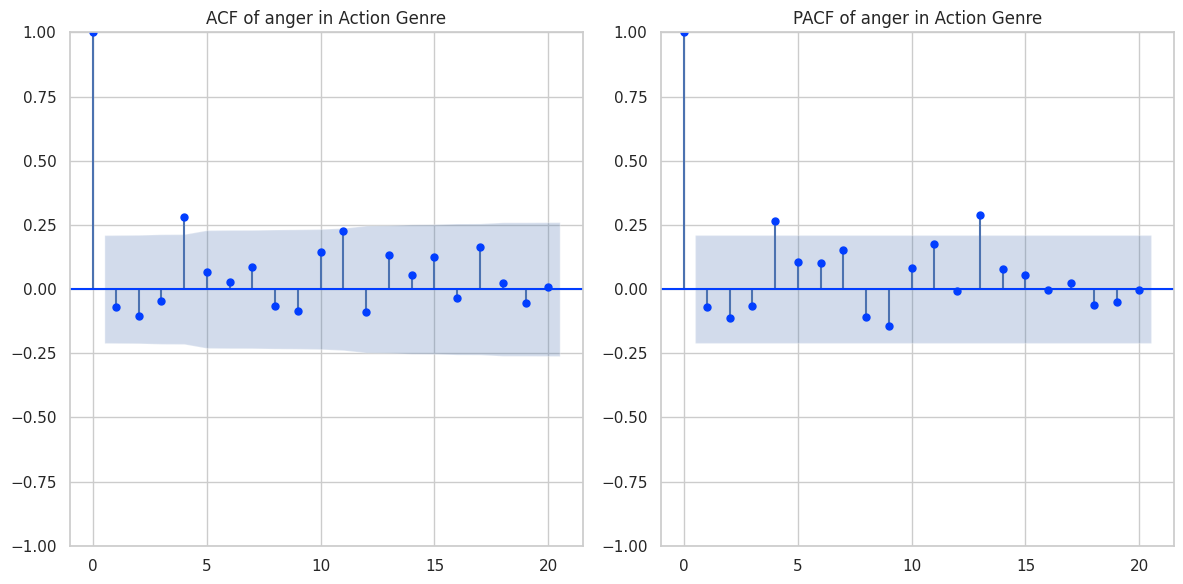

##########################################
 Performing Box-Jenkins Procedure for anger in Action Genre
ADF Statistic: -1.788747153308392
p-value: 0.38606255732366146
The series is not stationary and needs to be differenced.
Best ARIMA Order for anger in Action Genre: (3, 1, 1)


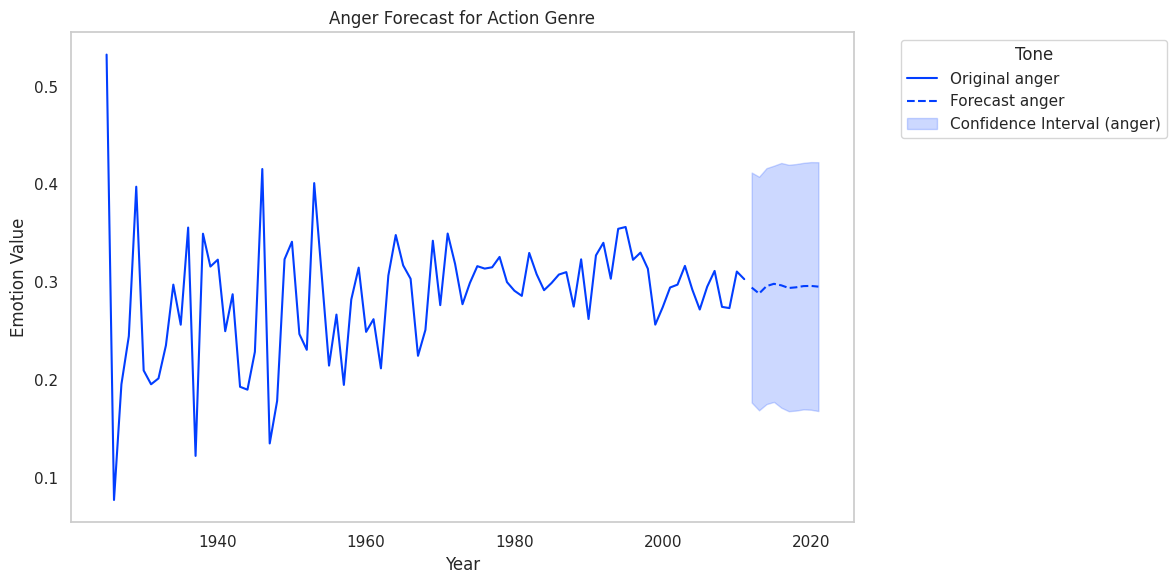

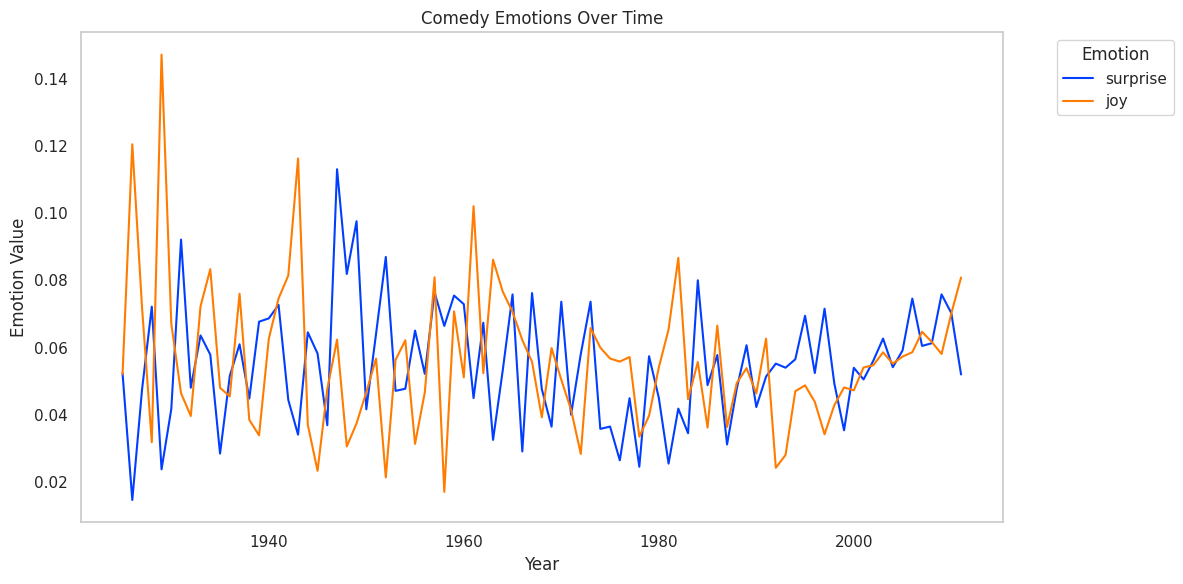

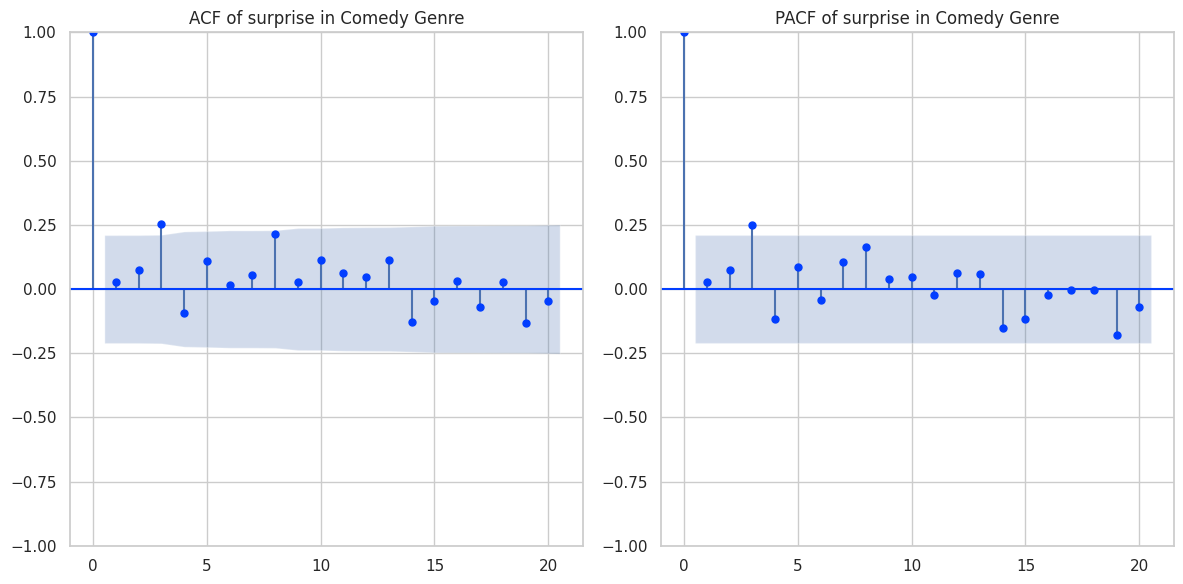

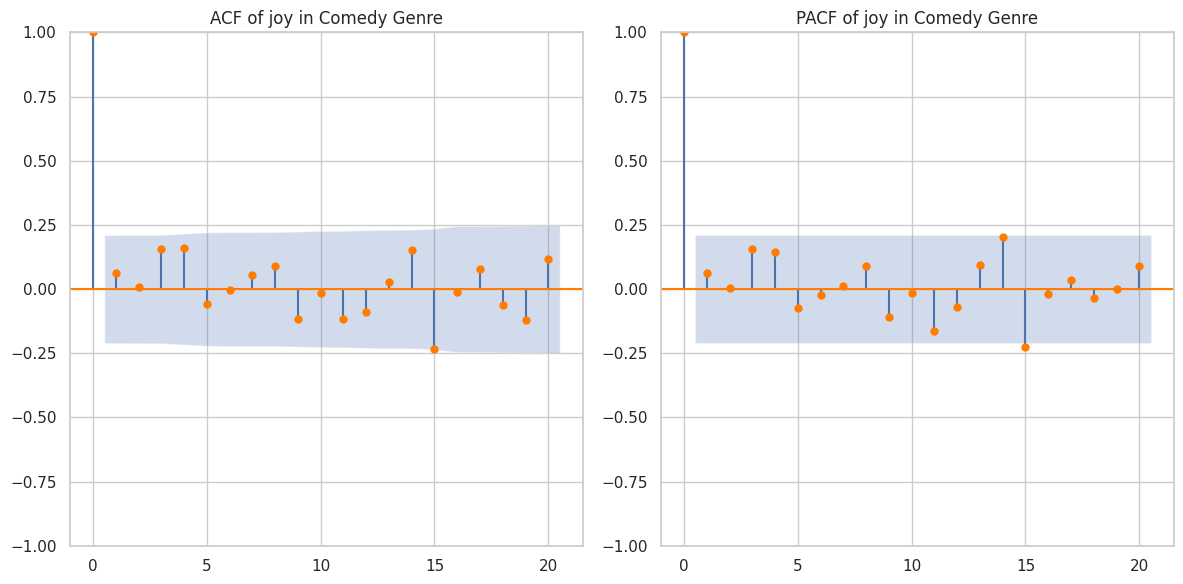

##########################################
 Performing Box-Jenkins Procedure for surprise in Comedy Genre
ADF Statistic: -3.8855435796211166
p-value: 0.00214385221996795
Best ARIMA Order for surprise in Comedy Genre: (3, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Comedy Genre
ADF Statistic: -8.547913514167504
p-value: 9.393303846545818e-14
Best ARIMA Order for joy in Comedy Genre: (1, 0, 0)


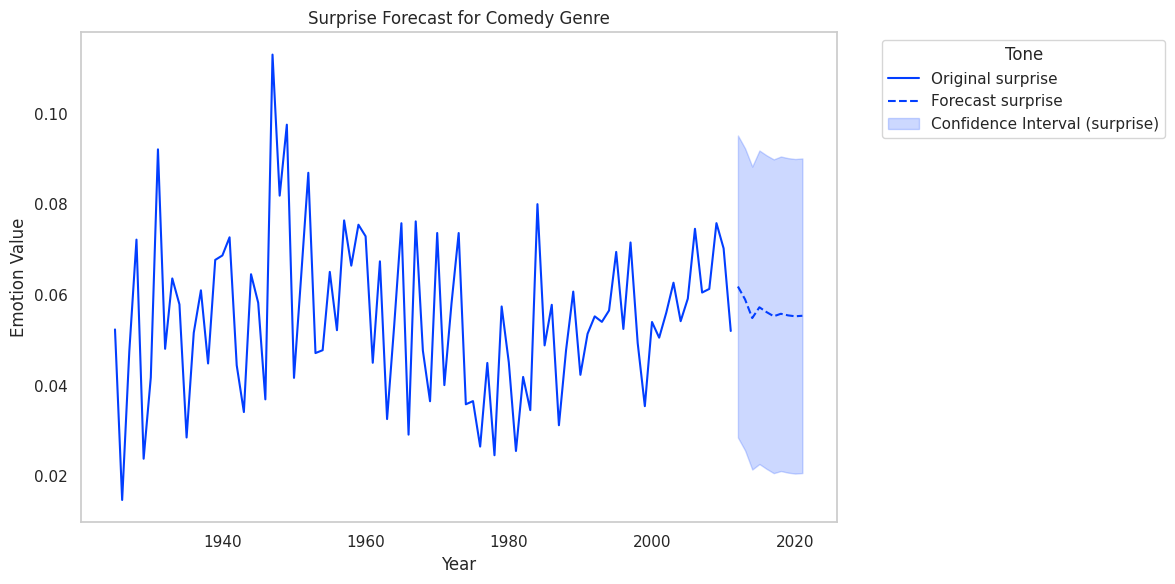

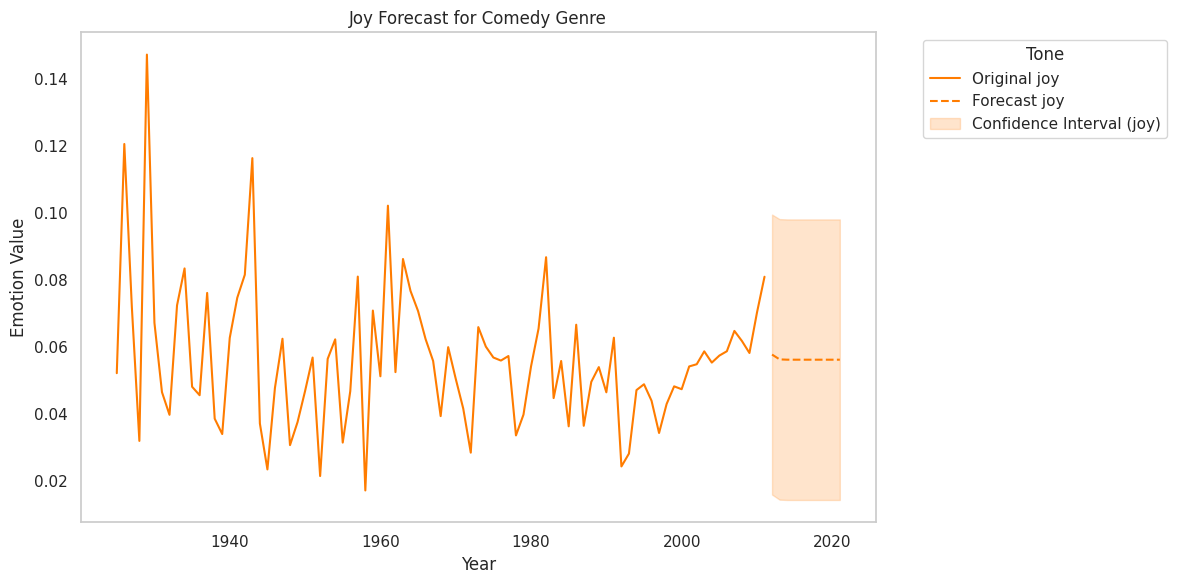

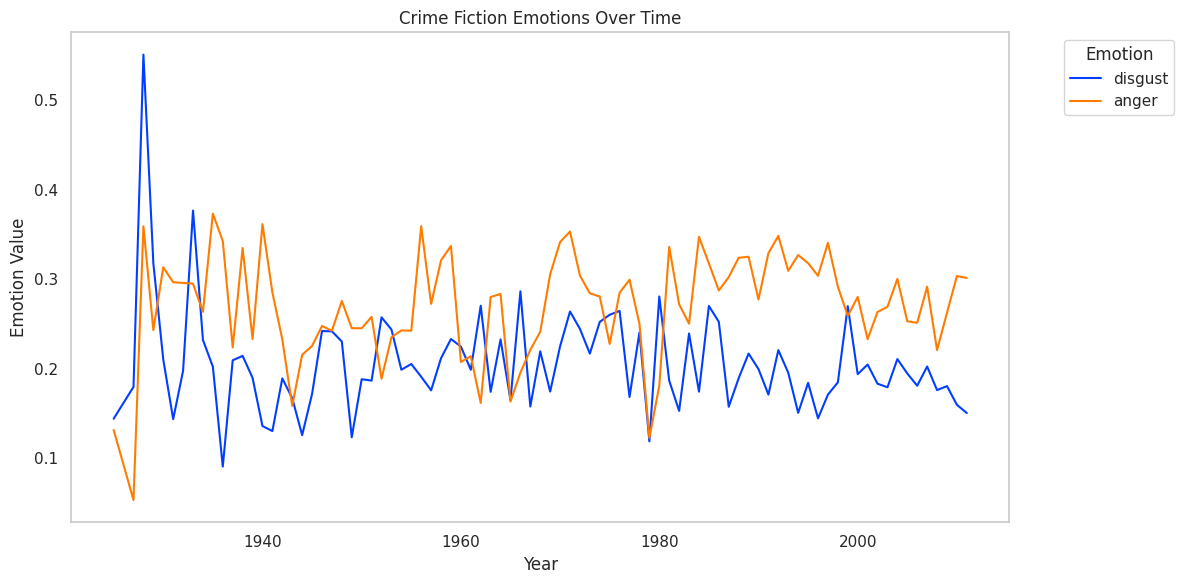

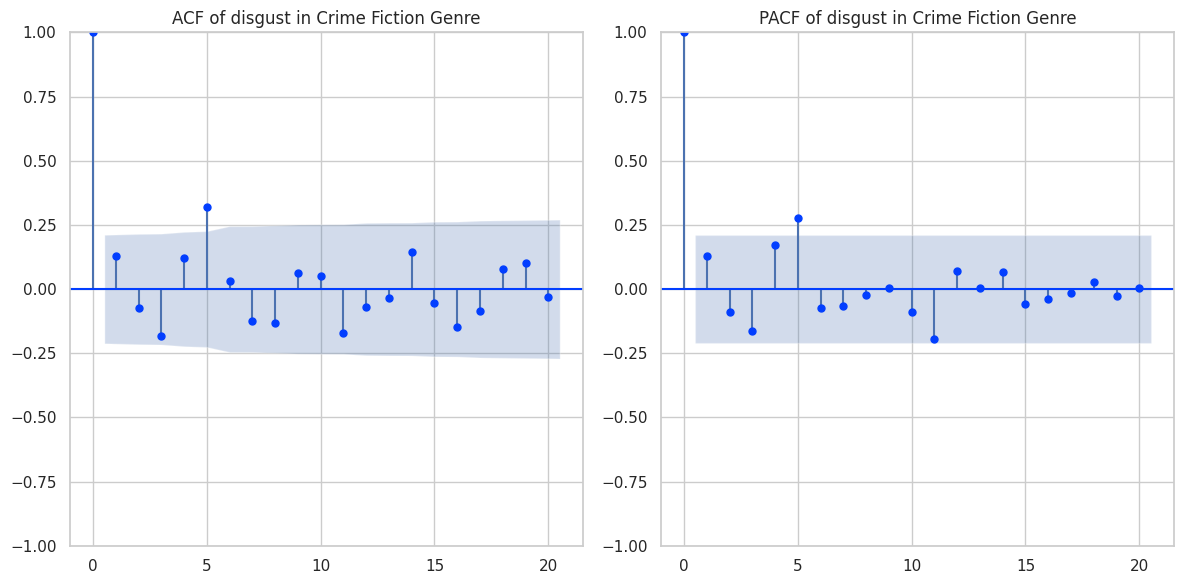

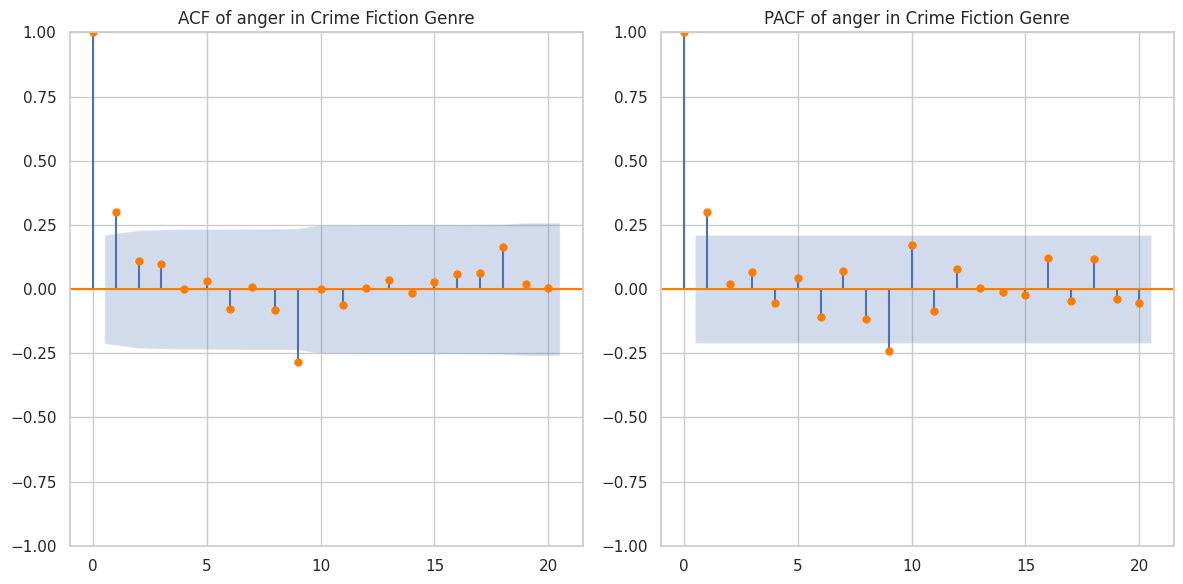

##########################################
 Performing Box-Jenkins Procedure for disgust in Crime Fiction Genre
ADF Statistic: -6.484593942005354
p-value: 1.2701419125844923e-08
Best ARIMA Order for disgust in Crime Fiction Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Crime Fiction Genre
ADF Statistic: -6.914634533444475
p-value: 1.1881064710607695e-09
Best ARIMA Order for anger in Crime Fiction Genre: (1, 0, 0)


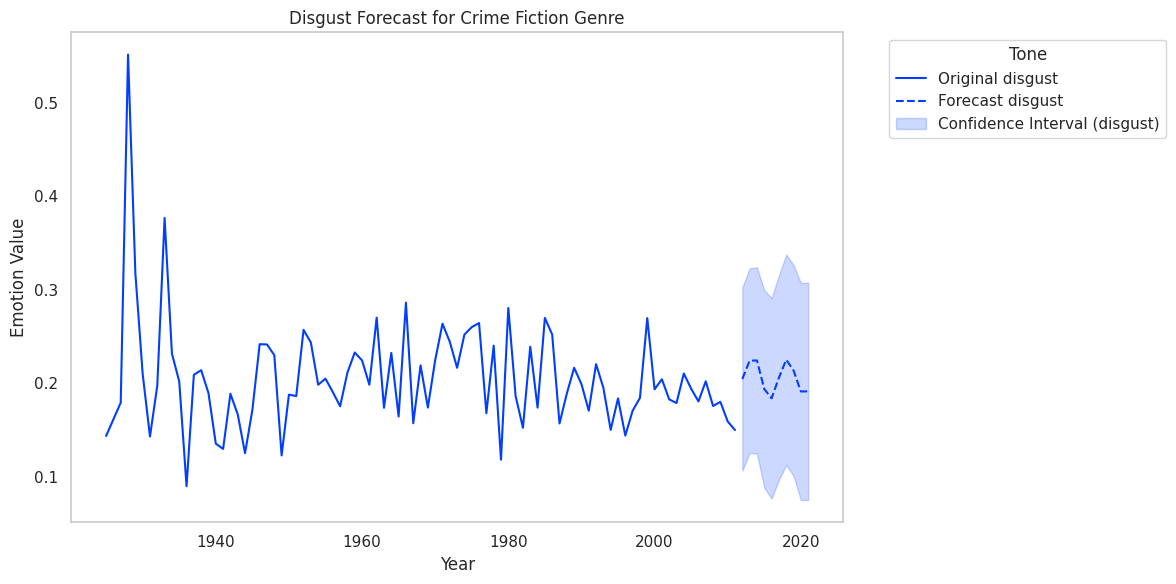

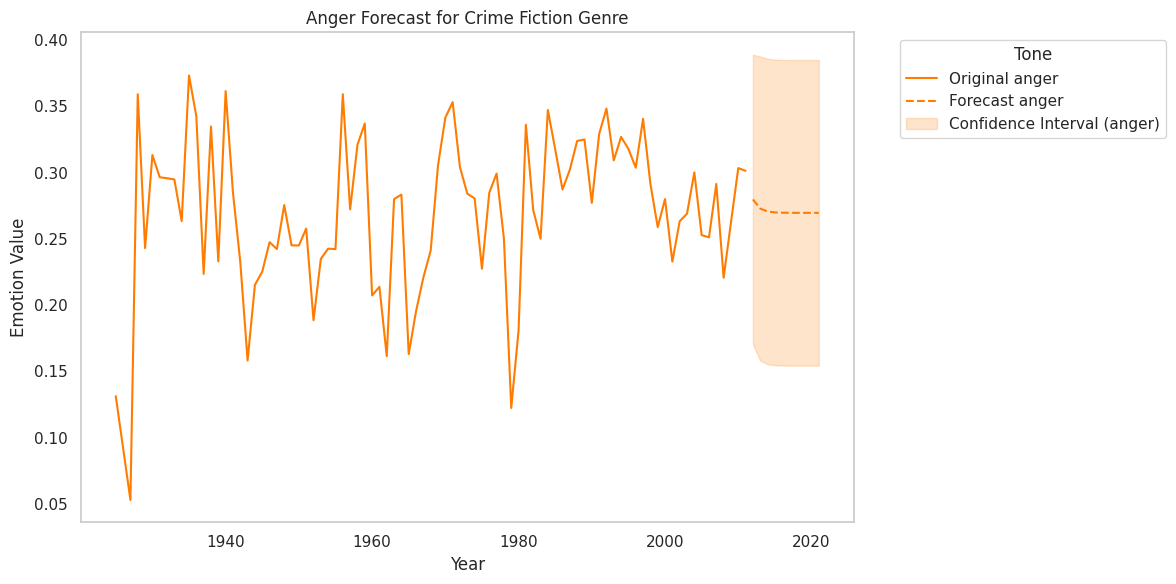

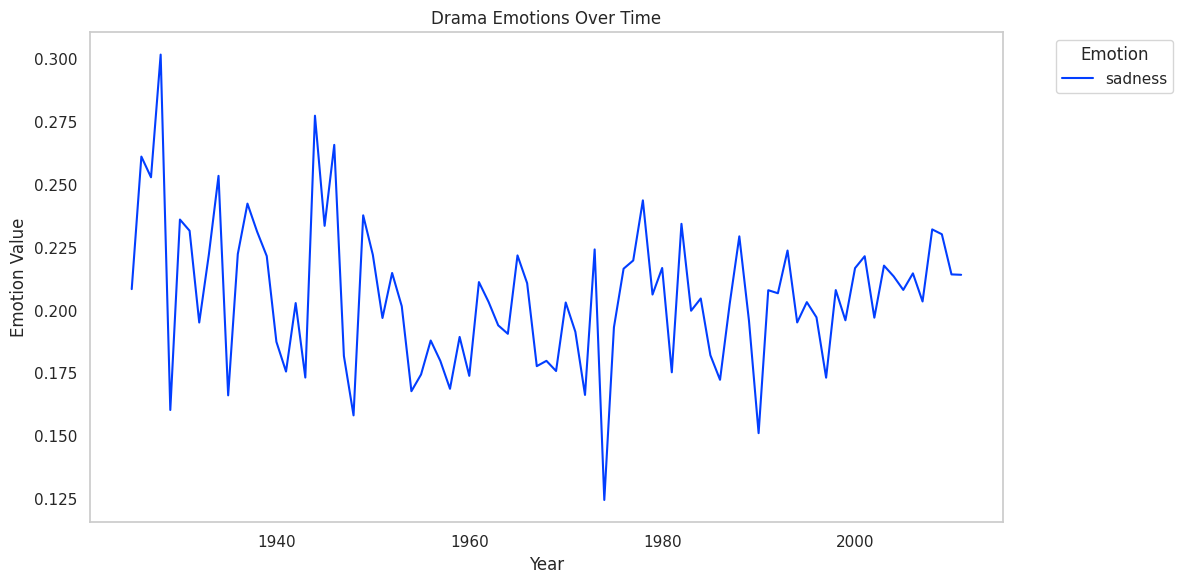

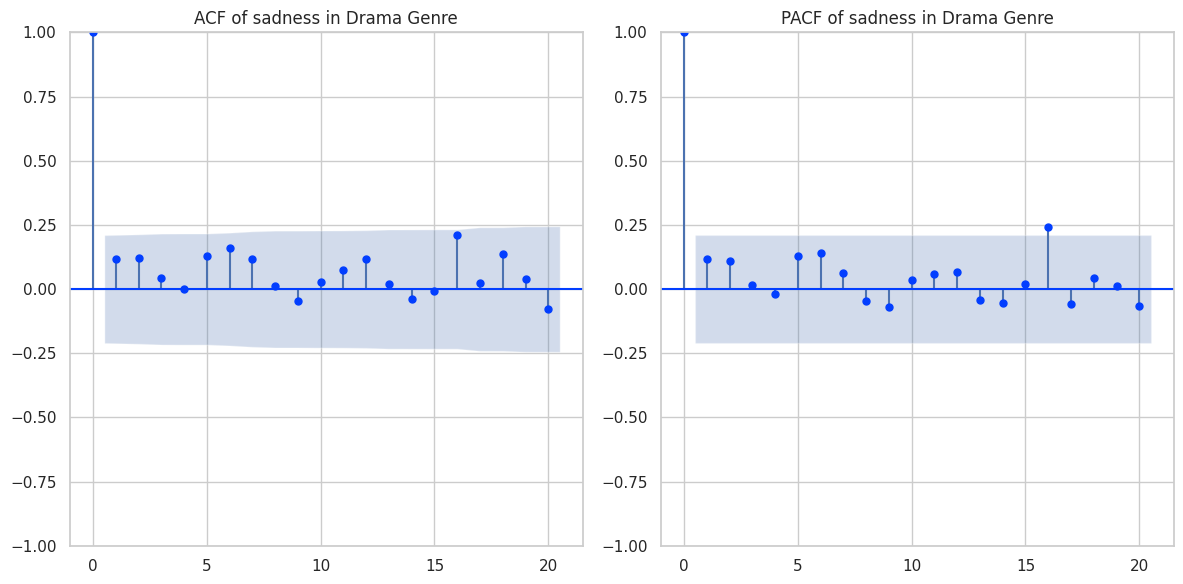

##########################################
 Performing Box-Jenkins Procedure for sadness in Drama Genre
ADF Statistic: -8.131424158962508
p-value: 1.0876387226298188e-12
Best ARIMA Order for sadness in Drama Genre: (1, 0, 1)


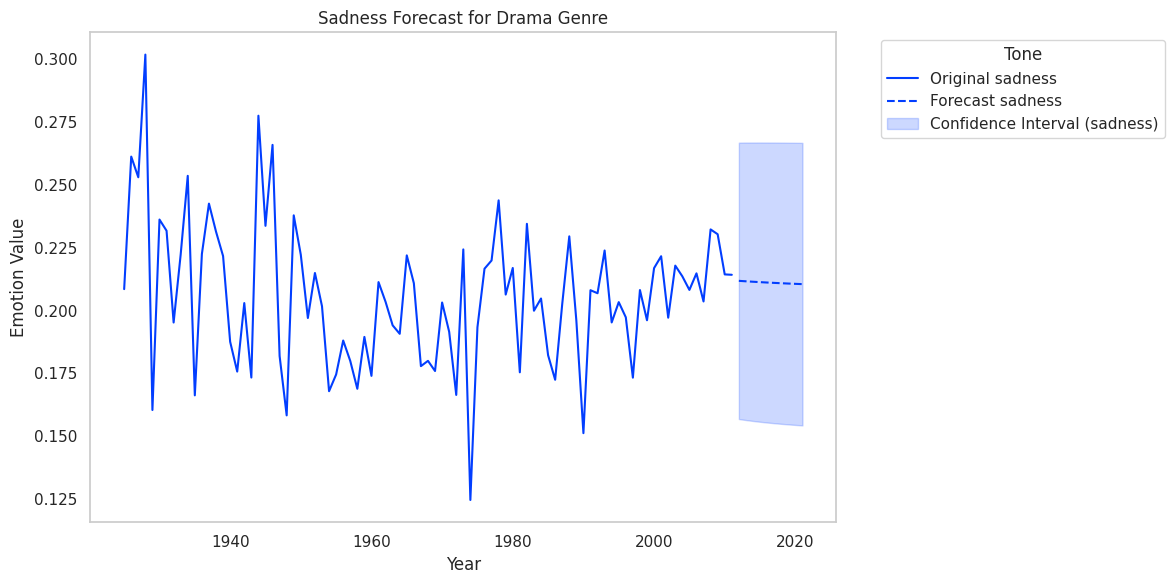

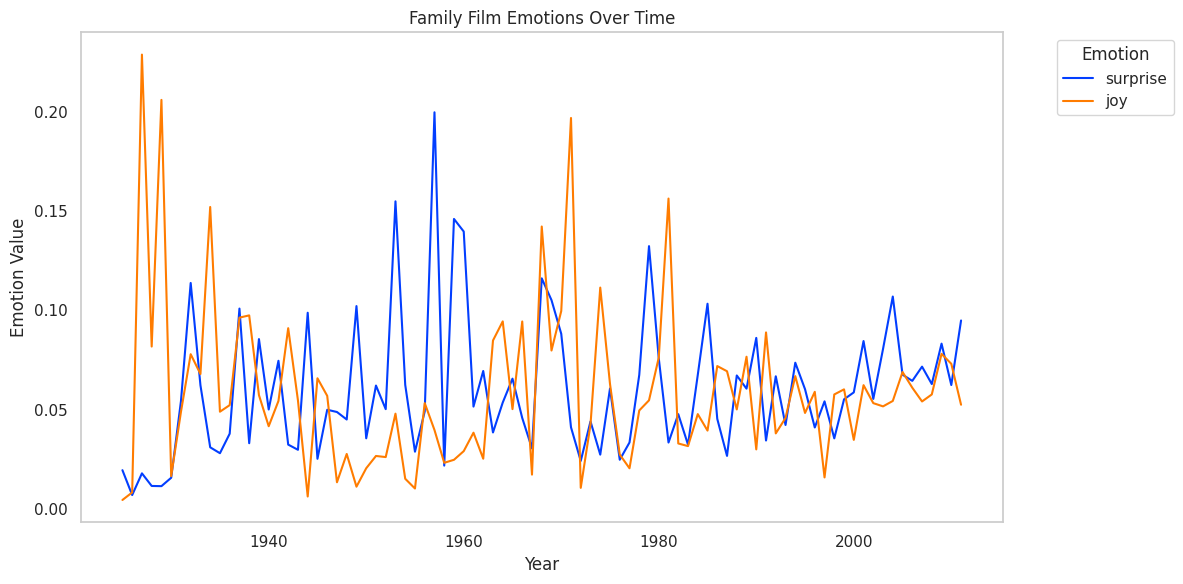

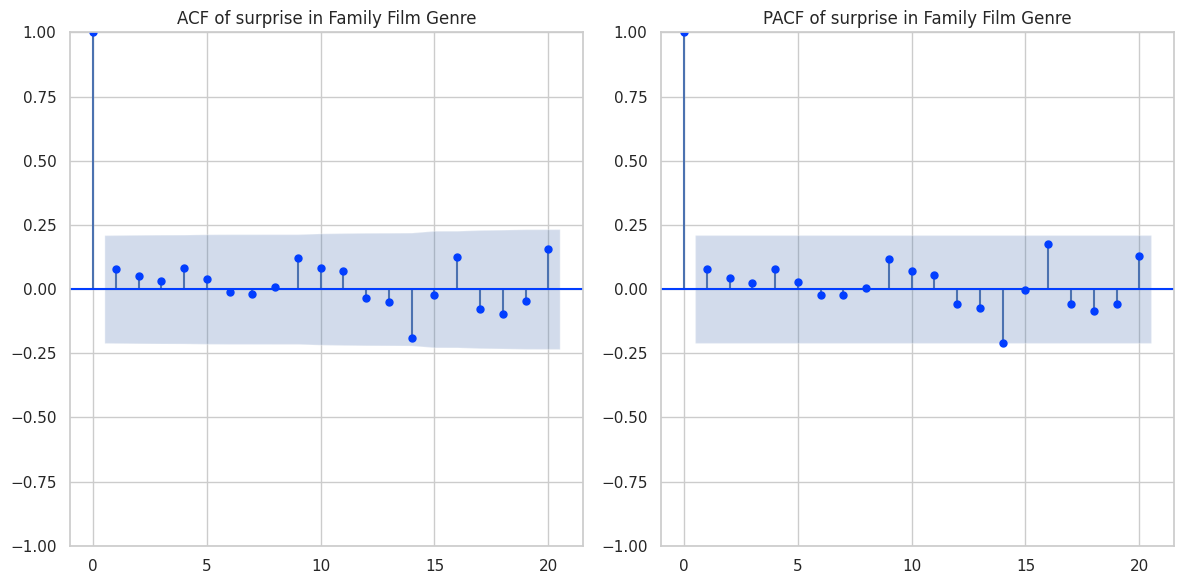

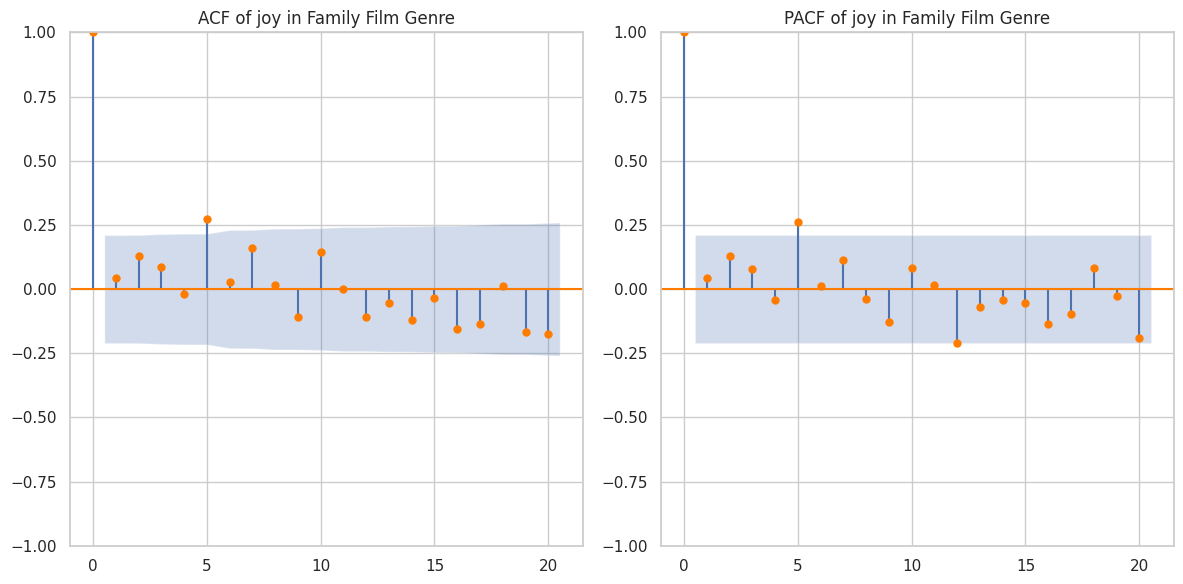

##########################################
 Performing Box-Jenkins Procedure for surprise in Family Film Genre
ADF Statistic: -8.473655078539828
p-value: 1.4548682542497265e-13
Best ARIMA Order for surprise in Family Film Genre: (1, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Family Film Genre
ADF Statistic: -4.269389640840537
p-value: 0.0005016691687662536
Best ARIMA Order for joy in Family Film Genre: (3, 0, 1)


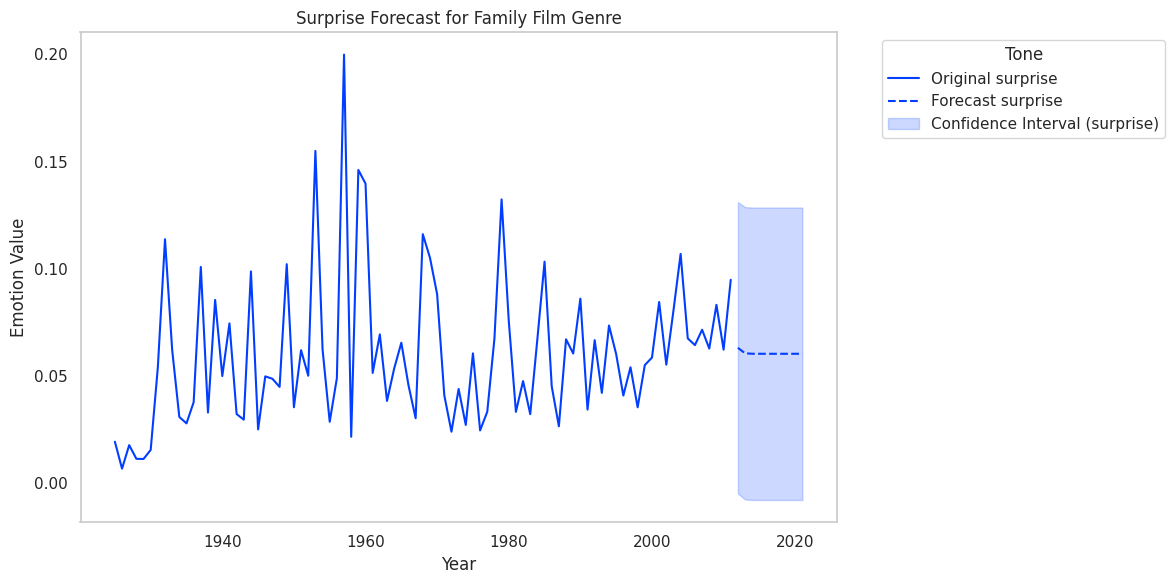

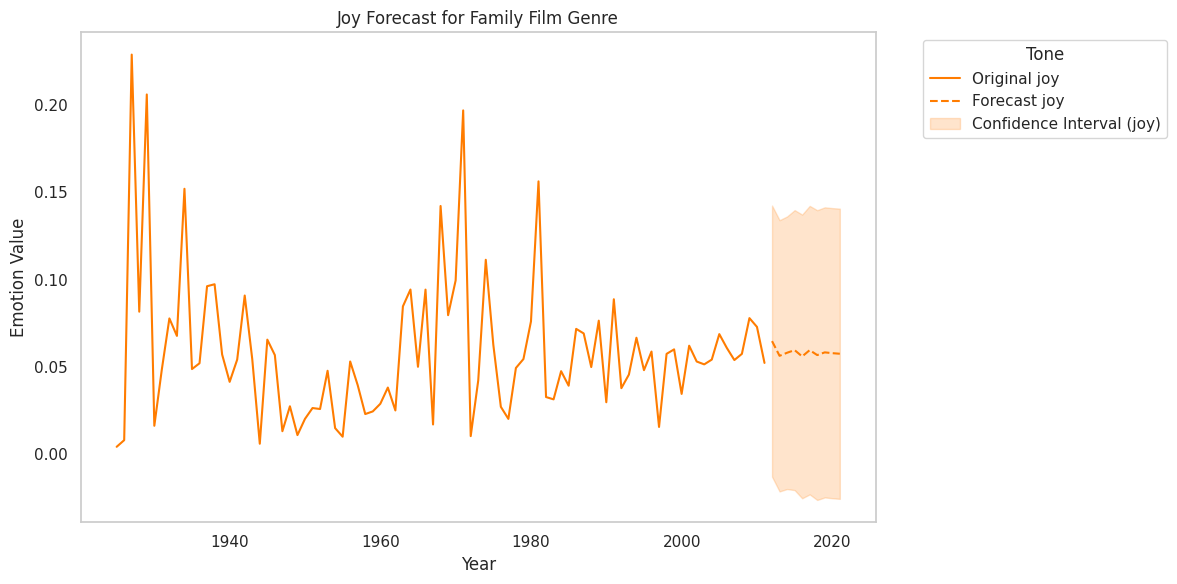

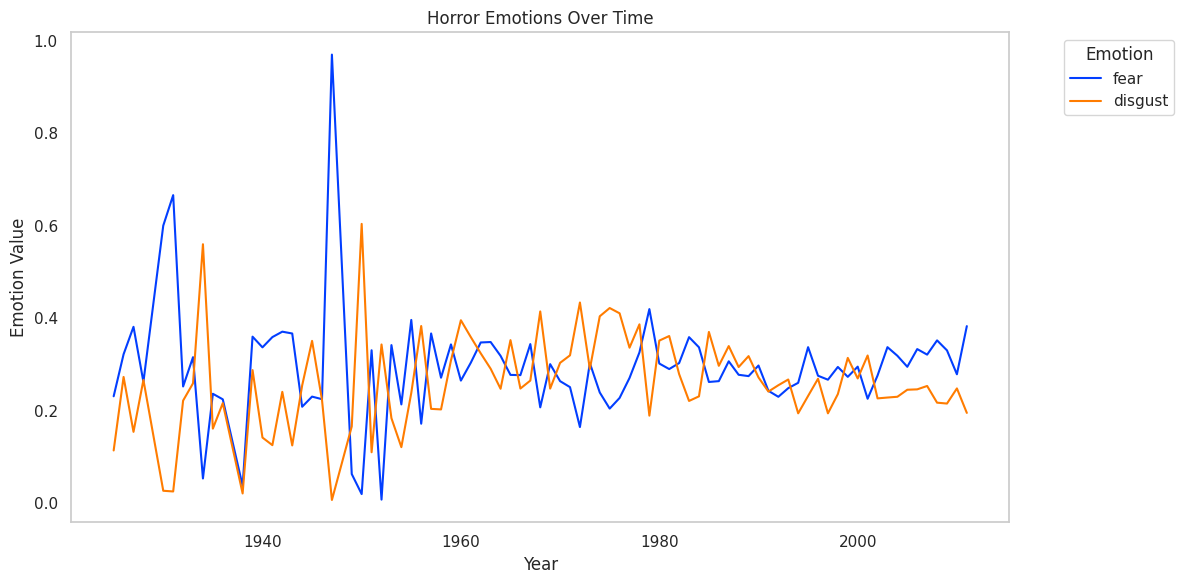

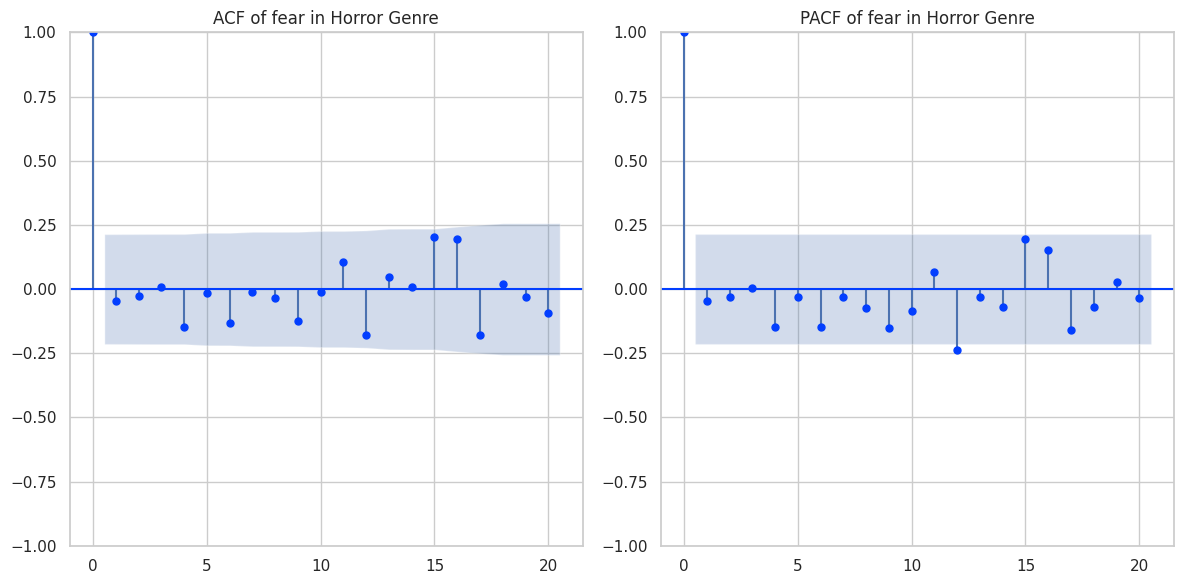

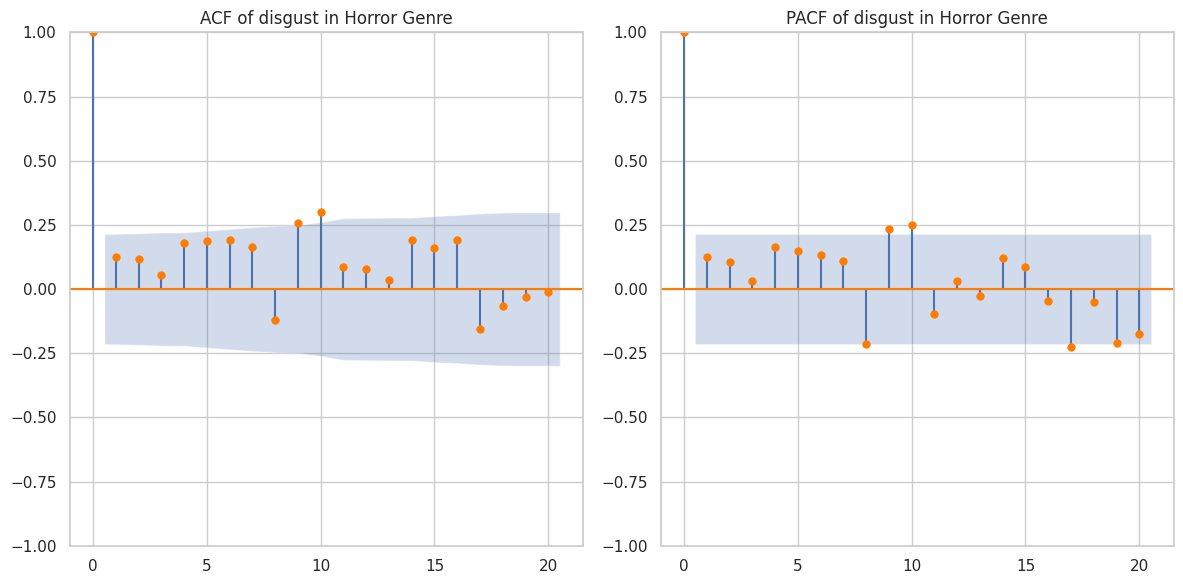

##########################################
 Performing Box-Jenkins Procedure for fear in Horror Genre
ADF Statistic: -9.4282225003187
p-value: 5.275646181909373e-16
Best ARIMA Order for fear in Horror Genre: (1, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in Horror Genre
ADF Statistic: -1.0727583574924515
p-value: 0.7258124187609366
The series is not stationary and needs to be differenced.
Best ARIMA Order for disgust in Horror Genre: (1, 1, 1)


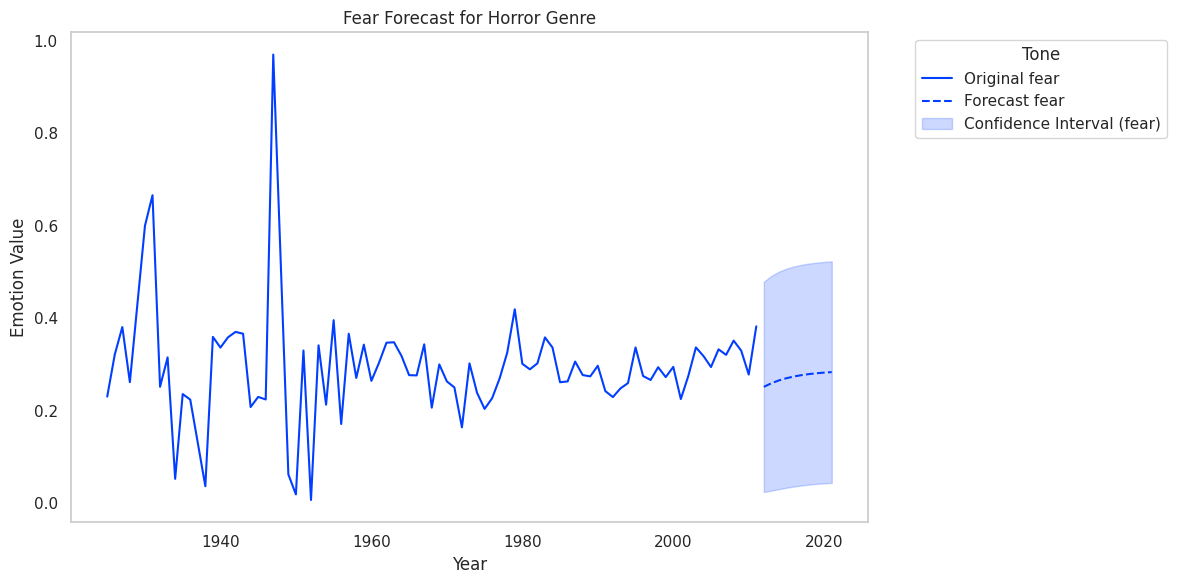

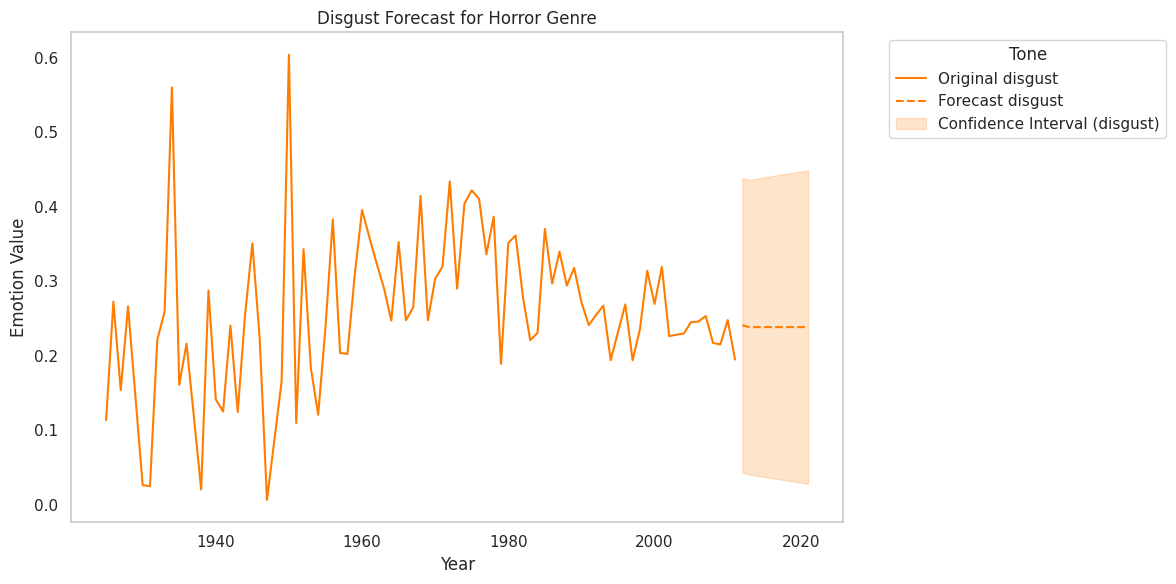

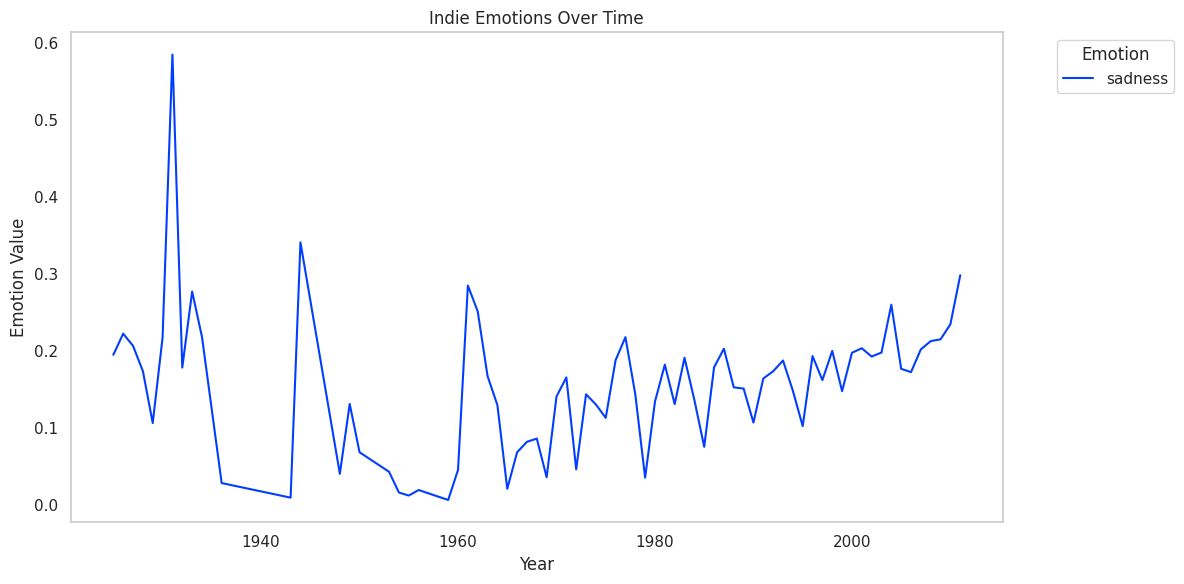

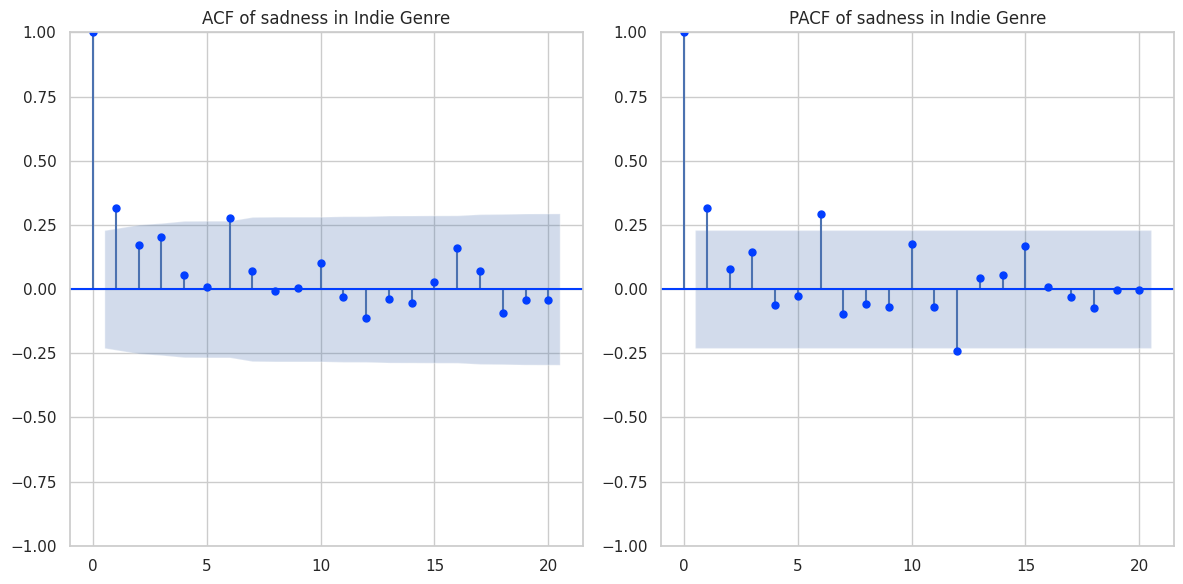

##########################################
 Performing Box-Jenkins Procedure for sadness in Indie Genre
ADF Statistic: -4.290242861905465
p-value: 0.00046181560314714716
Best ARIMA Order for sadness in Indie Genre: (3, 0, 2)


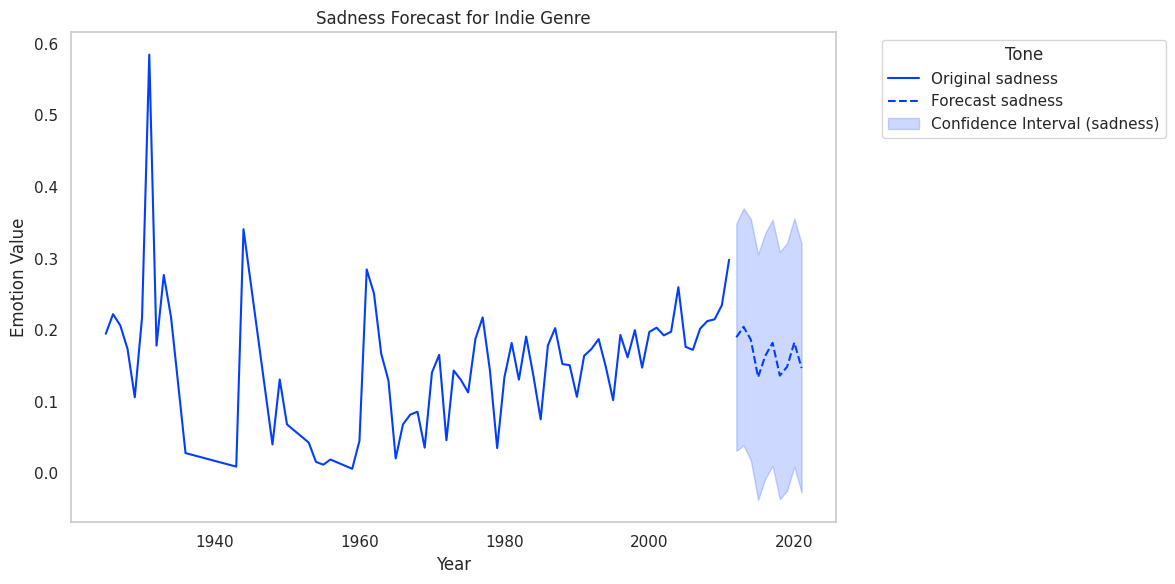

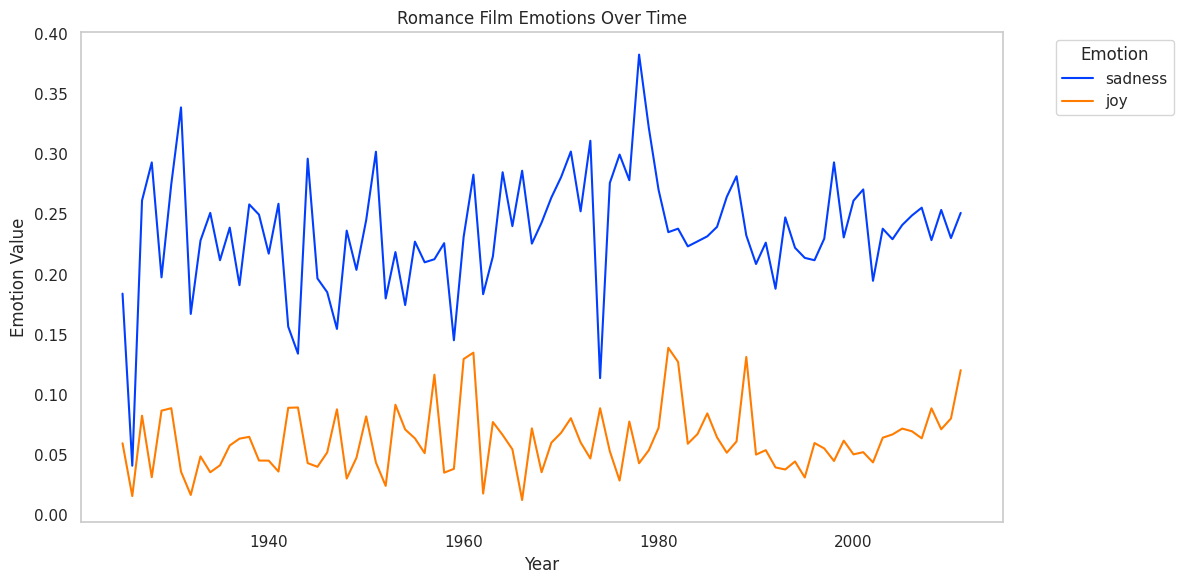

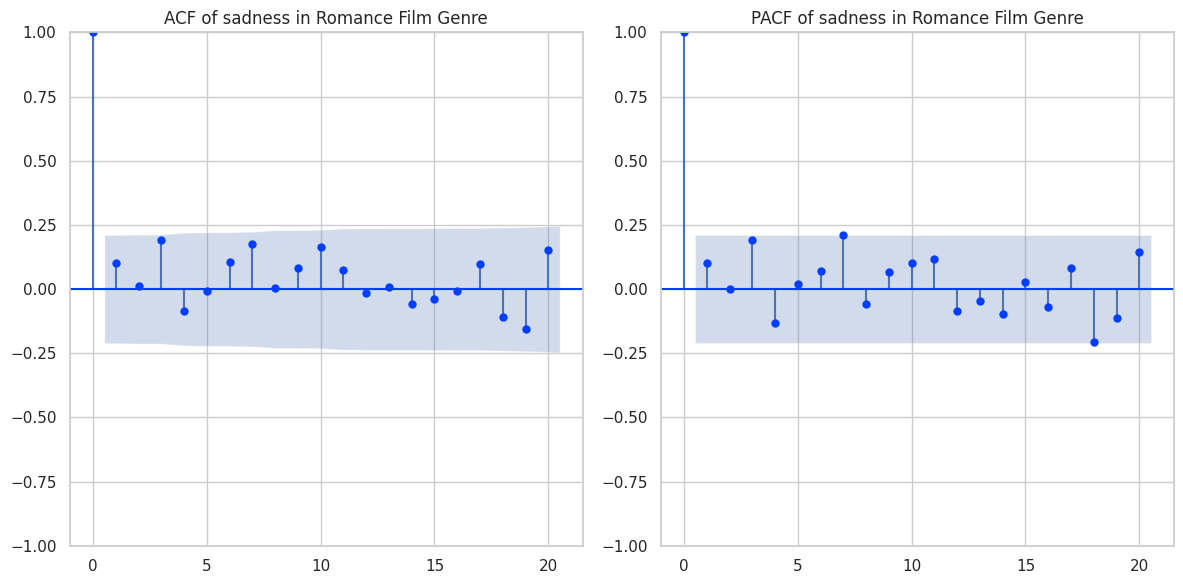

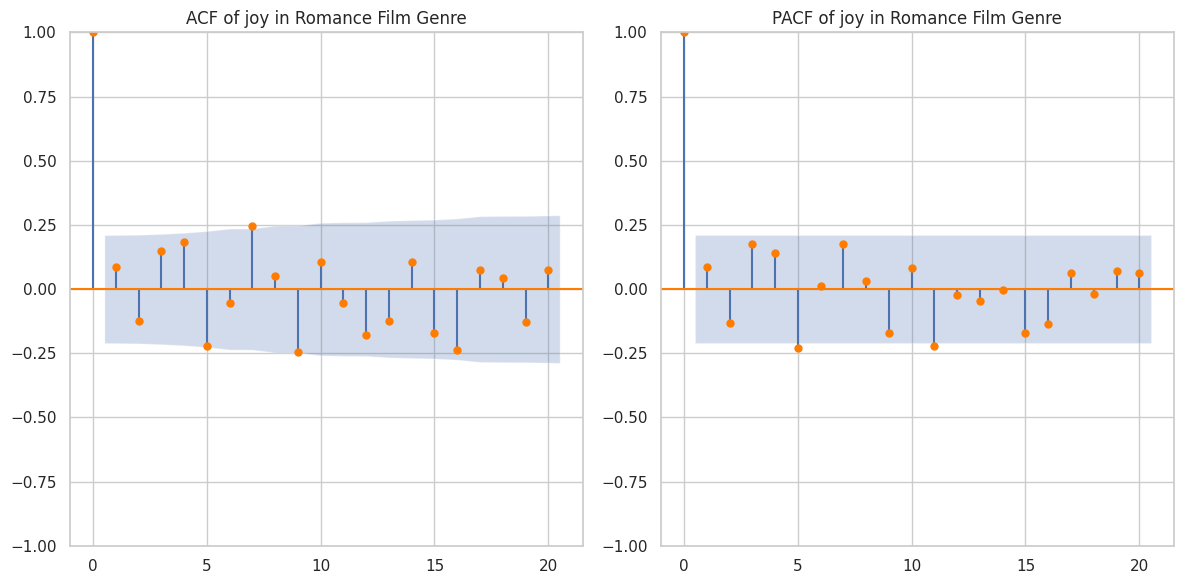

##########################################
 Performing Box-Jenkins Procedure for sadness in Romance Film Genre
ADF Statistic: -8.329339184936085
p-value: 3.401902104800243e-13
Best ARIMA Order for sadness in Romance Film Genre: (1, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for joy in Romance Film Genre
ADF Statistic: -2.8643682243500916
p-value: 0.04965115747924049
Best ARIMA Order for joy in Romance Film Genre: (2, 0, 2)


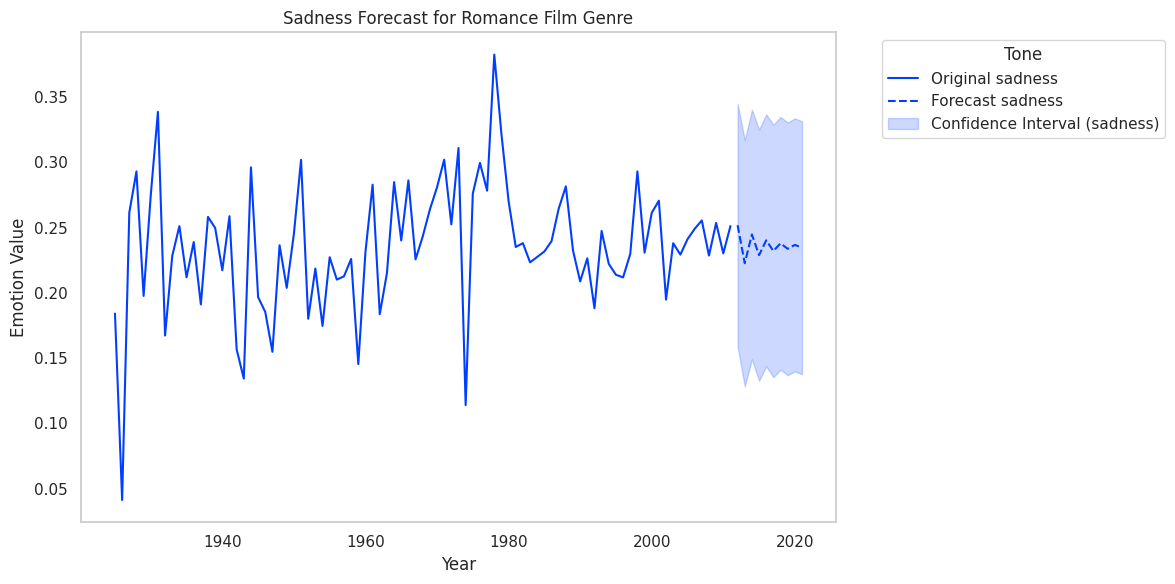

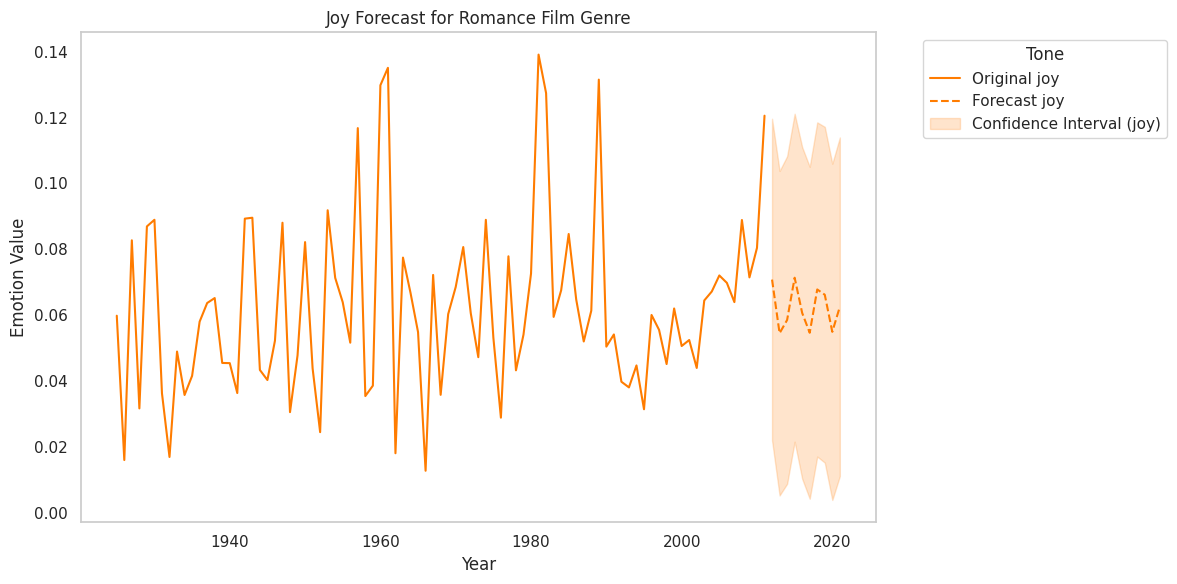

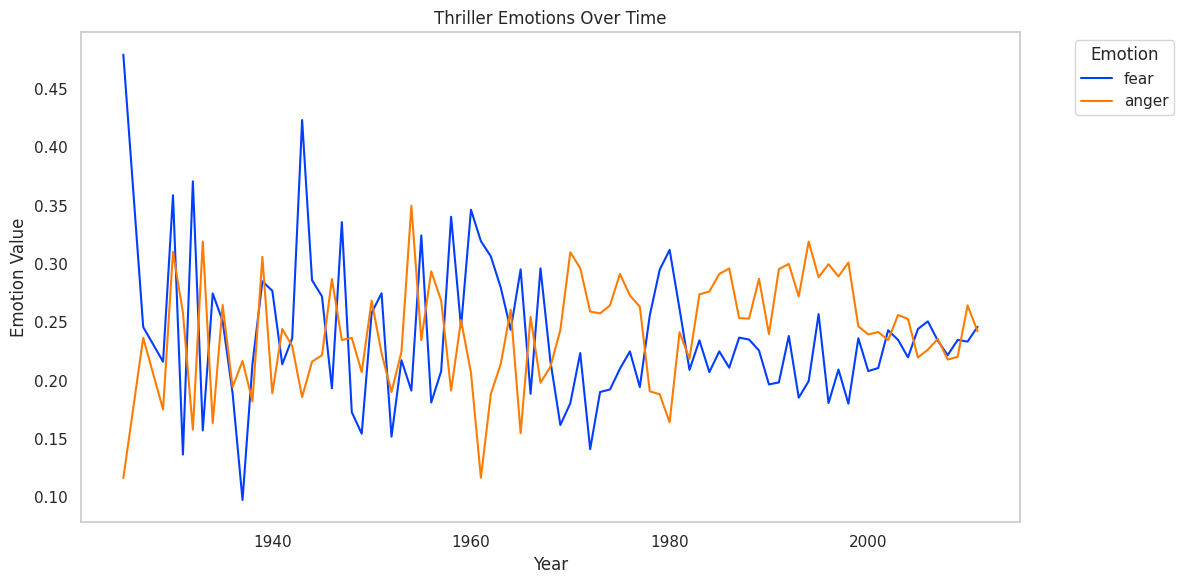

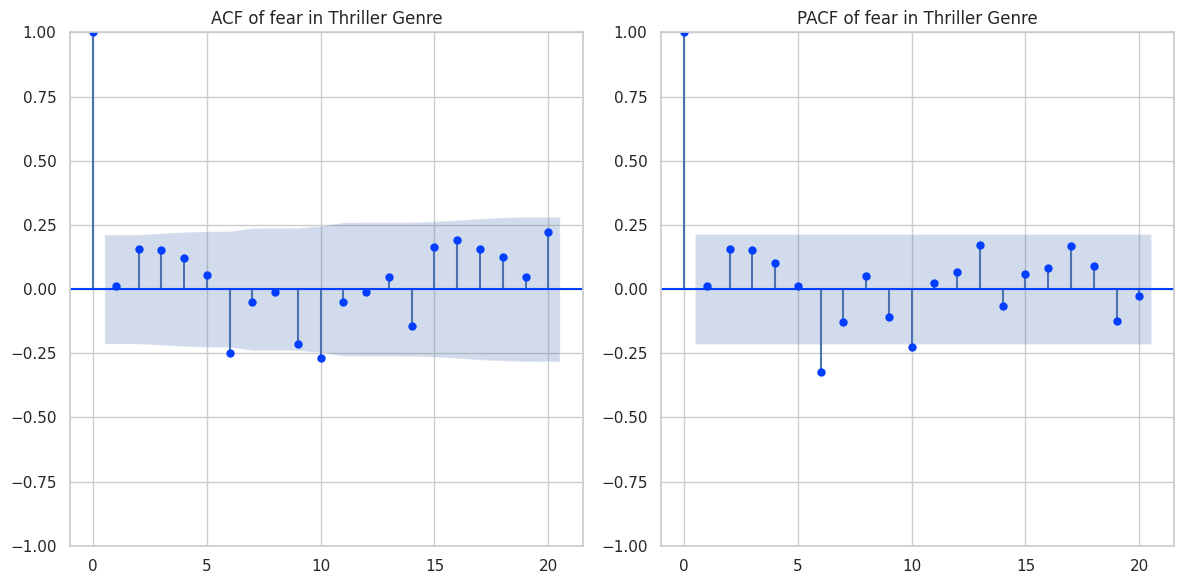

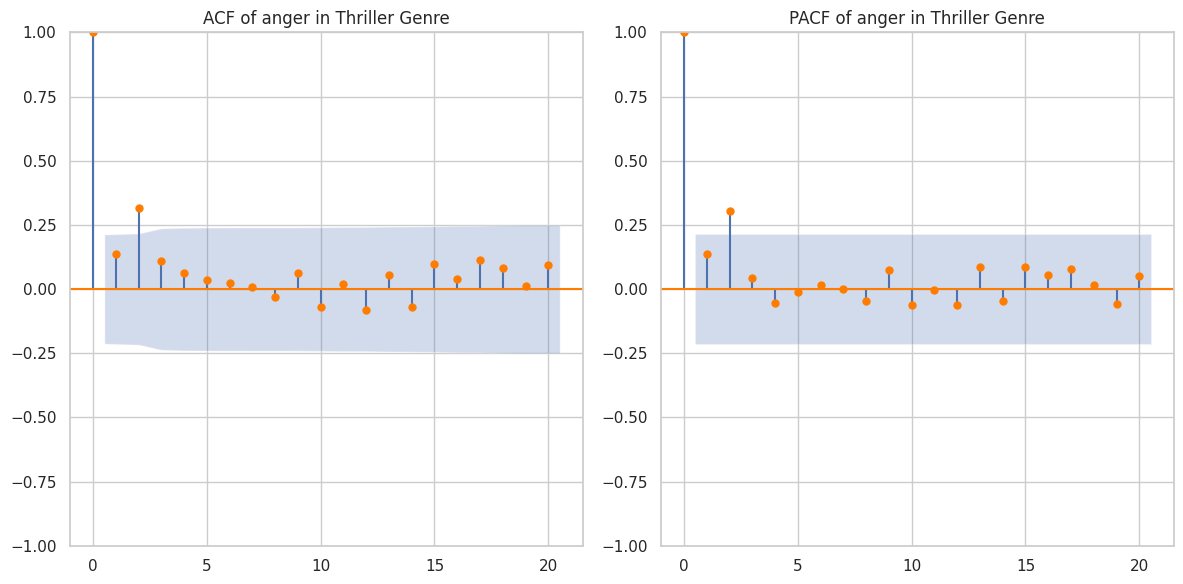

##########################################
 Performing Box-Jenkins Procedure for fear in Thriller Genre
ADF Statistic: -4.380649133353832
p-value: 0.00032113466060935774
Best ARIMA Order for fear in Thriller Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Thriller Genre
ADF Statistic: -4.398199262173892
p-value: 0.00029901836591140053
Best ARIMA Order for anger in Thriller Genre: (2, 0, 0)


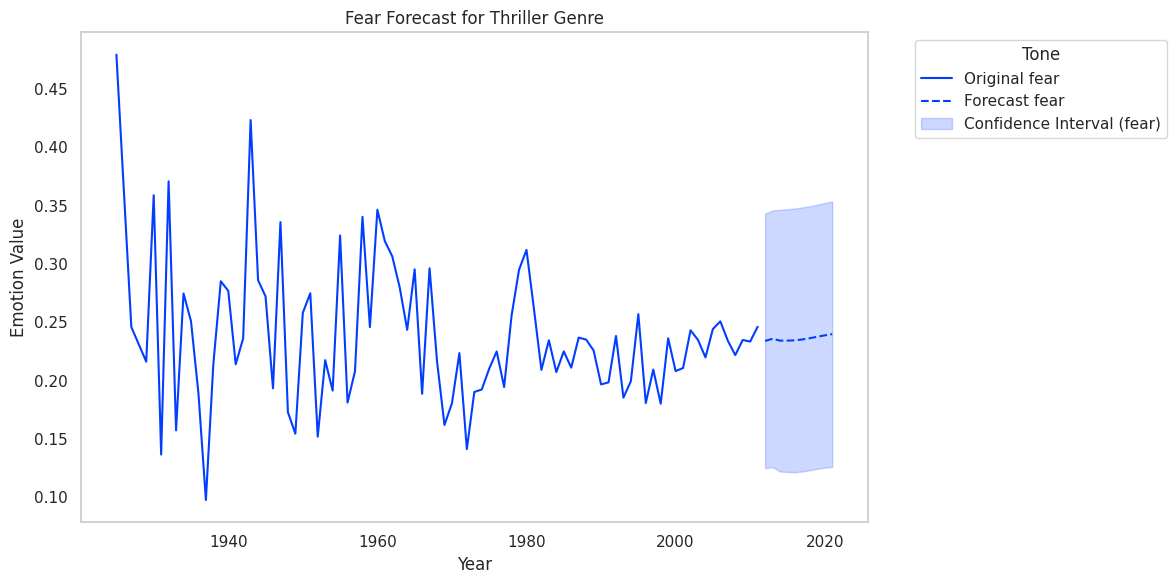

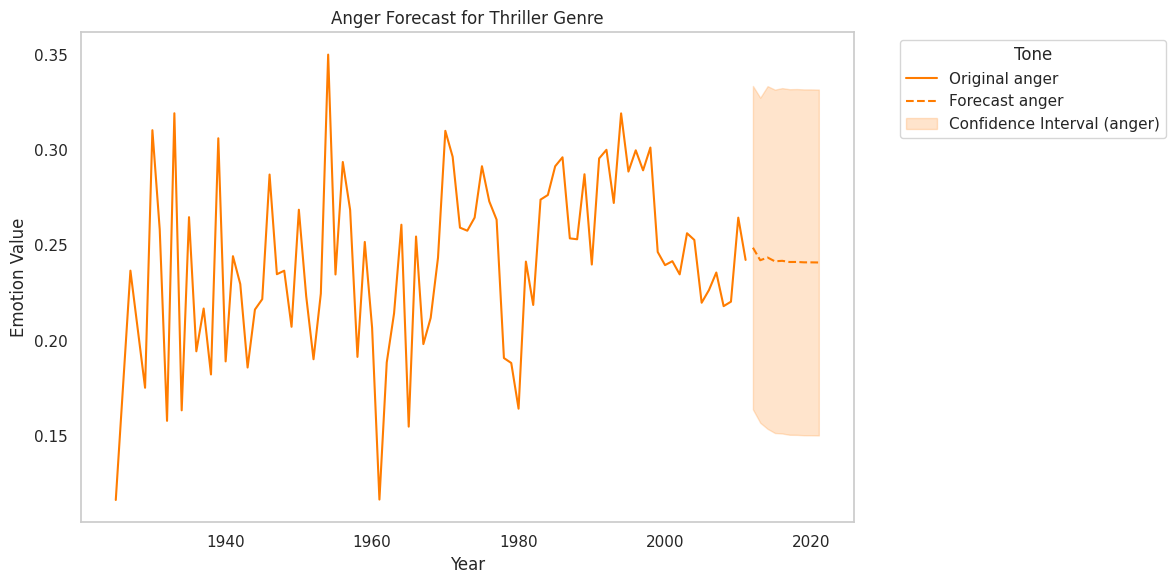

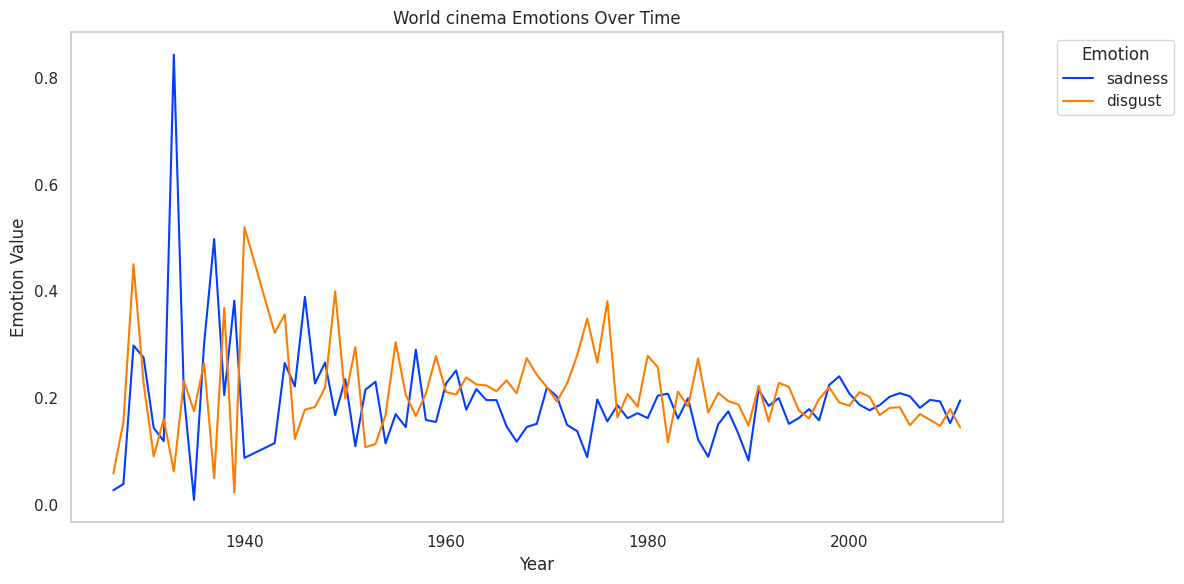

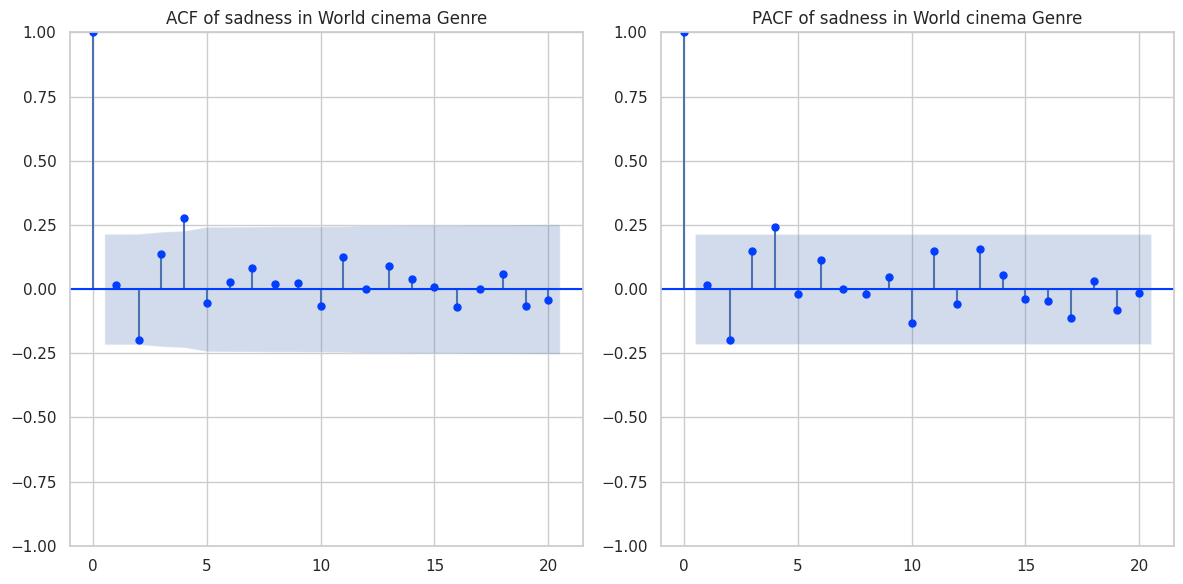

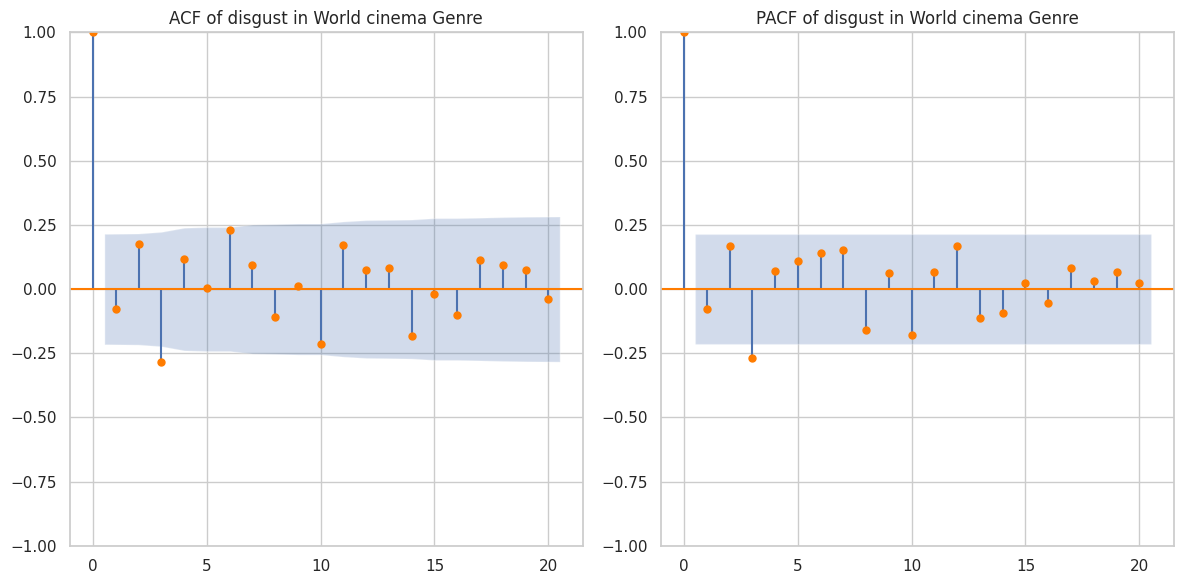

##########################################
 Performing Box-Jenkins Procedure for sadness in World cinema Genre
ADF Statistic: -3.6754907309791047
p-value: 0.004471408710045529
Best ARIMA Order for sadness in World cinema Genre: (3, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in World cinema Genre
ADF Statistic: -5.958683939337718
p-value: 2.0637716996936205e-07
Best ARIMA Order for disgust in World cinema Genre: (3, 0, 0)


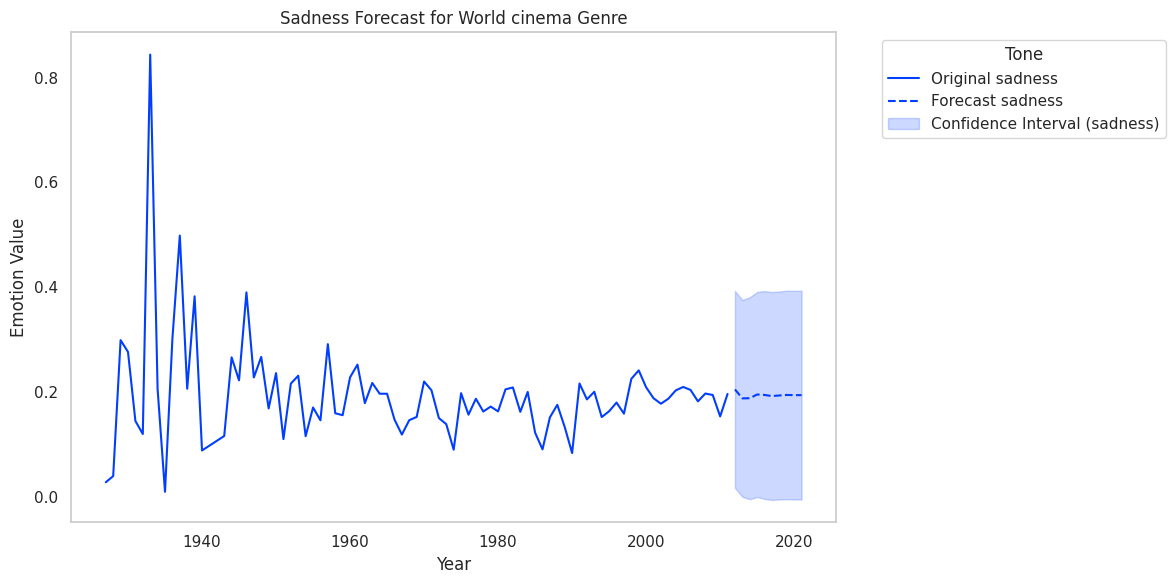

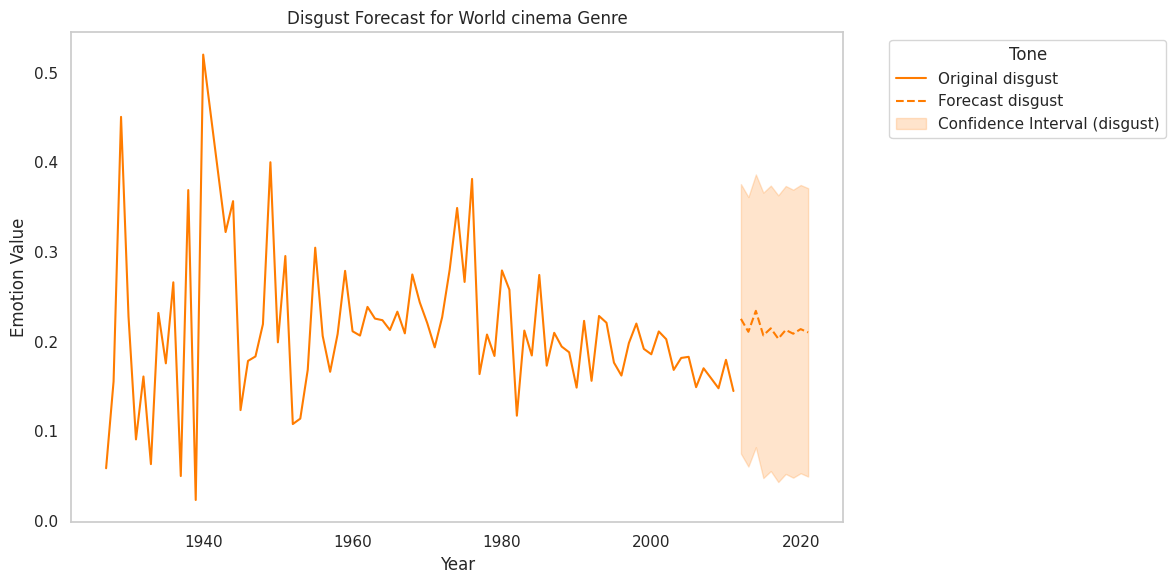

In [24]:
genre_timeseries_analysis(genre_timeseries_df, genres_emotions_mapping)


## Interpretation of Results: Time Series Analysis and Forecasting Example

### Example: The Evolution of "Anger" in Action Movies

The emotion **"anger"** in Action movies was modeled using an **ARIMA(3, 1, 1)** configuration.

### Formula for Predicting "Anger" Emotion

The ARIMA(3, 1, 1) model is represented as:

1. **Differenced Series**: The first differencing order ($d = 1$) transforms the original series, $X_t$, into:
   $$
   Y_t = X_t - X_{t-1}
   $$

2. **ARIMA Model Equation**:
   $$
   Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \phi_3 Y_{t-3} + \theta_1 \epsilon_{t-1} + \epsilon_t
   $$
   Where:
   - $\phi_1, \phi_2, \phi_3$: Coefficients for lagged values ($Y_{t-1}, Y_{t-2}, Y_{t-3}$).
   - $\theta_1$: Coefficient for the moving average term ($\epsilon_{t-1}$).
   - $\epsilon_t$: Residual error term at time $t$.

   Substituting the coefficients:
   $$
   Y_t = -0.3399 Y_{t-1} - 0.3464 Y_{t-2} - 0.3168 Y_{t-3} - 0.8444 \epsilon_{t-1} + \epsilon_t
   $$

3. **Reconstruction**: The original series $X_t$ is obtained by summing the differenced value $Y_t$ with $X_{t-1}$:
   $$
   X_t = X_{t-1} + Y_t
   $$

---

### Forecasting 10 Years into the Future

Forecasting is achieved mathematically by iterating the ARIMA equation forward in time. Here's how it works:

1. **Extrapolate the Differenced Series ($Y_t$)**:
   - Use the ARIMA equation:
     $$
     Y_t = -0.3399 Y_{t-1} - 0.3464 Y_{t-2} - 0.3168 Y_{t-3} - 0.8444 \epsilon_{t-1} + \epsilon_t
     $$
   - For future values, the residual error terms ($\epsilon_t$) are assumed to follow a white noise distribution (mean = 0, constant variance).

2. **Iterative Prediction**:
   - Start with the most recent observed values of $Y_t$, $Y_{t-1}$, $Y_{t-2}$, and $\epsilon_{t-1}$.
   - Predict $Y_t+1$, then use it to predict $Y_t+2$, and so on.

3. **Reconstruct the Original Series ($X_t$)**:
   - Each forecasted value of $Y_t$ is added cumulatively to the last known value of $X_t$:
     $$
     X_{t+1} = X_t + Y_{t+1}
     $$
     $$
     X_{t+2} = X_{t+1} + Y_{t+2}
     $$

By iterating this process for 10 steps, we generated predictions for the next 10 years of "anger" scores in Action movies.

---

### Interpretation of the Forecast

From the model:
- The **AR(3)** component suggests that the emotion "anger" is heavily influenced by its values up to three years prior.
- The **MA(1)** component accounts for short-term shocks, smoothing out noise in the predictions.
- The **differencing** captures the long-term trend, ensuring the model predicts a stationary evolution of "anger" over time.

The forecast provides a statistically sound projection of how "anger" might continue to evolve in Action movies, with confidence intervals capturing the uncertainty around the predictions.

Very interesting! Let's now look if there is a connection between the emotional tone of a movie and the components of the movie like its language or the actor traits of involved actors. First we will look at the question:

# How Does the Emotional Tone of Films Influence the Selection of Actor Traits, Such as Age and Gender?

#### To investigate the relationship between the emotional tone of films and the selection of actor traits, specifically **average age** and **gender proportion** of involved actors, we performed a regression analysis.

In [25]:
character_df = get_character_df(df, EMOTIONS)

Number of rows before droping:  81771
Number of rows after droping:  30175
[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37.78852253927453, 30.0, 37.78852253927453, 37.78852253927453, 42.0, 57.0, 37.78852253927453, 66.0, 47.0, 58.0]
['F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F']
[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Age entries: 17, gender entries: 17, gender flag entries: 17
<class 'dict'>


The emotions sum up to one, so there is multicoloniartiy between the variables. Therefore to create a meaningful analysis we have to drop a class. Let's first do a quick correlation analysis to see if there is one emotion which is strongly correlated to others, so we can drop it.

In [26]:
# Filter
emotion_corr_df = character_df[EMOTIONS]

# Do correlation analysis
emotion_corr_df.corr()

disgust      fear     anger   neutral   sadness  surprise       joy
disgust   1.000000 -0.224354 -0.055964 -0.211494 -0.242464 -0.185363 -0.176413
fear     -0.224354  1.000000 -0.206568 -0.268345 -0.234403 -0.056546 -0.162655
anger    -0.055964 -0.206568  1.000000 -0.291715 -0.273985 -0.157576 -0.204393
neutral  -0.211494 -0.268345 -0.291715  1.000000 -0.210060 -0.032004  0.100285
sadness  -0.242464 -0.234403 -0.273985 -0.210060  1.000000 -0.092891 -0.075215
surprise -0.185363 -0.056546 -0.157576 -0.032004 -0.092891  1.000000 -0.011244
joy      -0.176413 -0.162655 -0.204393  0.100285 -0.075215 -0.011244  1.000000

There doesn't seem to be a clear candidate, so we will drop the semantically least interesting emotion: neutral.

In [27]:
character_df = character_df.drop(labels=['neutral'], axis=1)

## Regression Analysis: Methodology

### Dropping the "Neutral" Emotion

Since the emotional tones are represented as proportions (e.g., the sum of all emotion scores for a film equals 1), including all emotions in the regression model would lead to multicollinearity. This occurs because the proportions are interdependent, violating the assumption of independent predictors in regression.

To address this:
- We dropped the **"neutral"** emotion, as it was deemed the least interesting in the context of our analysis.
- This ensured that the regression model could estimate the effects of the remaining emotions without redundancy.

### Dependent Variables
We performed two separate regression analyses:
1. **Average Age of Actors in a Film**: The mean age of all actors involved in a film.
2. **Average Gender Proportion**: The proportion of female actors in a film, calculated as:
   $$
   \text{Gender Proportion} = \frac{\text{Number of Female Actors}}{\text{Total Number of Actors}}
   $$

### Independent Variables
The independent variables were the remaining emotional tones after dropping "neutral":
- **Disgust**, **Fear**, **Anger**, **Sadness**, **Joy**, and **Surprise**.

### Regression Model
For each dependent variable, we used the following multiple linear regression model:
$$
Y_i = \beta_0 + \beta_1 E_{\text{disgust},i} + \beta_2 E_{\text{fear},i} + \beta_3 E_{\text{anger},i} + \beta_4 E_{\text{sadness},i} + \beta_5 E_{\text{joy},i} + \beta_6 E_{\text{surprise},i} + \epsilon_i
$$
Where:
- $Y_i$: Dependent variable (average age or gender proportion) for film $i$.
- $E_{\text{emotion},i}$: Proportion of the specified emotion in film $i$.
- $\beta_0$: Intercept term.
- $\beta_1, \beta_2, \dots, \beta_6$: Coefficients representing the influence of each emotion.
- $\epsilon_i$: Residual error term.

We will now regress AvgAge and AvgGender using all the emotions leaving out the 'neutral' tone for multicollinearity purpose.

The effect of the neutral emotion is therefore represented by the intercept.
The coeffients of the remaining tones will represent the effect of a 1-unit increase in the proportion of that tone relative to the excluded category (neutral) on the dependet variable, while holding the total sum of probabilities fixed at 1.

In [28]:
# Model for average age
age_res = character_emotion_regression('AgeAvg', character_df)
print(age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     15.27
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           1.48e-17
Time:                        05:20:54   Log-Likelihood:            -1.0081e+05
No. Observations:               30175   AIC:                         2.016e+05
Df Residuals:                   30168   BIC:                         2.017e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.5932      0.153    252.223      0.0

## Insights from the Regression Analysis: Average Age of Actors

We observe that all emotional tones except **"fear"** are statistically significant predictors of the average age of actors. However, the $R^2$ metric is very low (0.03), indicating that the model does not explain much of the variance in the dependent variable. This suggests that knowing only the emotional scores of a film is insufficient for efficiently predicting the average age of actors. Incorporating additional predictors, such as **genres**, **languages**, or **movie character traits**, could improve the model's explanatory power.

Despite the low $R^2$, the coefficients provide meaningful insights into the influence of emotional tones:
- All coefficients are **negative and significant**, indicating that an increase in the proportion of these emotions relative to "neutral" is associated with a decrease in the average age of the cast. 
- This finding suggests that films with stronger emotional tones tend to feature younger actors on average.
- The magnitude of the coefficients reveals differences between emotions:
  - The coefficients for **"joy," "sadness,"** and **"disgust"** are noticeably higher (in absolute terms) compared to other emotions, indicating a stronger influence on reducing the average age of the cast.
  - Emotions such as **"anger"** and **"surprise"** have smaller (though still negative) effects, implying a subtler relationship with cast age.

In [29]:
# Model for average gender
age_res = character_emotion_regression('GenderAvg', character_df)
print(age_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     89.66
Date:                Sat, 21 Dec 2024   Prob (F-statistic):          5.67e-112
Time:                        05:20:54   Log-Likelihood:                 3147.5
No. Observations:               30175   AIC:                            -6281.
Df Residuals:                   30168   BIC:                            -6223.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3046      0.005     62.415      0.0

## Insights from the Regression Analysis: Average Gender Proportion

In the regression analysis for average gender proportion, every coefficient is statistically significant. However, the $R^2$ metric is very low (0.018), similar to the previous analysis. This result suggests that we need additional predictors to effectively explain and model the gender composition of a film's cast. Variables like **genres**, **languages**, or **character traits** could enhance the model's performance.

Despite the low $R^2$, the coefficients provide insights into how emotional tones influence the gender composition of the cast:
- **"Anger"** has a **negative coefficient**, indicating that an increase in the proportion of this emotion relative to "neutral" decreases the proportion of female actors in the cast.
- All other emotional tones have **positive coefficients**, suggesting that increases in these emotions' proportions compared to "neutral" are associated with higher proportions of female actors in the cast.
  - This reflects potential thematic connections between specific emotions and gender representation in storytelling.

Interesting! So even though we can't explain the average age and gender of actors purely based on emotions, what is expected, we still see how emotions influence these actor traits. Now we want to switch our focus away from the actors involved in the movie and look at the film languages. We are interested in the connection between present emotions in a movie and the languages a movie is available in. Therefore we try to answer the question:

# Does the emotional tone of films differ between movies in different languages?

#### To explore whether the emotional tone of films differs between movies in different languages, we began with a visualization analysis. 

### Initial Analysis: Identifying Prominent Languages
1. **Data Preparation**: 
   - The "Languages" column, which contains multiple languages for some films, was **exploded** to create one row per language per film.
   - This allowed us to perform an accurate value count of the occurrences of each language.

2. **Visualizing Language Distribution**: 
   - To understand the prominence of various languages, we created a **pie chart** showcasing their relative proportions in the dataset.

In [30]:
df_languages = df.copy()

In [31]:
# We were getting some errors printing languages and seems there are some invalid unicode characters
df_languages["Languages"] = df_languages["Languages"].apply(clean_lang_list)
df_languages["distilbert_emotions"] = df_languages["distilbert_emotions"].apply(conv_to_dict)

In [32]:
no_lang_count = len(df_languages[df_languages["Languages"].apply(lambda x: len(x) == 0)])
print(f"Number of movies with no language: {no_lang_count}")

# Percentage of movies with no language
print(f"Percentage of movies with no language: {no_lang_count / len(df_languages) * 100:.2f}%")

Number of movies with no language: 13868
Percentage of movies with no language: 16.96%


In [33]:
# Drop all movies that don't have a labelled language
df_languages[df_languages["Languages"].apply(lambda x: len(x) < 0)]

Empty DataFrame
Columns: [WikiID, FreebaseID, Name, ReleaseDate, Runtime, Languages_tuple, Countries_tuples, Genres_tuples, Languages, Countries, Genres, Plot, merge_year, nrclex_emotions, roberta_emotions, distilbert_emotions, CharacterName, ActorAge, ActorGender, ActorBirthDate, ActorGenderFlag, merge_title, movieId, title, mean_ratings, std_dev_ratings, count_ratings]
Index: []

English Language                        40914
Hindi Language                           3745
Spanish Language                         3675
French Language                          3422
Silent film                              3183
                                        ...  
Australian Aboriginal Pidgin English        1
Krio Language                               1
Tok Pisin Language                          1
Pawnee Language                             1
Kriolu                                      1
Name: Languages, Length: 206, dtype: int64


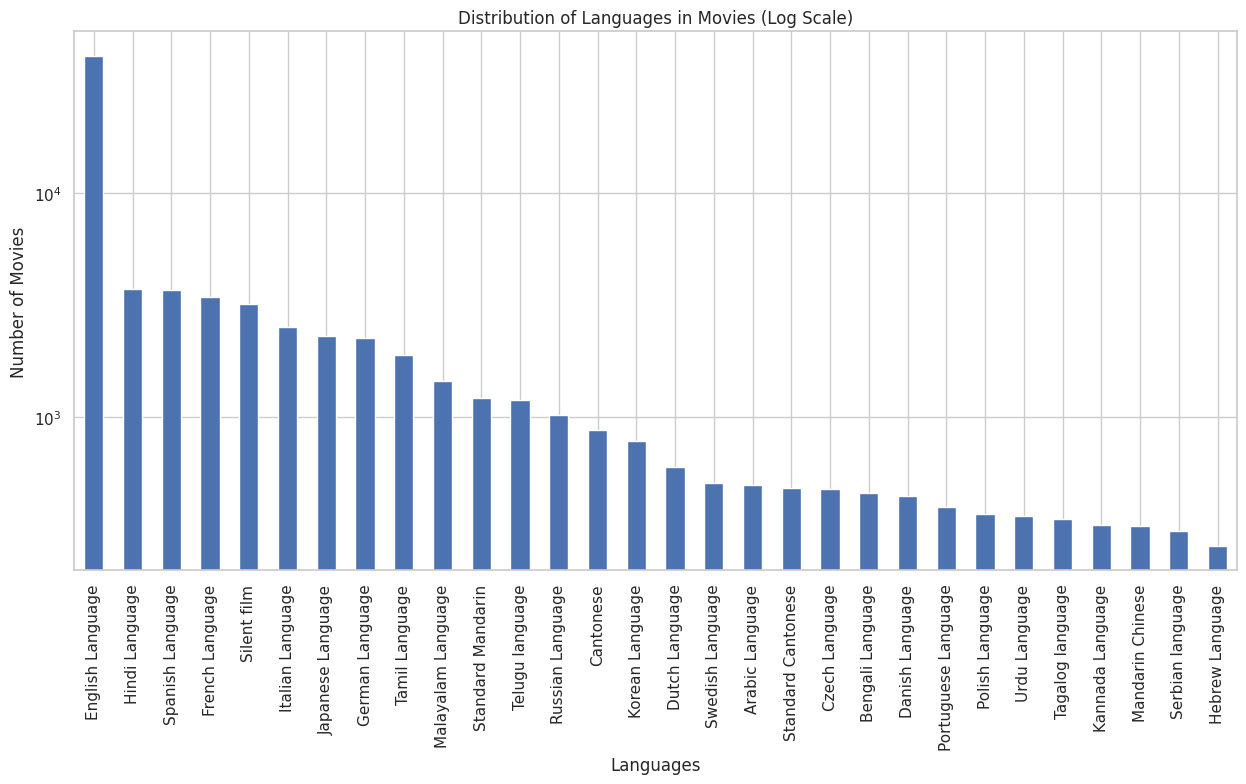

In [34]:
# Look at the distribution of languages over all movies
language_count = df_languages['Languages'].explode().value_counts()
print(language_count)
plot_language_distribution(language_count)

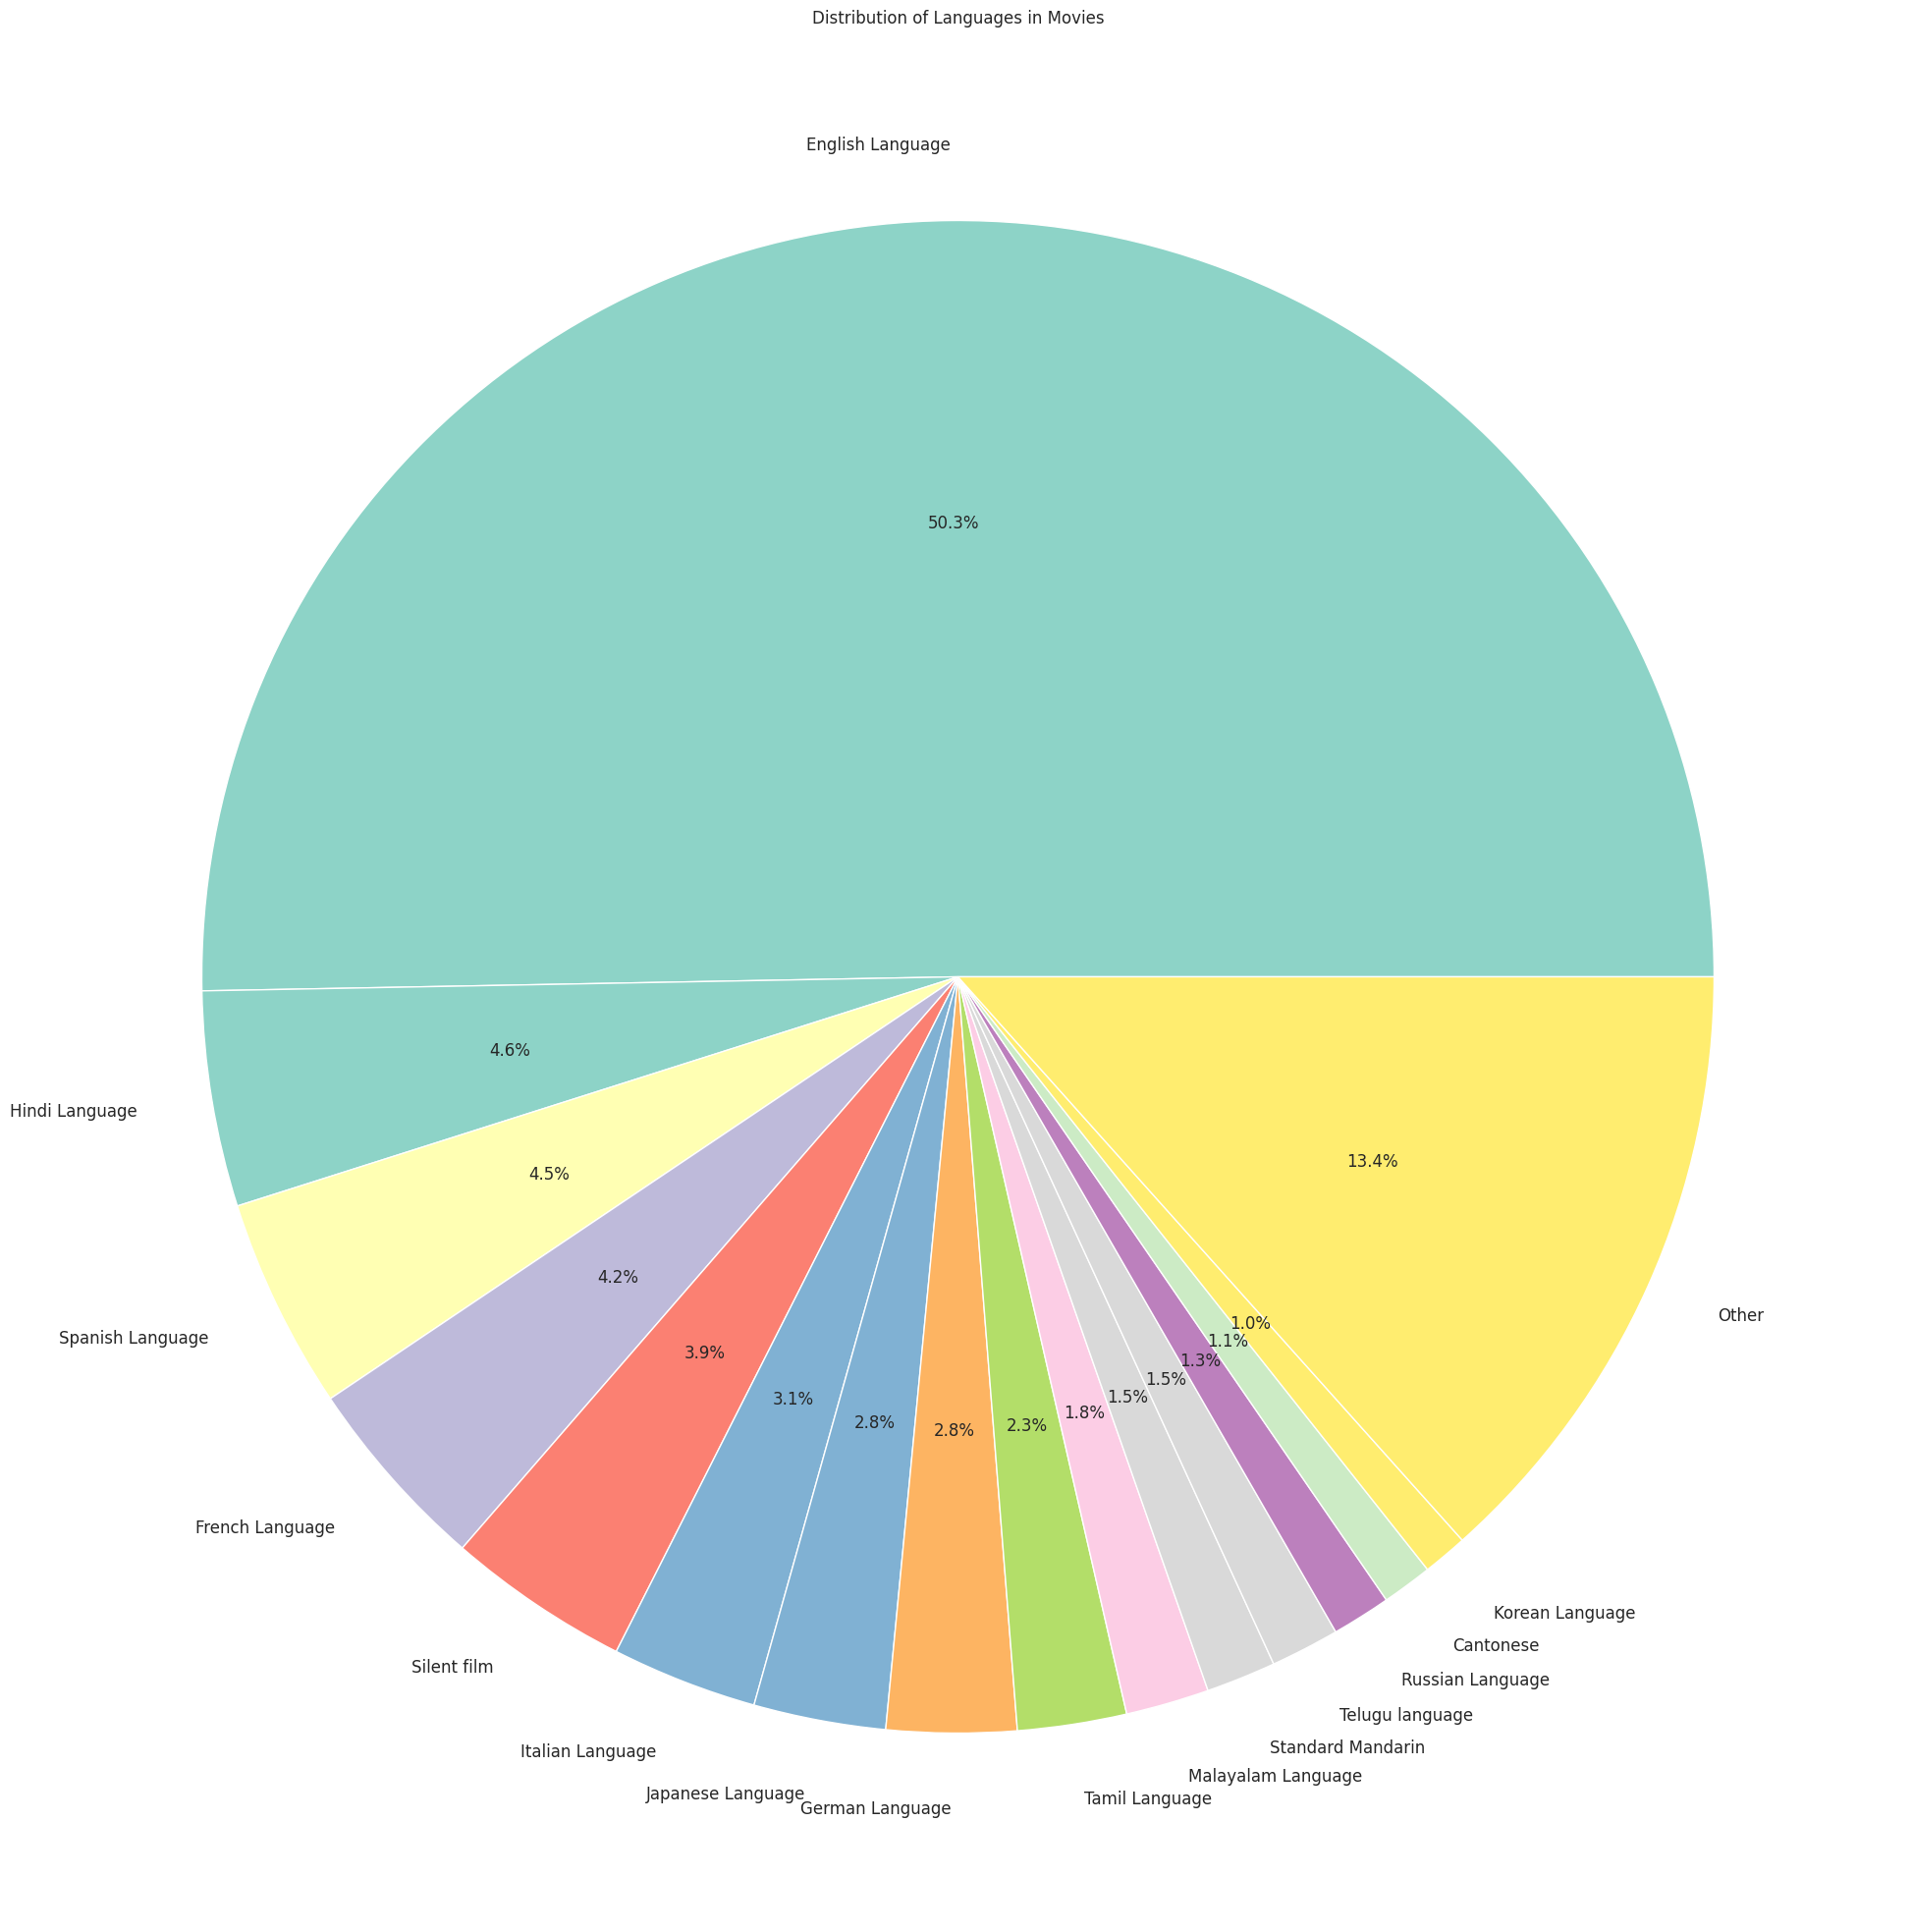

In [35]:
plot_language_pie_chart(language_count)

As an explicit choice, we will keep silent films going forward because there may be some emotional profile differences for films with NO dialogue


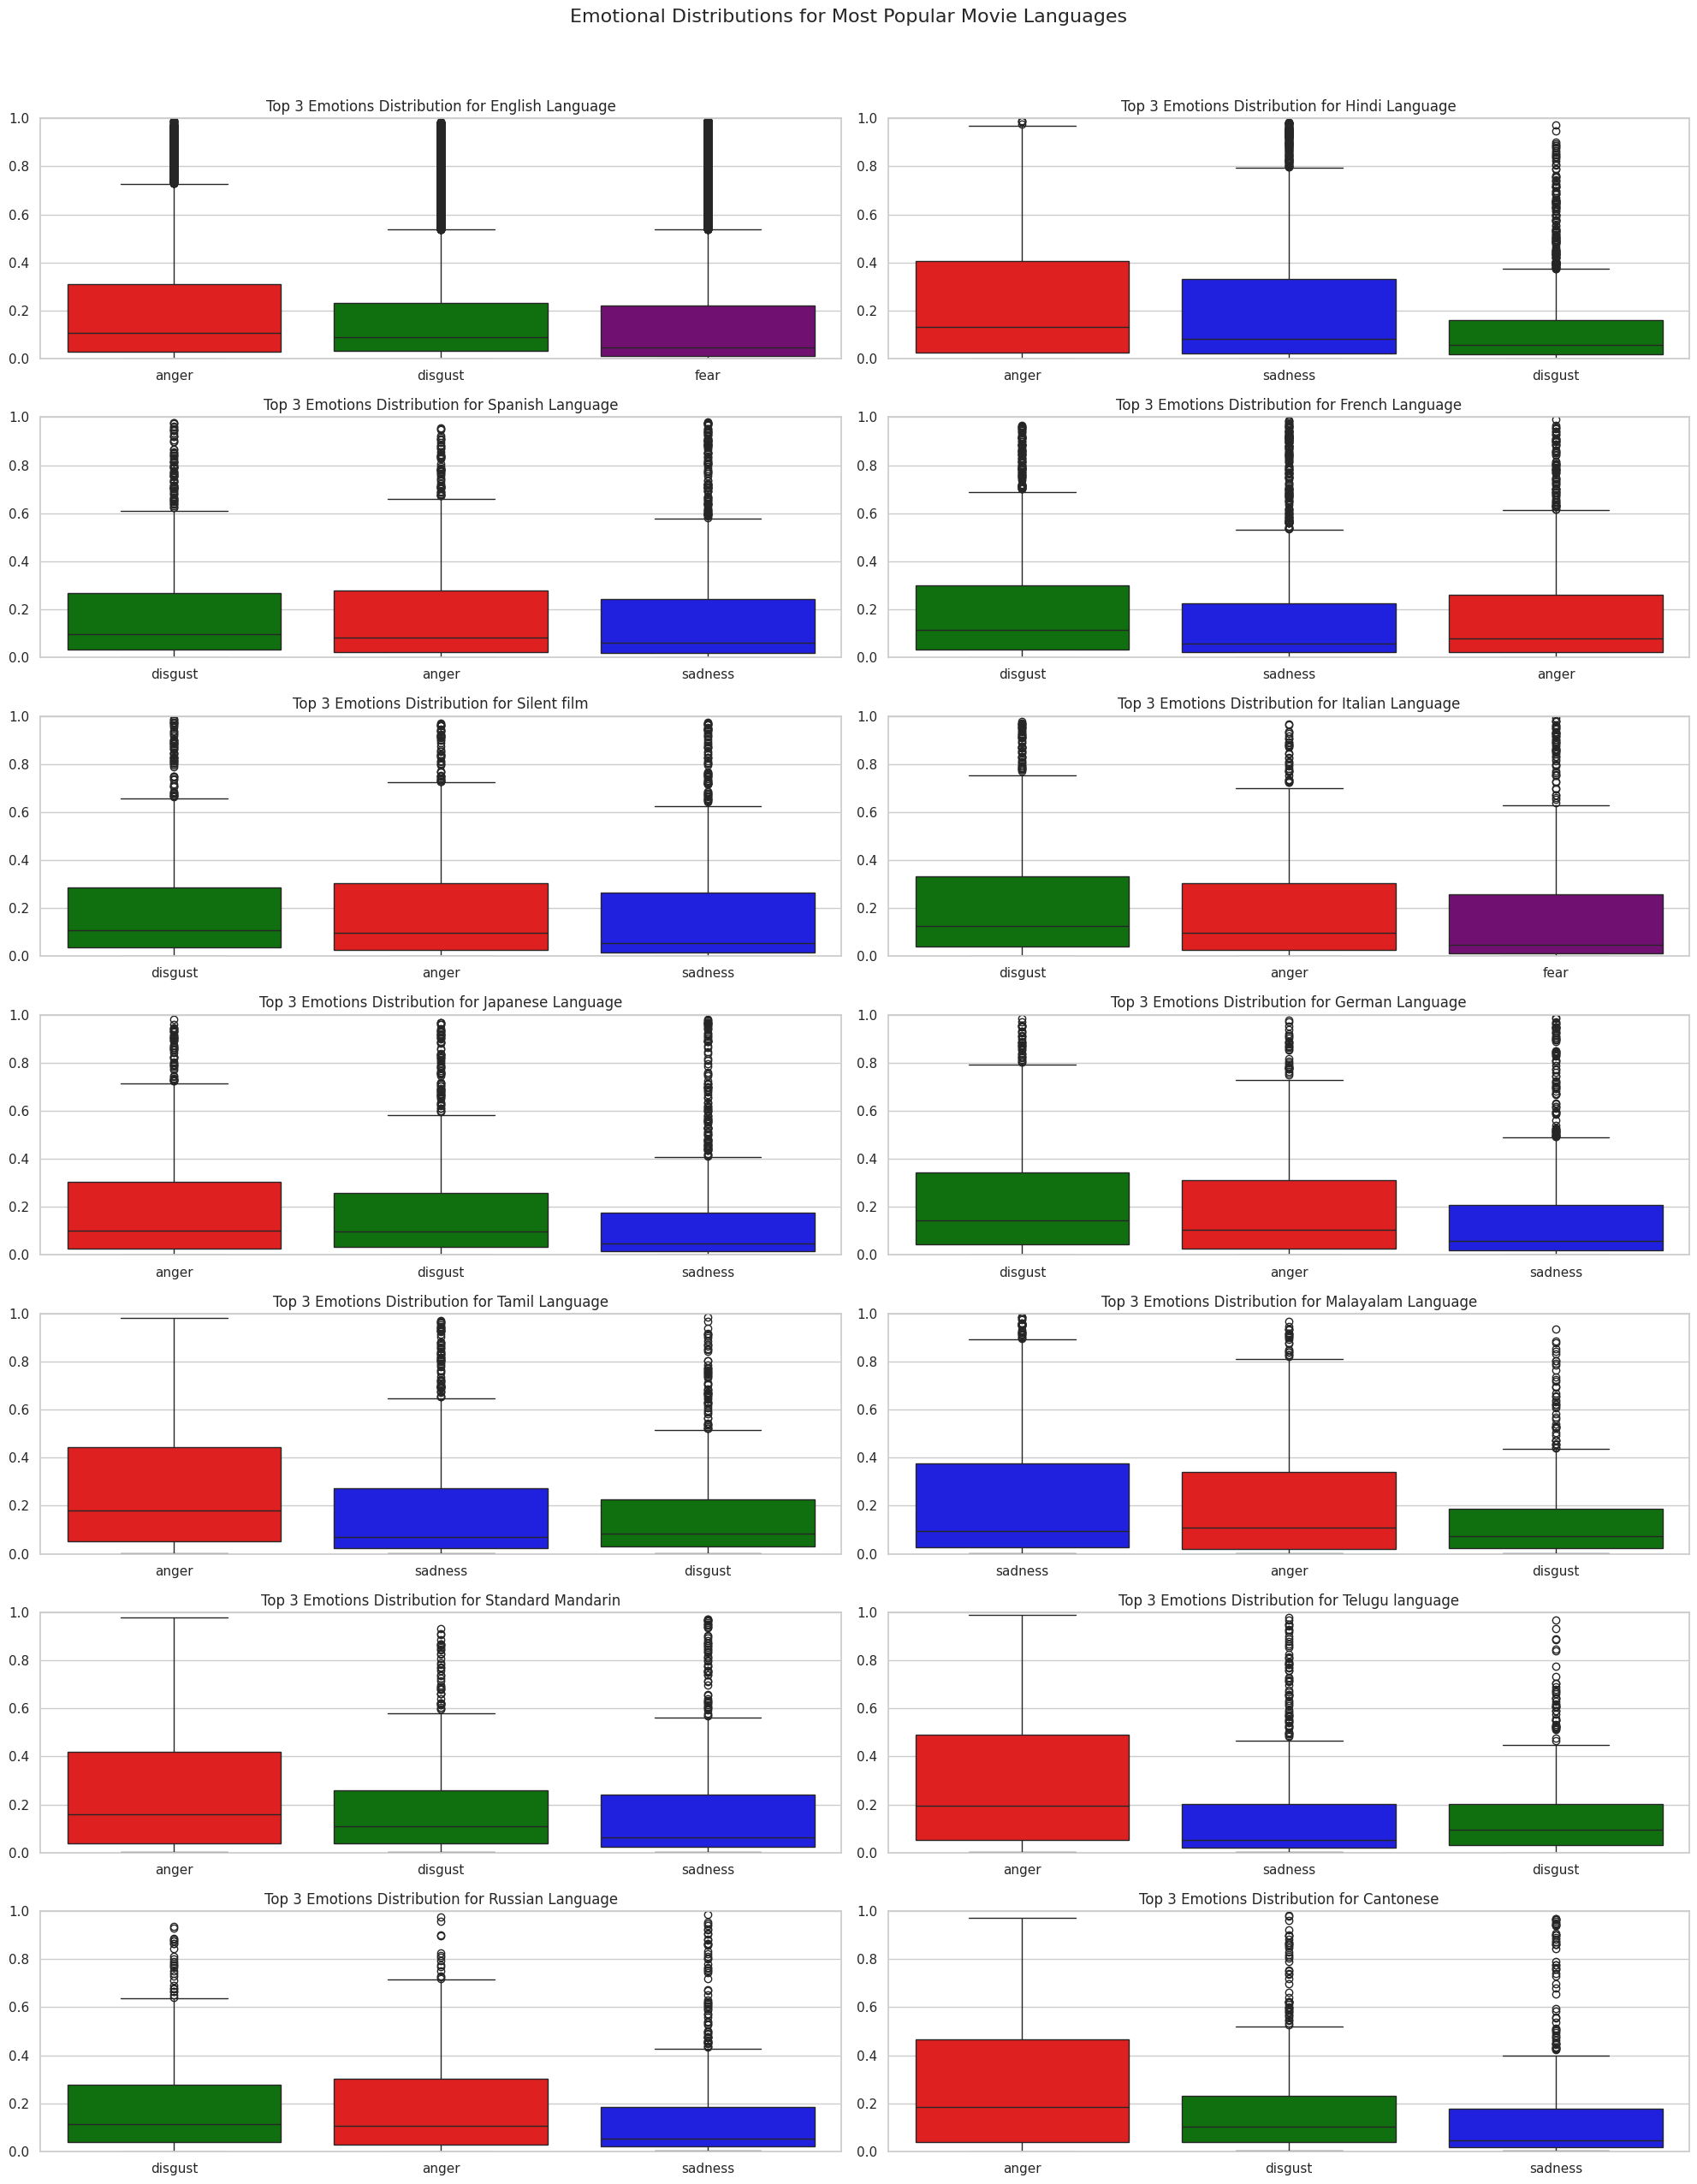

In [36]:
plot_emotion_language_distribution(df_languages, language_count)

In [37]:
REGRESSION_MODEL = "C(Languages, Treatment(reference='English Language'))"

# Prepare the data
df_analysis = prepare_data_for_analysis(df_languages, EMOTIONS)

# Run all analyses
regression_results = run_individual_regressions(df_analysis, REGRESSION_MODEL, EMOTIONS)

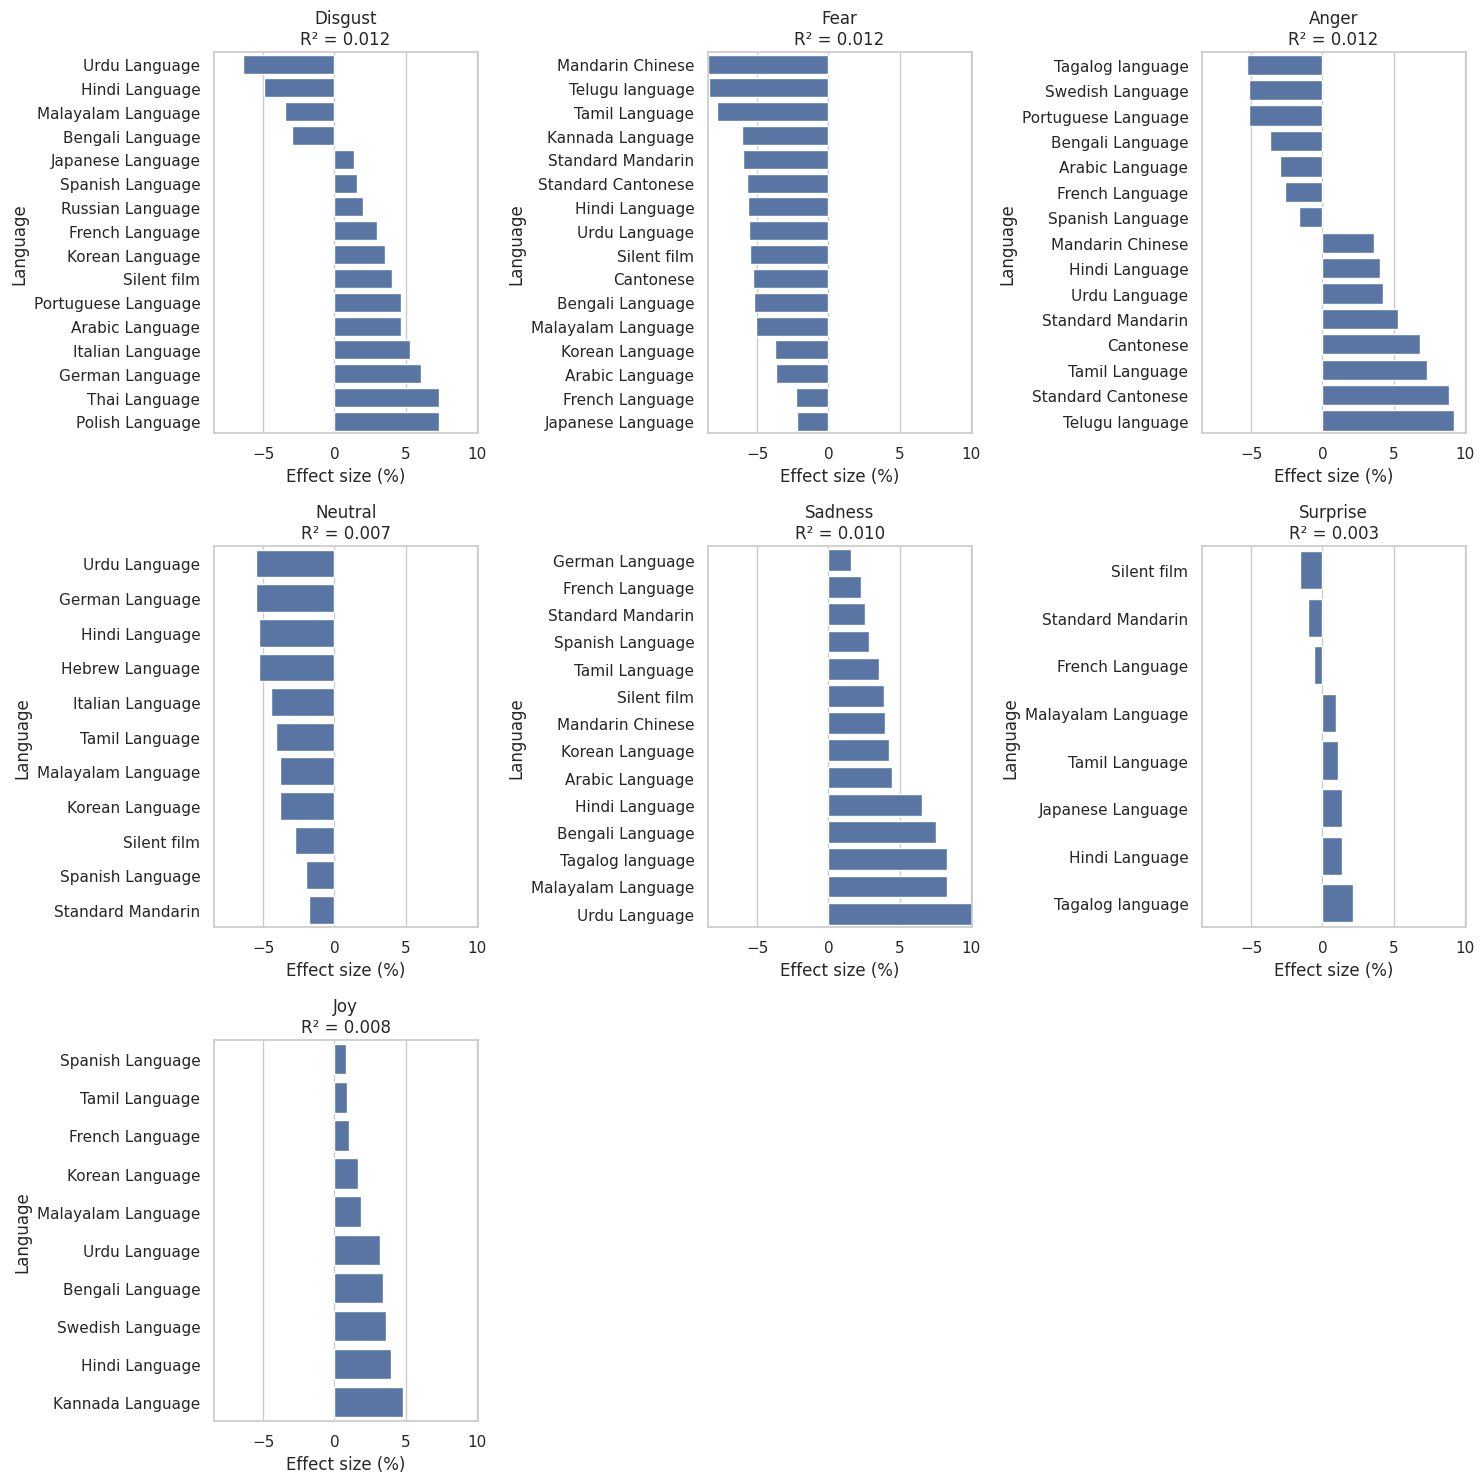

In [38]:
plot_significant_language_per_emotion(regression_results, EMOTIONS)

## Analysis of Regression Results

### Reference Category: English
English was selected as the reference category for the regression analysis because it is both the largest and most normative language category in the dataset.

### Low Overall Effect Size of Language on Emotional Content
- The $R^2$ values for the models are very low (ranging from 0.003 to 0.012), indicating that language explains only a minimal portion of the variance in emotional content.
- This result is expected, as the emotional tone of a film is predominantly influenced by factors such as its **plot**, **acting**, **cinematography**, and other creative elements rather than the language itself.

### Specific Observations
- For the **fear** emotion, all languages that showed significant effects had **negative coefficients** compared to English, indicating a lower proportion of "fear" in films made in those languages.
- Conversely, for the **joy** and **sadness** emotions, all languages with significant effects had **positive coefficients** compared to English, suggesting a higher proportion of these emotions in films made in those languages.


##### Correlated emotions
OLS assumes that emotions from the same movie are treated as independent observations. However, this is probably not true because a more positive-film is more likely to have more positive emotions.

In [39]:
# Run MANOVA for a multivariate analysis of the emotions
manova_results = manova_emotion_language(df_languages, EMOTIONS)
print(manova_results.summary())

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
         Intercept        Value  Num DF   Den DF   F Value  Pr > F
------------------------------------------------------------------
            Wilks' lambda 0.8999 6.0000 34012.0000 630.2629 0.0000
           Pillai's trace 0.1001 6.0000 34012.0000 630.2629 0.0000
   Hotelling-Lawley trace 0.1112 6.0000 34012.0000 630.2629 0.0000
      Roy's greatest root 0.1112 6.0000 34012.0000 630.2629 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
       Languages        Value   Num DF     Den DF   F Value Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.9447 162.0000 199859.5822 12.0125 0.0000
         Pillai'

## MANOVA Results

The results from all four test statistics (**Wilks' Lambda**, **Pillai's Trace**, **Hotelling-Lawley Trace**, and **Roy's Greatest Root**) indicate highly significant differences in emotional expression patterns across movies in different languages ($Pr > F = 0.0000$). This provides strong evidence that language plays a role in shaping emotional tones in films.

However, the effect sizes are very small, as anticipated from the earlier ANOVA results for individual emotions. For example, a Wilks' Lambda value of **0.9447** suggests that only **5.53%** of the variance in emotional expression can be attributed to language, highlighting that most of the variability is explained by other factors. 


## 5. Can films be clustered based on their emotional tone, and do these clusters reveal distinct patterns in consumer ratings?

## Hierarhcial Clustering

In [40]:
ratings = ['mean_ratings', 'std_dev_ratings']

filter_df = emotions_df.dropna(subset=['Plot'])
df_hierarchial = filter_df[EMOTIONS + ratings].reset_index(drop=True)

The data are already on the same scale and sum to 1 representing proportions of the emotional tone of the film so there is no need to normalize them.

We start from doing some exploration of the data.

To start, we perform a Hierchical Clustering o the data and plot the dendrogram to see if there are any clear clusters.

We will perform Hierchical Clustering with average linkage and Cosine distance. The Cosine distance is chosen because it is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Thats works particularly well when the data are in distributed in a simplex like in this case.

Since Hierchical Clustiering computes dinstances between all pairs of points, it scales poorly with large dataset like ours. To have and understandig of the possible clusters we will use a subset of 500 data points.

To start, we perform a Hierchical Clustering o the data and plot the dendrogram to see if there are any clear clusters.

We will perform Hierchical Clustering with average linkage and Cosine distance. The Cosine distance is chosen because it is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Thats works particularly well when the data are in distributed in a simplex like in this case.

Since Hierchical Clustiering computes dinstances between all pairs of points, it scales poorly with large dataset like ours. To have and understandig of the possible clusters we will use a subset of 500 data points.

In [41]:
sample_df, cluster_df, distance_matrix, linkage_matrix = hierarchial(df_hierarchial, EMOTIONS)

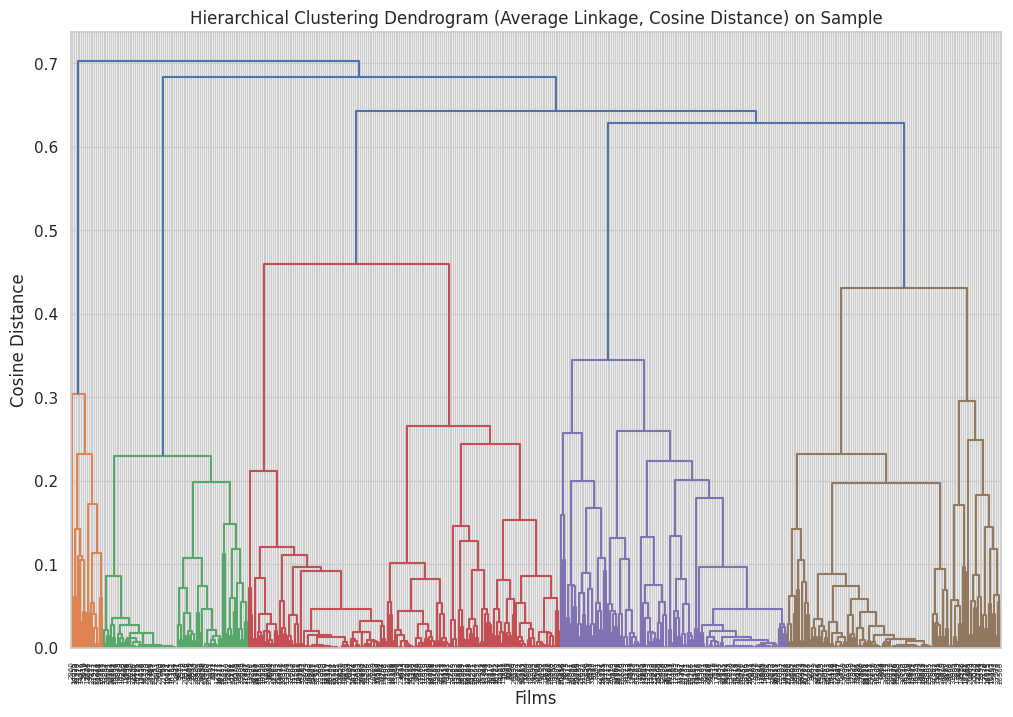

In [42]:
plot_dendrogram(cluster_df, linkage_matrix)

In [43]:
cluster_labels, distance_square = assign_clusters(distance_matrix, linkage_matrix, cluster_df)
inner_cluster_distances = compute_inner_cluster_distances(cluster_labels, distance_square)
inner_cluster_distances

{1: 0.17915203395297508,
 2: 0.1548717409338018,
 3: 0.08524913979233686,
 4: 0.19856307786260435,
 5: 0.22647867626450144,
 6: 0.12105150467831619,
 7: 0.20818028729421426}

In [44]:
sample_df = pd.concat([cluster_df, sample_df[ratings]], axis=1)
cluster_summary = sample_df.groupby('cluster').mean()
cluster_summary

disgust      fear     anger   neutral   sadness  surprise       joy  \
cluster                                                                         
1        0.109742  0.064062  0.089342  0.134547  0.073385  0.504592  0.024330   
2        0.095067  0.593484  0.150145  0.097640  0.034013  0.021828  0.007823   
3        0.097704  0.051368  0.646144  0.103608  0.058588  0.019774  0.022814   
4        0.474915  0.039981  0.229493  0.157039  0.073580  0.010769  0.014224   
5        0.098432  0.081701  0.098737  0.138472  0.529758  0.027796  0.025103   
6        0.066829  0.063999  0.076389  0.636251  0.056975  0.040132  0.059425   
7        0.080505  0.016390  0.058520  0.267902  0.117829  0.053301  0.405553   

         mean_ratings  std_dev_ratings  
cluster                                 
1            2.869160         0.997983  
2            2.792405         0.910411  
3            2.943252         0.997451  
4            3.106239         0.966592  
5            3.079460         1.061549  
6            3.022045         1.059960  
7            2.664684         1.026668

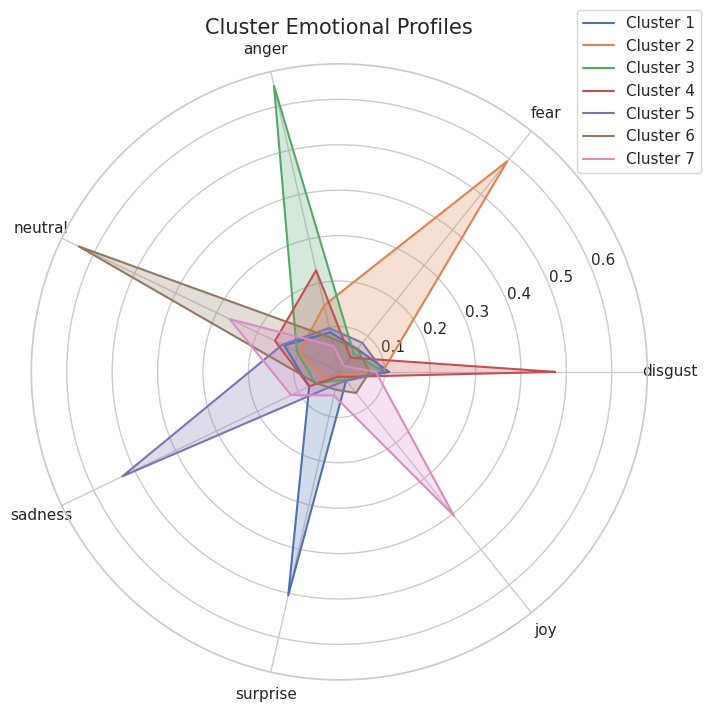

In [45]:
plot_radar_chart(cluster_summary[EMOTIONS], "Cluster Emotional Profiles")

In [46]:
df_clustering = df.copy()

In [47]:
df_clustering = df_clustering.drop(columns = ["FreebaseID", "Genres_tuples", "Languages_tuple", "Countries_tuples", "ActorGenderFlag", "movieId", "ActorGender", "merge_year"])

In [48]:
assert df_clustering["distilbert_emotions"].isna().sum() == df_clustering["Plot"].isna().sum()
df_clustering = df_clustering.dropna(subset = ["distilbert_emotions"])
df_clustering["distilbert_emotions"] = df_clustering["distilbert_emotions"].apply(conv_to_dict)

In [49]:
print (df_clustering["distilbert_emotions"][0].keys())

df_clustering["disgust"] = df_clustering["distilbert_emotions"].apply(lambda x: x["disgust"])
df_clustering["fear"] = df_clustering["distilbert_emotions"].apply(lambda x: x["fear"])
df_clustering["anger"] = df_clustering["distilbert_emotions"].apply(lambda x: x["anger"])
df_clustering["neutral"] = df_clustering["distilbert_emotions"].apply(lambda x: x["neutral"])
df_clustering["sadness"] = df_clustering["distilbert_emotions"].apply(lambda x: x["sadness"])
df_clustering["surprise"] = df_clustering["distilbert_emotions"].apply(lambda x: x["surprise"])
df_clustering["joy"] = df_clustering["distilbert_emotions"].apply(lambda x: x["joy"])
df_emotions = df_clustering[["disgust","fear","anger","neutral","sadness", "surprise","joy" ]]
emotions_columns = ["disgust","fear","anger","neutral","sadness", "surprise","joy"]
df_emotions.head()

dict_keys(['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'])


disgust      fear     anger   neutral   sadness  surprise       joy
0   0.502122  0.351022  0.065147  0.057085  0.018771  0.004086  0.001766
3   0.324022  0.032032  0.502404  0.096385  0.037811  0.005438  0.001907
4   0.163747  0.002405  0.325650  0.440068  0.025255  0.005851  0.037024
12  0.021709  0.010488  0.006082  0.042634  0.915504  0.002163  0.001421
13  0.004746  0.003841  0.016094  0.679410  0.057925  0.129912  0.108072

### Understand the Data

In [50]:
df_emotions.describe()

disgust          fear         anger       neutral       sadness  \
count  33684.000000  33684.000000  33684.000000  33684.000000  33684.000000   
mean       0.177764      0.149237      0.198539      0.219286      0.162752   
std        0.214311      0.234104      0.229028      0.222535      0.233720   
min        0.000178      0.000261      0.000586      0.000273      0.000860   
25%        0.028759      0.008766      0.025399      0.051294      0.017766   
50%        0.089153      0.033777      0.098616      0.131612      0.050893   
75%        0.240457      0.177506      0.305622      0.321224      0.201197   
max        0.987099      0.994397      0.990883      0.966400      0.988606   

           surprise           joy  
count  33684.000000  33684.000000  
mean       0.046947      0.045474  
std        0.117281      0.123427  
min        0.000331      0.000223  
25%        0.004817      0.002622  
50%        0.010622      0.005704  
75%        0.029210      0.020456  
max        0.982970      0.983576

### Data Distributions: Standardized vs Unstandardized

To understand the distribution of the emotion scores better we look at the box-plots and the density distribution of the standardizes and th not standardized emotion scores.

We can see that the data is very right skewed. This means that emition values are centered near zero most of the time. This is because of the characteristic that they sum up to 1 and often for each movie only one or two emotions dominate. We can also see that some emotions like "neutral", "anger" and "disgust" are more dominant as their mean values are higher. One the other side there the emotions "surprise" and "joy" are not represented that much in movie pots as their means are the closest to zero. Nevertheless thes emotions also dominate from time to time which leeds to a very high standard deviation as can be seen when looking at the standardized distributions.

In [51]:
df_emotions_standardized = standardize_emotions(df_emotions, EMOTIONS)

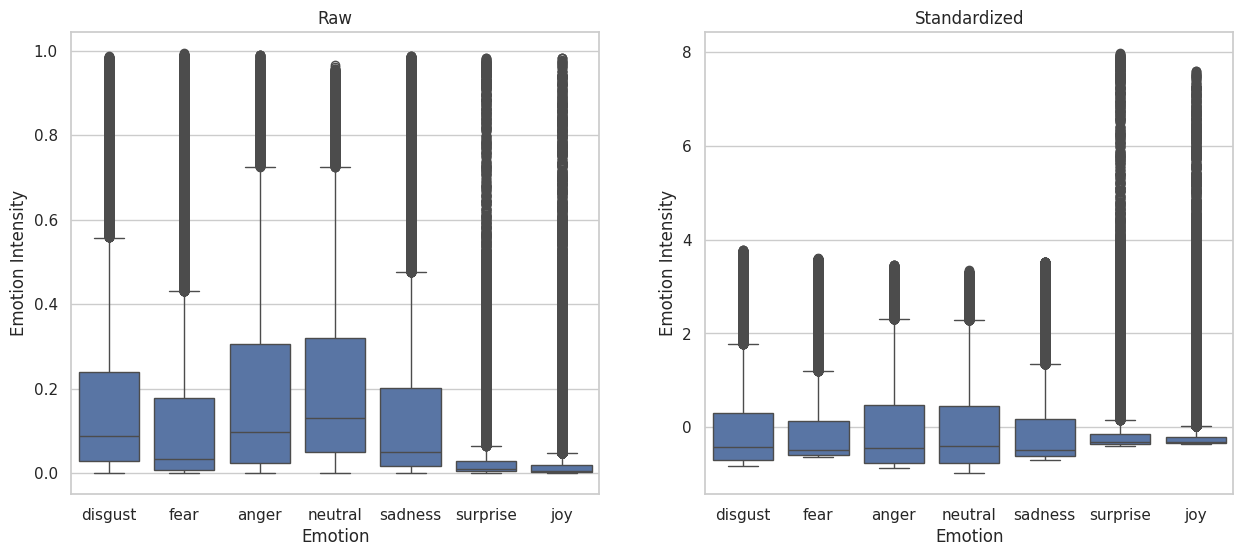

In [52]:
plot_stddized_emotion_comparison(df_emotions, df_emotions_standardized)

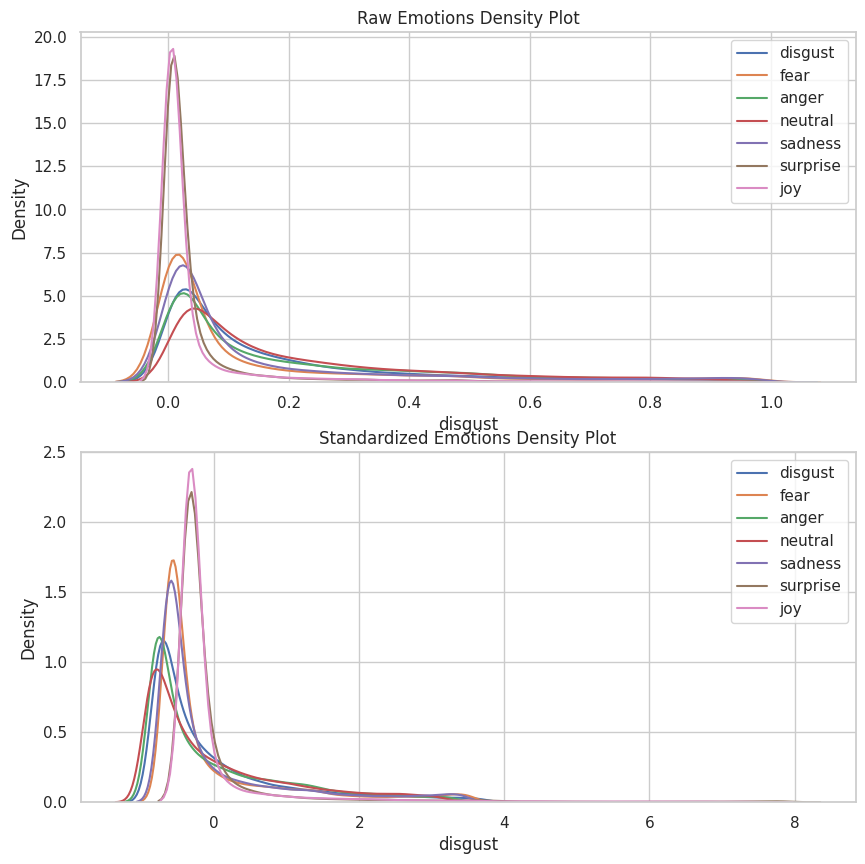

In [53]:
plot_emotion_density_comparison(df_emotions, df_emotions_standardized)

### Analysis with Dimensionality Reduction

## PCA

Measures linear relationship between data points. PCA leverages correlation between dimensions to retain as much variance as possible while projecting the features to a lower dimensional space.

The results shows that all 7 principal components show significant variance, which is a sign for less correlation between dimensions. This is supported by the correlations shown in the table below. The visualization in 2d with the first two principal component only captures about 40% of the variance and therefore, might not be suitable for measuring the clustering quality.

In [54]:
perform_pca(df_emotions)

1.0000000000000002
Explained Variance Ratio per Principal Component:  [2.50840472e-01 2.33438355e-01 2.23083526e-01 1.76825303e-01
 6.57153431e-02 5.00970001e-02 1.24580278e-15]


## Compute Correlation

As assumed from the PCA results there is no high correlation between the emotions. The highest correlation value is about negative 0.3 between neutral and anger)

In [55]:
correlation_matrix = df_emotions.corr()
correlation_matrix

disgust      fear     anger   neutral   sadness  surprise       joy
disgust   1.000000 -0.222989 -0.054629 -0.222855 -0.239088 -0.186218 -0.180542
fear     -0.222989  1.000000 -0.199830 -0.272488 -0.226751 -0.055683 -0.165145
anger    -0.054629 -0.199830  1.000000 -0.297105 -0.260816 -0.154437 -0.205403
neutral  -0.222855 -0.272488 -0.297105  1.000000 -0.219383 -0.028890  0.094986
sadness  -0.239088 -0.226751 -0.260816 -0.219383  1.000000 -0.091668 -0.081771
surprise -0.186218 -0.055683 -0.154437 -0.028890 -0.091668  1.000000 -0.009015
joy      -0.180542 -0.165145 -0.205403  0.094986 -0.081771 -0.009015  1.000000

## 2.3 Ratings Distribution

Examining the distribution of the movie ratings shows an average rating of about 3.04 out of 5. The availabel rating values rtange from 0.5 to 5.0.

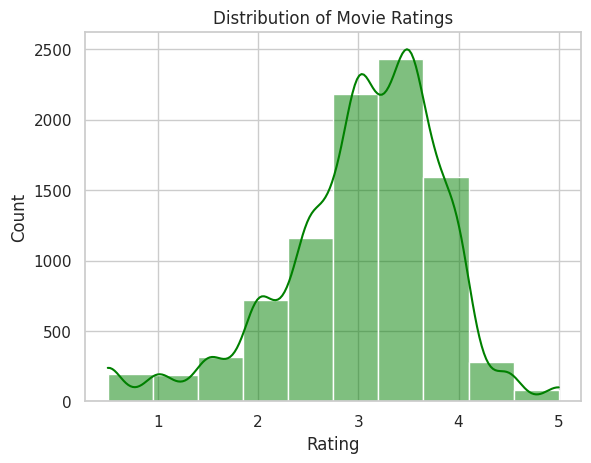

count    9139.000000
mean        3.044481
std         0.801812
min         0.500000
25%         2.625000
50%         3.152778
75%         3.571429
max         5.000000
Name: mean_ratings, dtype: float64


In [56]:
plot_ratings_distribution(df_emotions, df, EMOTIONS)

## Clustering

To cluster the movies based on their structure of emotions we try different clustering algorithms:
- K-means clustering
- Hierarchical clustering
- DBSCAN

## K-Means Clustering
### Finding the optimal number of clusters k

For K-means, both shilouette score and ellbow method, reveal an optimal k of 7, which matches the number of emotions.

In [57]:
# plot_silhouette_scores(df_emotions_standardized)

In [58]:
# plot_sse(df_emotions_standardized)

In [59]:
optimal_k = 7

### Different Cluster Initializations to Escape Local Optimums
The objective function of K-Means is to minimizing the within-cluster sum of squares (inertia). This is the metric it tries to minimize at each iteration. Therefore, initialization methods like k-means++' with n_init uses inertia to select the best initialization.

In [60]:
# km_best_init = find_best_init(df_emotions_standardized, optimal_k)

The result shows that k-means++' with n_init= 1000 finds a cluster with a within-cluster distance of 61240.47. The improvements with an increasing number of n_init are marginal, as after n_init=10 the inertia is already at 61240. Therefore, we can assume that with the retrieved initialization we are near the global optimum in this setting with the k-means algorithm.

## Visualization
### Visualization with PCA

Even though, the clusters are mainly separated in the 2-dimensional PCA space (using the first 4 PC), the centroids of each clusters are mostly gathered around a point in space. Thus, the linear method PCA is not suitable to display clear separation of the clusters, when reducing it to 2-dimensional space. This is due to the non-linearity of the data (see also the analyis before)

In [61]:
# clustering_pca_visualizations(df_emotions_standardized, km_best_init)

### Visualizing with T-SNE
The 2-dimensional visualization with t-sne shows a similar result like PCA: Even though, t-sne can capture non-linearity the simplex shape and relevance of each emotion/ dimension of the data is not suitable to be broken down into 2-dimesions.

In [62]:
# clustering_tsne_visualizations(df_emotions_standardized, km_best_init)

## Calculating Cluster Based Consumer Ratings
### Calculating Ratings for Each Cluster

In [63]:
# df_km_cluster_emotions, df_km_cluster_catings_grouped = calculate_cluster_ratings(df, df_emotions, km_best_init, EMOTIONS)

In [64]:
# plot_parallel_coordinates(df_km_cluster_emotions)

In [65]:
# plot_radar_chart(df_km_cluster_emotions[EMOTIONS], "Emotion Profile K-means")

## K-means comparision with standardized emotions scores
The comparison shows that the clustering pattern is the same, when standardizing the data

In [66]:
# df_cluster_emotions, cluster_ratings = calculate_cluster_ratings(df, df_emotions_standardized, km_best_init, EMOTIONS)
# plot_parallel_coordinates(df_cluster_emotions)

## Kmeans with cosine similarity raw emotions

Similar pattern is also shown using cosine distance metric instead of euclidean distance

In [67]:
# normalized_data = normalize(df_emotions, norm='l2')
# kmeans_cosine = find_best_init(normalized_data, optimal_k)
# df_cluster_emotions, cluster_ratings = calculate_cluster_ratings(df, df_emotions, kmeans_cosine, EMOTIONS)
# plot_parallel_coordinates(df_cluster_emotions)

## Kmeans with cosine similarity standardized emotions

In [68]:
# normalized_data = normalize(df_emotions_standardized, norm='l2')
# kmeans_cosine = find_best_init(normalized_data, optimal_k)
# df_cluster_emotions, cluster_ratings = calculate_cluster_ratings(df, df_emotions_standardized, kmeans_cosine, EMOTIONS)
# plot_parallel_coordinates(df_cluster_emotions)

# DBSCAN

## Findings DBSCAN

Standardized:
- eps: 0.1; filter movie_rating_count >5: anger& disgust bad; joy abd; no much profile bad

## Try different DBSCAN configurations

Metrics:
1. Sum of withing cluster distances
2. Number of clusters
3. Number of clusters with number of movies >5

First we look how the number of clusters and the number of movies within a cluster evolves over different eps values in DBSCAN. It quickly shows that we need eps values below 0.1 to get a significant amount of clusters

In [72]:
dbscan_by_epsilon(df, df_emotions, EMOTIONS)

Current epsilon: 0.01
total within cluster distance 3.091640336581414
Sum of within cluster distances 3.091640336581414
Number of clusters 660
Number of clusters with number of movies >5 37
Current epsilon: 0.02526315789473684
total within cluster distance 27.651417299611364
Sum of within cluster distances 27.651417299611364
Number of clusters 2179
Number of clusters with number of movies >5 159
Current epsilon: 0.04052631578947368
total within cluster distance 34.551049550051374
Sum of within cluster distances 34.551049550051374
Number of clusters 1646
Number of clusters with number of movies >5 145
Current epsilon: 0.05578947368421053
total within cluster distance 22.103370645901652
Sum of within cluster distances 22.103370645901652
Number of clusters 767
Number of clusters with number of movies >5 69
Current epsilon: 0.07105263157894737
total within cluster distance 12.190197882563927
Sum of within cluster distances 12.190197882563927
Number of clusters 328
Number of clusters with n

## Filter and visualize clusters with very low rating across eps values

Dominant pattern across multiple eps values:
- High "fear" score paired with some grain of "surprise", "sadness" or "neutral" (see eps (0.035, 0.045, 0.05, 0.055, 0.06

High negative score for small eps distance:
- With very small eps (0.025 and 0.03), which indicates very similar emotion patterns, we see very low average cluster rating (

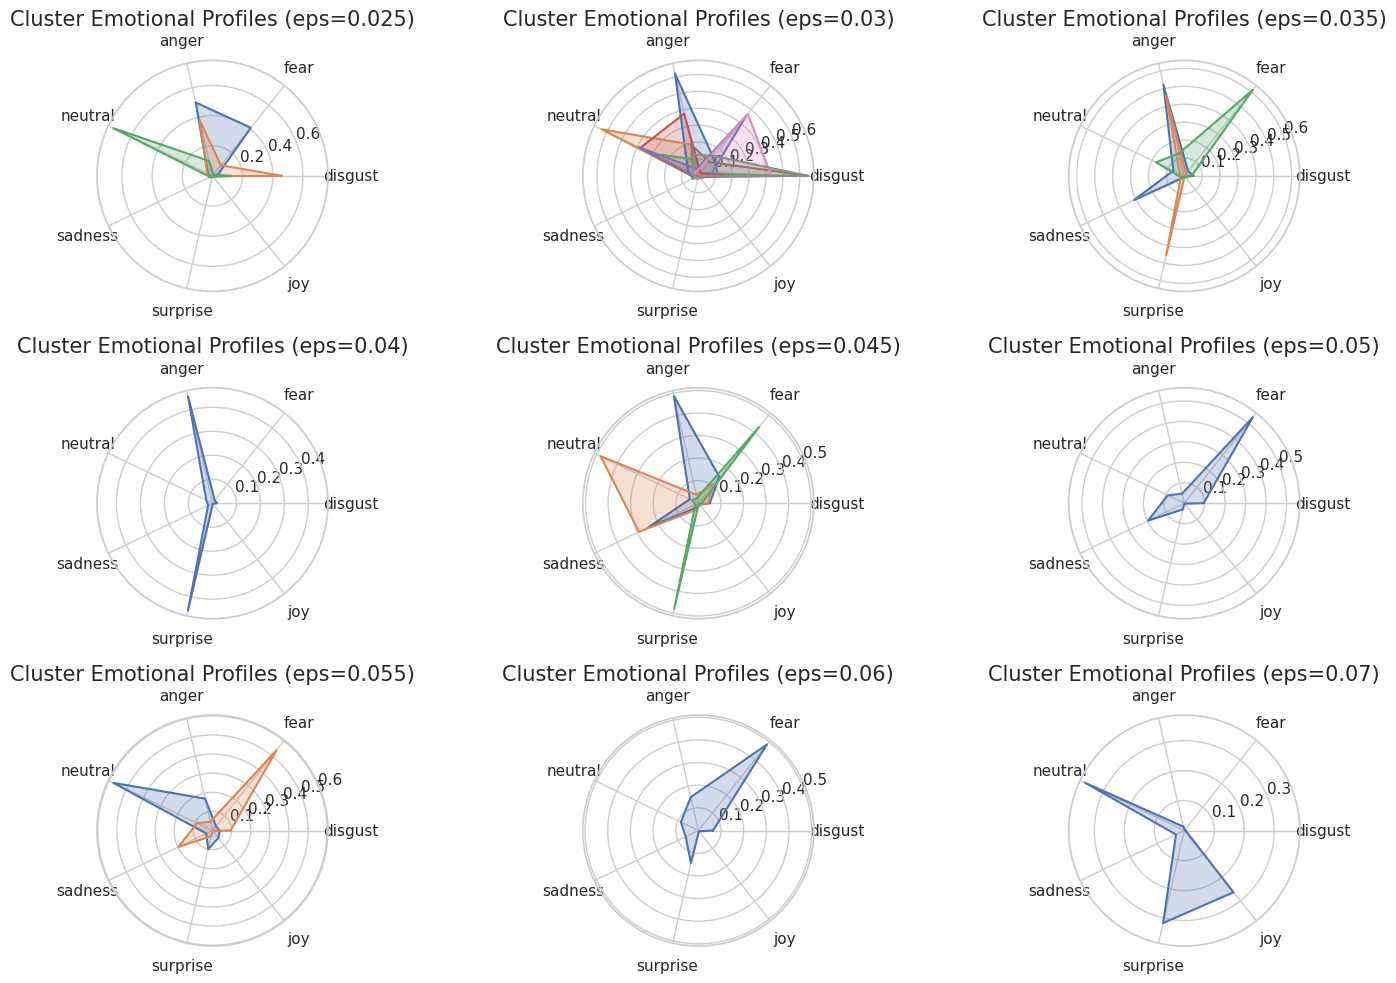

In [76]:
plot_radar_per_epsilon(df, df_emotions, EMOTIONS)

Very low average cluster score (more 1.25 times of standard deviation) with dominant emotions disgust

In [77]:
filter_clusters_dbscan(df, df_emotions, EMOTIONS)

mean_ratings  rating_movies_count
31       2.063176                    4
731      2.039931                    8

## Filter and visualize clusters with very high rating across eps values

Dominant pattern across multiple eps values:
- “surprise” coupled with “sadness,” or films where “neutral” and “joy”
- high disgust intertwined with a bit of anger, a dash of neutral, and a hint of sadness—but crucially, without fear.

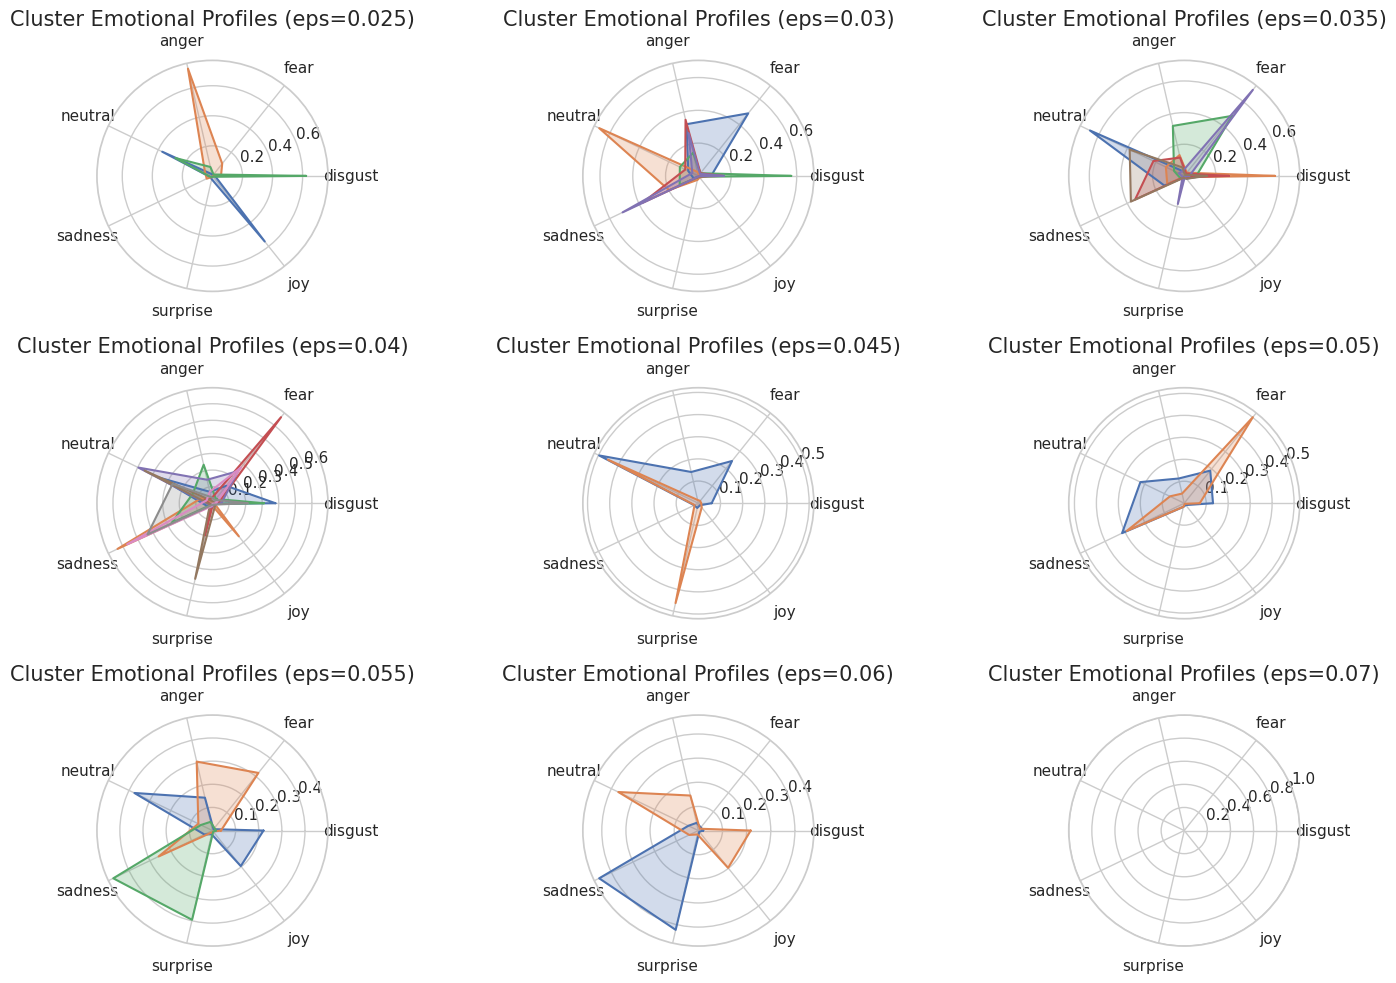

In [78]:
plot_radar_per_epsilon(df, df_emotions, EMOTIONS, True)